In [2]:
# load packages
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import pickle

import geopandas as gpd # http://geopandas.org/gallery/plotting_basemap_background.html#sphx-glr-gallery-plotting-basemap-background-py
import contextily as ctx

import shapely.wkt # https://stackoverflow.com/questions/51855917/shapely-polygon-from-string
from shapely.geometry import Point, LineString, MultiLineString, Polygon
from shapely.ops import cascaded_union

In [3]:
df_col = pd.read_csv('data/NYPD_Motor_Vehicle_Collisions_-_Crashes.zip')

# make column names lower-case
df_col.rename(columns={c:c.lower() for c in df_col.columns}, inplace=True)

# convert data type
df_col['location'] = df_col['location'].apply(lambda x: shapely.wkt.loads(x) if not pd.isnull(x) else np.nan)

# correct wrong data
df_col.loc[
    ((40.489 > df_col['latitude']) | (df_col['latitude'] > 40.924) |  # NYC boundary
     (-74.272 > df_col['longitude']) | (df_col['longitude'] > -73.689)) # NYC boundary
    , ['latitude','longitude','location']    
] = np.nan


C:\Users\caffr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# functions
def Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_bike', injured_killed='injured'):
    pp = df_col.groupby(list(set([c for c in ['year',col,hue] if pd.notnull(c)]))).sum().reset_index(drop=False)
    pp = pp.loc[(pp['year'] >= 2013) & (pp['year'] <= 2018)] # only year = [2013,2014,2015,2016,2017,2018]

    if pd.notnull(col) & pd.notnull(hue):
        sns.lmplot(x='year', y="number of persons "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html
        sns.lmplot(x='year', y="number of motorist "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html
        sns.lmplot(x='year', y="number of pedestrians "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html
        sns.lmplot(x='year', y="number of cyclist "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html

    else:
        pp = pd.melt(pp, 
             id_vars=['year'], 
             value_vars=['number of persons '+injured_killed,'number of motorist '+injured_killed,'number of pedestrians '+injured_killed,'number of cyclist '+injured_killed],
             var_name='type', 
             value_name='number of '+injured_killed)
        sns.lmplot(x='year', y="number of "+injured_killed, hue='type', data=pp, aspect=1.2) # https://seaborn.pydata.org/tutorial/regression.html

    plt.show()

def Plot_Geoms_On_NYCMap(geoms, ON_MAP=True):
    #ref) https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
    # df = gpd.GeoDataFrame(geometry=df_col['location'].dropna().loc[1:1000], crs={'init':'epsg:4326'}) 
    df = gpd.GeoDataFrame(geometry=geoms, crs={'init':'epsg:4326'}) 
    df = df.to_crs(epsg=3857) # convert data to the same CRS to combine our polygons and background tiles in the same map

    # NYC borough boundaries
    #ref) http://geopandas.org/gallery/plotting_basemap_background.html#sphx-glr-gallery-plotting-basemap-background-py
    df_nyc = gpd.read_file(gpd.datasets.get_path('nybb')) # NYC borough boundary data that is available in geopandas datasets
    df_nyc = df_nyc.to_crs(epsg=3857) # convert data to the same CRS to combine our polygons and background tiles in the same map

    #--- plot --------------------
    fig, ax = plt.subplots(figsize=(15,15))
    df_nyc.plot(ax=ax, color='none', edgecolor='b', alpha=1.0, linewidth=1.5) # NYC borough boundaries
    df.plot(ax=ax, color='r', edgecolor='r', alpha=0.2, markersize=1)
    if ON_MAP:
#         ctx.add_basemap(ax)
#         ctx.add_basemap(ax, zoom=12)
        ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    
# Plot_Geoms_On_NYCMap(df_col.loc[df_col['on street name'].isnull(),'location'].dropna())    

#-------------------------------------------------------------------------------
# from nltk.metrics.distance import edit_distance
# # http://maf.directory/zp4/abbrev.html
# word = 'lane'
# ww = pd.DataFrame({'word':aa, 'count':0}).groupby('word').count().reset_index().sort_values(by='count', ascending=False)
# ww['ii'] = ww['word'].apply(lambda w: word[0] != w[0])
# ww['ss'] = ww['word'].apply(lambda w: edit_distance(word, w, transpositions = True))
# ww.sort_values(by=['ii','ss'])

def find_road_type(streetname):
    if len(set(streetname.lower().split()).intersection(['expressway','expressay','expresswaay','expresway','exressway','express','expway','expwy','expre','exway','expy','exwy','exwpy','exp','exp.'])) > 0:
        return 'expressway'
    elif len(set(streetname.lower().split()).intersection(['parkway','parrkway','parlway','parkwway','parkwayy','parkwary','prkwy','pkwy'])) > 0:
        return 'parkway'
#     elif len(set(streetname.lower().split()).intersection(['highway','hwy'])) > 0:
#         return 'highway'
    elif len(set(streetname.lower().split()).intersection(['drive','dr'])) > 0:
        return 'drive'
#     elif ((len(set(streetname.lower().split()).intersection(['drive','dr'])) > 0) &
#           (len(set(streetname.lower().split()).intersection(['fdr'])) == 0)):
#         return 'drive'
#     elif len(set(streetname.lower().split()).intersection(['fdr'])) > 0:
#         return 'fdr drive'
#     elif len(set(streetname.lower().split()).intersection(['broadway'])) > 0:
#         return 'broadway'
#     elif len(set(streetname.lower().split()).intersection(['turnpike','tpke'])) > 0:
#         return 'turnpike'
#     elif len(set(streetname.lower().split()).intersection(['thruway','thruwy','thurway','throughway'])) > 0:
#         return 'thruway'
#     elif len(set(streetname.lower().split()).intersection(['concourse','concours'])) > 0:
#         return 'concourse'
    elif len(set(streetname.lower().split()).intersection(['bridge','bridge/','bridge,','bridgte','brdg','brg'])) > 0:
        return 'bridge'
    
    elif len(set(streetname.lower().split()).intersection(['street','st','st.'])) > 0:
        return 'street'
#     elif len(set(streetname.lower().split()).intersection(['boulevard','blvd'])) > 0:
#         return 'boulevard'
    elif len(set(streetname.lower().split()).intersection(['avenue','ave'])) > 0:
        return 'avenue'
    elif len(set(streetname.lower().split()).intersection(['road','rd'])) > 0:
        return 'road'
    else:
        return 'others'
    

def count_by_year_borough(df, col1 = None, col2 = None, injured_killed='injured'):
    #df1 = df.loc[(df['year'] >=2012) & (df['year'] <= 2015)]
    #df2 = df.loc[(df['year'] >=2016) & (df['year'] <= 2019)]
    
    if pd.notnull(col1) & pd.notnull(col2):
        #tab1 = df1.groupby([col1, col2])['number of persons ' + injured_killed, 'number of pedestrians ' + injured_killed,'number of cyclist ' + injured_killed, 'number of motorist ' + injured_killed].sum()
        #tab2 = df2.groupby([col1, col2])['number of persons ' + injured_killed, 'number of pedestrians ' + injured_killed,'number of cyclist ' + injured_killed, 'number of motorist ' + injured_killed].sum()
        #return(tab1, tab2)
        return(df.groupby([col1, col2])['number of persons ' + injured_killed, 'number of pedestrians ' + injured_killed,'number of cyclist ' + injured_killed, 'number of motorist ' + injured_killed].sum())
    else:
        #tab1 = df1.groupby(['year', 'borough'])['number of pedestrians ' + injured_killed,'number of cyclist ' + injured_killed, 'number of motorist ' + injured_killed].sum()
        #tab2 = df2.groupby(['year', 'borough'])['number of pedestrians ' + injured_killed,'number of cyclist ' + injured_killed, 'number of motorist ' + injured_killed].sum()
        #return(tab1, tab2)
        return(df.groupby(['year', 'borough'])['number of pedestrians ' + injured_killed,'number of cyclist ' + injured_killed, 'number of motorist ' + injured_killed].sum())
    

def pivot_table(df, injured_killed = 'injured',index= 'borough'):
    tab = pd.pivot_table(df, values=['number of persons ' + injured_killed,'number of pedestrians ' + injured_killed, 'number of cyclist ' + injured_killed,'number of motorist ' + injured_killed], index=[index], aggfunc=np.sum)
    return(tab.sort_values(by = 'number of persons ' + injured_killed, ascending = False))

In [5]:
# impute data : borough, zip code, on street name
def Load_New_Data_From_OpenStreetMap():
    zz = []
    for n in range(0,35):
        print(n)
        zz.append(pd.read_pickle('data/openstreetmap/geopy_(%s).pickle'%n))
    zz = pd.concat(zz, axis=0).reset_index(drop=True)
    print(zz.shape)
    zz = zz.drop_duplicates(subset='unique id')
    print(zz.shape)
    print(zz.info())
    zz.head()
    
    aa = zz['geopy'].apply(lambda x: x['address']['county'].upper()).map({
        'NEW YORK COUNTY':'MANHATTAN', 
        'BRONX COUNTY':'BRONX', 
        'QUEENS COUNTY':'QUEENS', 
        'KINGS COUNTY':'BROOKLYN',
        'RICHMOND COUNTY':'STATEN ISLAND'})
    bb = zz['geopy'].apply(lambda x: x['address']['postcode'][0:5].replace('1122O','11220')
                           if 'postcode' in x['address'].keys() else np.nan).apply(lambda y: int(y) if (y not in ['(718)','NY 11','NY 10']) & (not pd.isnull(y)) else np.nan)
    cc = zz['geopy'].apply(lambda x: x['address']['road'].upper()
                           if 'road' in x['address'].keys() else np.nan)

    zz.loc[zz['borough'].isnull(),'borough'] = aa[zz['borough'].isnull()]
    zz.loc[zz['zip code'].isnull(),'zip code'] = bb[zz['zip code'].isnull()]
    zz.loc[zz['on street name'].isnull(),'on street name'] = cc[zz['on street name'].isnull()]

    print(zz.info())
    zz.head()   
    return zz

zz = Load_New_Data_From_OpenStreetMap()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
(482606, 7)
(482606, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 482606 entries, 0 to 482605
Data columns (total 7 columns):
unique id         482606 non-null int64
latitude          482606 non-null float64
longitude         482606 non-null float64
borough           177468 non-null object
zip code          177298 non-null object
on street name    231399 non-null object
geopy             482606 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 29.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 482606 entries, 0 to 482605
Data columns (total 7 columns):
unique id         482606 non-null int64
latitude          482606 non-null float64
longitude         482606 non-null float64
borough           482288 non-null object
zip code          481442 non-null object
on street name    479847 non-null object
geopy             482606 non-null object
dtypes: float64(2

In [6]:
df_col.set_index('unique id', inplace=True)
df_col.loc[zz['unique id'],['borough','zip code','on street name']] = zz[['unique id','borough','zip code','on street name']].set_index('unique id')
df_col.reset_index(inplace=True)

print(df_col.shape)
print(df_col.info())
df_col.head()

(1558237, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558237 entries, 0 to 1558236
Data columns (total 29 columns):
unique id                        1558237 non-null int64
date                             1558237 non-null object
time                             1558237 non-null object
borough                          1392954 non-null object
zip code                         1392091 non-null object
latitude                         1364727 non-null float64
longitude                        1364727 non-null float64
location                         1364727 non-null object
on street name                   1503396 non-null object
cross street name                1044964 non-null object
off street name                  211127 non-null object
number of persons injured        1558220 non-null float64
number of persons killed         1558206 non-null float64
number of pedestrians injured    1558237 non-null int64
number of pedestrians killed     1558237 non-null int64
number of cyclist 

unique id        date   time    borough zip code   latitude  longitude  \
0    4194003  08/24/2019  11:53        NaN      NaN        NaN        NaN   
1    4194562  08/24/2019  13:22        NaN      NaN        NaN        NaN   
2    4194211  08/24/2019  23:00        NaN      NaN        NaN        NaN   
3    4193896  08/24/2019  23:50        NaN      NaN        NaN        NaN   
4    4193507  08/23/2019   0:12  MANHATTAN    10031  40.825134  -73.95141   

                      location                    on street name  \
0                          NaN  CROSS BRONX EXPY RAMP              
1                          NaN  VERRAZANO BRIDGE LOWER             
2                          NaN  MEEKER AVENUE                      
3                          NaN  MERIDIAN RD                        
4  POINT (-73.95141 40.825134)  BROADWAY                           

  cross street name off street name  number of persons injured  \
0               NaN             NaN                        3.0   
1               NaN             NaN                        0.0   
2               NaN             NaN                        0.0   
3      NEW YORK AVE             NaN                        0.0   
4               NaN             NaN                        0.0   

   number of persons killed  number of pedestrians injured  \
0                       0.0                              0   
1                       0.0                              0   
2                       0.0                              0   
3                       0.0                              0   
4                       0.0                              0   

   number of pedestrians killed  number of cyclist injured  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   number of cyclist killed  number of motorist injured  \
0                         0                           3   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   number of motorist killed   contributing factor vehicle 1  \
0                          0                 Other Vehicular   
1                          0  Reaction to Uninvolved Vehicle   
2                          0             Passing Too Closely   
3                          0         View Obstructed/Limited   
4                          0            Unsafe Lane Changing   

  contributing factor vehicle 2 contributing factor vehicle 3  \
0  Aggressive Driving/Road Rage                           NaN   
1                   Unspecified                           NaN   
2                   Unspecified                           NaN   
3                           NaN                           NaN   
4                   Unspecified                           NaN   

  contributing factor vehicle 4 contributing factor vehicle 5  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

                   vehicle type code 1 vehicle type code 2  \
0                                Sedan               Sedan   
1  Station Wagon/Sport Utility Vehicle               Sedan   
2                                Sedan          Motorcycle   
3  Station Wagon/Sport Utility Vehicle                 NaN   
4                        Pick-up Truck               Sedan   

  vehicle type code 3 vehicle type code 4 vehicle type code 5  
0                 NaN        

In [7]:
# create new columns

df_col['date_time'] = pd.to_datetime(df_col['date'] + ' ' + df_col['time'], format= '%m/%d/%Y %H:%M')
df_col['year'] = df_col['date_time'].dt.year
df_col['month'] = df_col['date_time'].dt.month
df_col['dayofweek'] = df_col['date_time'].dt.dayofweek
df_col['hour'] = df_col['date_time'].dt.hour

df_col['is_borough_null'] = df_col['borough'].isnull()
df_col['borough'].fillna('N/A', inplace = True)

df_col['is_location_null'] = df_col['location'].isnull()

df_col['road_type'] = df_col['on street name'].apply(lambda x: find_road_type(x) if not pd.isnull(x) else 'N/A')
df_col['is_expressway'] = df_col['road_type'].apply(lambda x: x in ['bridge', 'drive', 'expressway', 'parkway'])


Assumption 1: in order for an accident to be categorized as a KSI, pedesrtains or cyclist must collide with a car. 

In [8]:
# KSI

# 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion'
#list(df_col['contributing factor vehicle 1'])

# 'number of motorist killed', 'number of motorist injured'
print("number of KSI killed :", df_col.loc[df_col['contributing factor vehicle 1'] == 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion']['number of persons killed'].sum()
)
print("number of KSI injured :", df_col.loc[df_col['contributing factor vehicle 1'] == 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion']['number of persons injured'].sum()
)
# df_col['ksi'] = df_col.loc[df_col['contributing factor vehicle 1'] == 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion']

number of KSI killed : 46.0
number of KSI injured : 3892.0


In [9]:
df_ksi = df_col.loc[df_col['contributing factor vehicle 1'] == 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion']
#df_ksi.head(3)



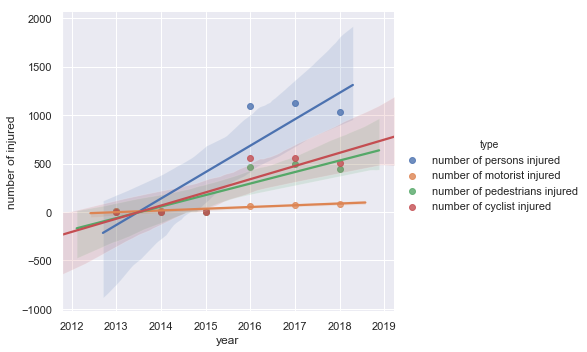

In [10]:
Plot_Injuries_vs_Year(df_ksi, col=None, hue=None, injured_killed='injured')

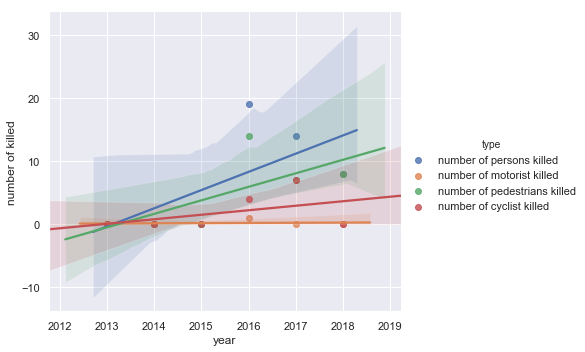

In [11]:
Plot_Injuries_vs_Year(df_ksi, col=None, hue=None, injured_killed='killed')

In [12]:
a = pivot_table(df_ksi, injured_killed= 'injured', index = 'year')
a.sort_values(by = 'year', ascending = False)

number of cyclist injured  number of motorist injured  \
year                                                          
2019                        311                          55   
2018                        508                          87   
2017                        555                          71   
2016                        558                          67   
2015                          0                          12   
2014                          0                          13   
2013                          1                           8   
2012                          0                           7   

      number of pedestrians injured  number of persons injured  
year                                                            
2019                            234                      600.0  
2018                            440                     1036.0  
2017                            498                     1124.0  
2016                            465                     1090.0  
2015                              0                       12.0  
2014                              1                       14.0  
2013                              0                        9.0  
2012                              0                        7.0

In [13]:
a = pivot_table(df_ksi, injured_killed= 'killed', index = 'year')
a.sort_values(by = 'year', ascending = False)

number of cyclist killed  number of motorist killed  \
year                                                        
2019                         1                          0   
2018                         0                          0   
2017                         7                          0   
2016                         4                          1   
2015                         0                          0   
2014                         0                          0   
2013                         0                          0   
2012                         0                          0   

      number of pedestrians killed  number of persons killed  
year                                                          
2019                             4                       5.0  
2018                             8                       8.0  
2017                             7                      14.0  
2016                            14                      19.0  
2015                             0                       0.0  
2014                             0                       0.0  
2013                             0                       0.0  
2012                             0                       0.0

In [14]:
pivot_table(df_ksi, injured_killed= 'injured', index = 'road_type')

number of cyclist injured  number of motorist injured  \
road_type                                                           
avenue                            812                         142   
street                            693                          98   
others                            204                          44   
road                               66                          13   
N/A                                66                           8   
parkway                            35                           8   
drive                              34                           6   
bridge                             17                           0   
expressway                          6                           1   

            number of pedestrians injured  number of persons injured  
road_type                                                             
avenue                                728                     1681.0  
street                                570                     1363.0  
others                                169                      417.0  
road                                   80                      159.0  
N/A                                    34                      108.0  
parkway                                25                       68.0  
drive                                  20                       60.0  
bridge                                  7                       24.0  
expressway                              5                       12.0

In [15]:
pivot_table(df_ksi, injured_killed= 'killed', index = 'road_type')

number of cyclist killed  number of motorist killed  \
road_type                                                         
avenue                             6                          0   
others                             4                          1   
street                             1                          0   
expressway                         0                          0   
parkway                            1                          0   
road                               0                          0   
N/A                                0                          0   
bridge                             0                          0   
drive                              0                          0   

            number of pedestrians killed  number of persons killed  
road_type                                                           
avenue                                12                      18.0  
others                                 6                      11.0  
street                                 5                       6.0  
expressway                             5                       5.0  
parkway                                3                       4.0  
road                                   2                       2.0  
N/A                                    0                       0.0  
bridge                                 0                       0.0  
drive                                  0                       0.0

In [16]:
pivot_table(df_ksi.loc[df_ksi['road_type'] == 'others'], injured_killed= 'injured', index = 'borough')

number of cyclist injured  number of motorist injured  \
borough                                                                
QUEENS                                67                          11   
MANHATTAN                             50                          10   
BRONX                                 32                          11   
BROOKLYN                              44                           5   
N/A                                    7                           6   
STATEN ISLAND                          4                           1   

               number of pedestrians injured  number of persons injured  
borough                                                                  
QUEENS                                    48                      126.0  
MANHATTAN                                 31                       91.0  
BRONX                                     43                       86.0  
BROOKLYN                                  30                       79.0  
N/A                                        6                       19.0  
STATEN ISLAND                             11                       16.0

In [17]:
pivot_table(df_ksi.loc[df_ksi['road_type'] == 'avenue'], injured_killed= 'killed', index = 'borough')

number of cyclist killed  number of motorist killed  \
borough                                                              
MANHATTAN                             2                          0   
BROOKLYN                              4                          0   
QUEENS                                0                          0   
BRONX                                 0                          0   
STATEN ISLAND                         0                          0   
N/A                                   0                          0   

               number of pedestrians killed  number of persons killed  
borough                                                                
MANHATTAN                                 4                       6.0  
BROOKLYN                                  0                       4.0  
QUEENS                                    4                       4.0  
BRONX                                     3                       3.0  
STATEN ISLAND                             1                       1.0  
N/A                                       0                       0.0

In [18]:
pivot_table(df_ksi.loc[df_ksi['road_type'] == 'avenue'], injured_killed= 'injured', index = 'borough')

number of cyclist injured  number of motorist injured  \
borough                                                                
BROOKLYN                             373                          66   
BRONX                                131                          46   
MANHATTAN                            168                          13   
QUEENS                               105                          11   
STATEN ISLAND                         19                           4   
N/A                                   16                           2   

               number of pedestrians injured  number of persons injured  
borough                                                                  
BROOKLYN                                 286                      725.0  
BRONX                                    191                      368.0  
MANHATTAN                                151                      332.0  
QUEENS                                    64                      179.0  
STATEN ISLAND                             23                       46.0  
N/A                                       13                       31.0

In [19]:
pivot_table(df_ksi.loc[df_ksi['road_type'] == 'avenue'], injured_killed= 'killed', index = 'borough')

number of cyclist killed  number of motorist killed  \
borough                                                              
MANHATTAN                             2                          0   
BROOKLYN                              4                          0   
QUEENS                                0                          0   
BRONX                                 0                          0   
STATEN ISLAND                         0                          0   
N/A                                   0                          0   

               number of pedestrians killed  number of persons killed  
borough                                                                
MANHATTAN                                 4                       6.0  
BROOKLYN                                  0                       4.0  
QUEENS                                    4                       4.0  
BRONX                                     3                       3.0  
STATEN ISLAND                             1                       1.0  
N/A                                       0                       0.0

In [20]:
pivot_table(df_ksi.loc[df_ksi['road_type'] == 'street'], injured_killed= 'injured', index = 'borough')

number of cyclist injured  number of motorist injured  \
borough                                                                
MANHATTAN                            292                          43   
BROOKLYN                             189                          25   
QUEENS                               129                           9   
BRONX                                 66                          19   
N/A                                   11                           2   
STATEN ISLAND                          6                           0   

               number of pedestrians injured  number of persons injured  
borough                                                                  
MANHATTAN                                251                      588.0  
BROOKLYN                                 134                      348.0  
QUEENS                                    70                      208.0  
BRONX                                     94                      179.0  
N/A                                       11                       24.0  
STATEN ISLAND                             10                       16.0

In [21]:
pivot_table(df_ksi.loc[df_ksi['road_type'] == 'street'], injured_killed= 'killed', index = 'borough')

number of cyclist killed  number of motorist killed  \
borough                                                              
BROOKLYN                              0                          0   
MANHATTAN                             0                          0   
QUEENS                                1                          0   
BRONX                                 0                          0   
N/A                                   0                          0   
STATEN ISLAND                         0                          0   

               number of pedestrians killed  number of persons killed  
borough                                                                
BROOKLYN                                  2                       2.0  
MANHATTAN                                 2                       2.0  
QUEENS                                    1                       2.0  
BRONX                                     0                       0.0  
N/A                                       0                       0.0  
STATEN ISLAND                             0                       0.0

In [22]:
a = count_by_year_borough(df_ksi, col1='year',col2= 'borough',injured_killed= 'injured')
a.sort_values(by = 'number of persons injured', ascending = False)

number of persons injured  number of pedestrians injured  \
year borough                                                                   
2017 BROOKLYN                           368.0                            158   
2016 BROOKLYN                           357.0                            139   
2018 BROOKLYN                           333.0                            124   
2016 MANHATTAN                          316.0                            138   
2017 MANHATTAN                          309.0                            137   
2018 MANHATTAN                          265.0                            114   
     BRONX                              217.0                            111   
2017 BRONX                              212.0                            115   
2019 MANHATTAN                          180.0                             64   
2016 BRONX                              179.0                             97   
2019 BROOKLYN                           173.0                             65   
2017 QUEENS                             155.0                             53   
2018 QUEENS                             154.0                             63   
2016 QUEENS                             151.0                             56   
2019 BRONX                              109.0                             59   
     QUEENS                              85.0                             26   
2016 N/A                                 65.0                             22   
2017 N/A                                 55.0                             22   
2018 N/A                                 41.0                             14   
2019 N/A                                 37.0                             10   
2018 STATEN ISLAND                       26.0                             14   
2017 STATEN ISLAND                       25.0                             13   
2016 STATEN ISLAND                       22.0                             13   
2019 STATEN ISLAND                       16.0                             10   
2014 BROOKLYN                             5.0                              0   
2015 MANHATTAN                            5.0                              0   
2013 BRONX                                5.0                              0   
2012 BROOKLYN                             4.0                              0   
2015 N/A                                  4.0                              0   
2014 MANHATTAN                            3.0                              0   
     QUEENS                               2.0                              0   
     BRONX                                2.0                              0   
2013 MANHATTAN                            2.0                              0   
     N/A                                  1.0                              0   
2012 MANHATTAN                            1.0                              0   
     QUEENS                               1.0                              0   
2015 QUEENS                               1.0                              0   
2013 BROOKLYN                             1.0                              0   
2012 BRONX                                1.0                              0   
2015 BROOKLYN                             1.0                              0   
2014 N/A                                  1.0                              0   
     STATEN ISLAND                        1.0                              1   
2015 BRONX                                1.0                              0   
2013 QUEENS                               0.0                              0   
2015 STATEN ISLAND                        0.0                              0   
2012 STATEN ISLAND                        0.0                              0   
2013 STATEN ISLAND                        0.0                              0   

                    number of cyclist injured  number of motorist injured  
year borough           

In [23]:
count_by_year_borough(df_ksi, col1='year',col2= 'road_type',injured_killed= 'injured')

number of persons injured  number of pedestrians injured  \
year road_type                                                              
2012 avenue                            4.0                              0   
     others                            1.0                              0   
     road                              1.0                              0   
     street                            1.0                              0   
2013 N/A                               1.0                              0   
     avenue                            4.0                              0   
     others                            1.0                              0   
     parkway                           0.0                              0   
     road                              0.0                              0   
     street                            3.0                              0   
2014 N/A                               0.0                              0   
     avenue                            8.0                              0   
     drive                             0.0                              0   
     others                            2.0                              0   
     parkway                           0.0                              0   
     road                              0.0                              0   
     street                            4.0                              1   
2015 N/A                               3.0                              0   
     avenue                            2.0                              0   
     expressway                        1.0                              0   
     others                            0.0                              0   
     parkway                           0.0                              0   
     road                              0.0                              0   
     street                            6.0                              0   
2016 N/A                              30.0                             12   
     avenue                          464.0                            208   
     bridge                           11.0                              4   
     drive                            21.0                              3   
     expressway                        3.0                              0   
     others                          118.0                             46   
     parkway                          22.0                              9   
     road                             41.0                             19   
     street                          380.0                            164   
2017 N/A                              34.0                             11   
     avenue                          480.0                            229   
     bridge                            9.0                              3   
     drive                             8.0                              5   
     expressway                        2.0                              1   
     others                          120.0                             54   
     parkway                          17.0                              5   
     road                             36.0                             14   
     street                          418.0                            176   
2018 N/A                              20.0                              7   
     avenue                          452.0                            189   
     bridge                            2.0                              0   
     drive                            19.0                              6   
     expressway                        4.0                              3   
     others                          112.0                             44   
     parkway                          21.0                              9   
     road                             58.0                             36   
     street  

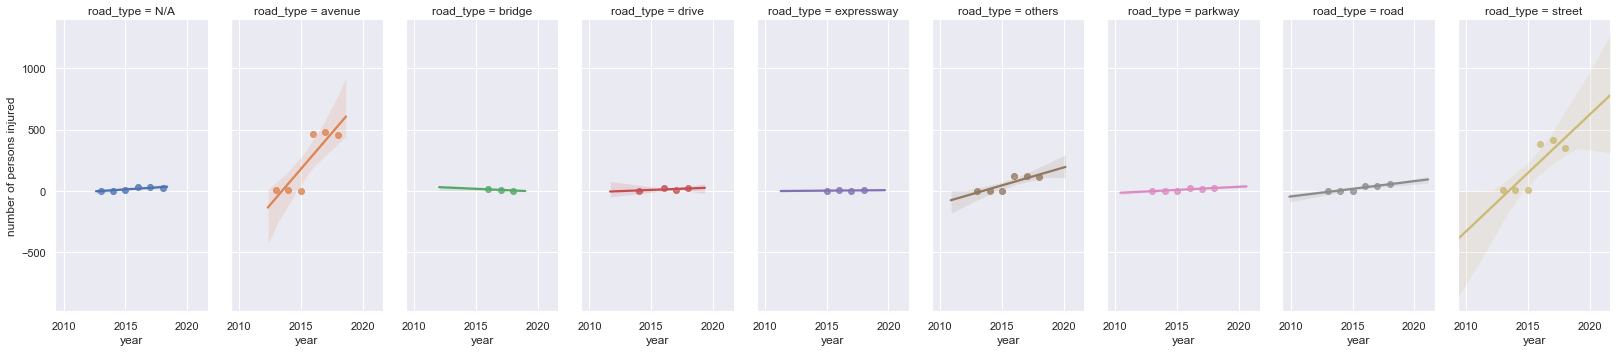

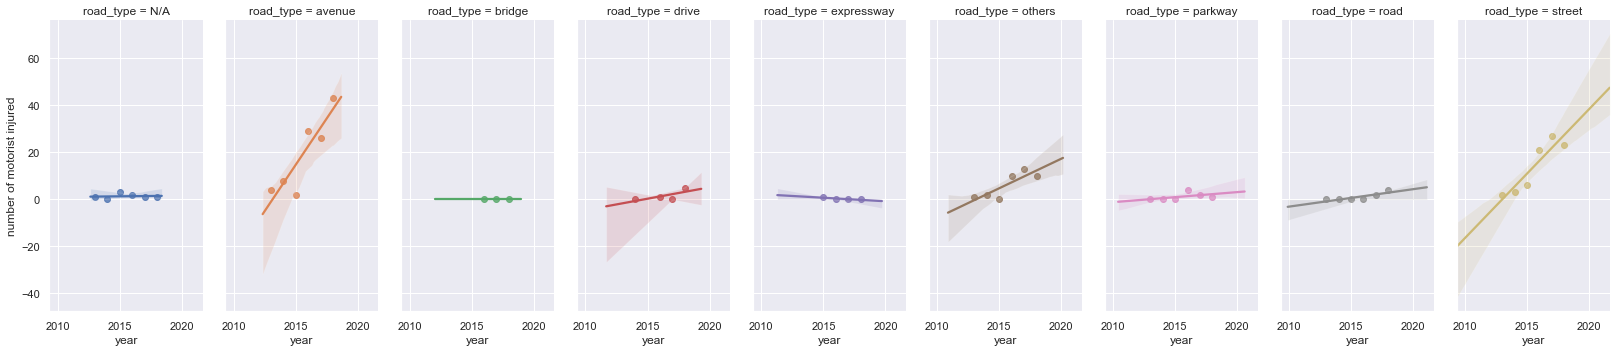

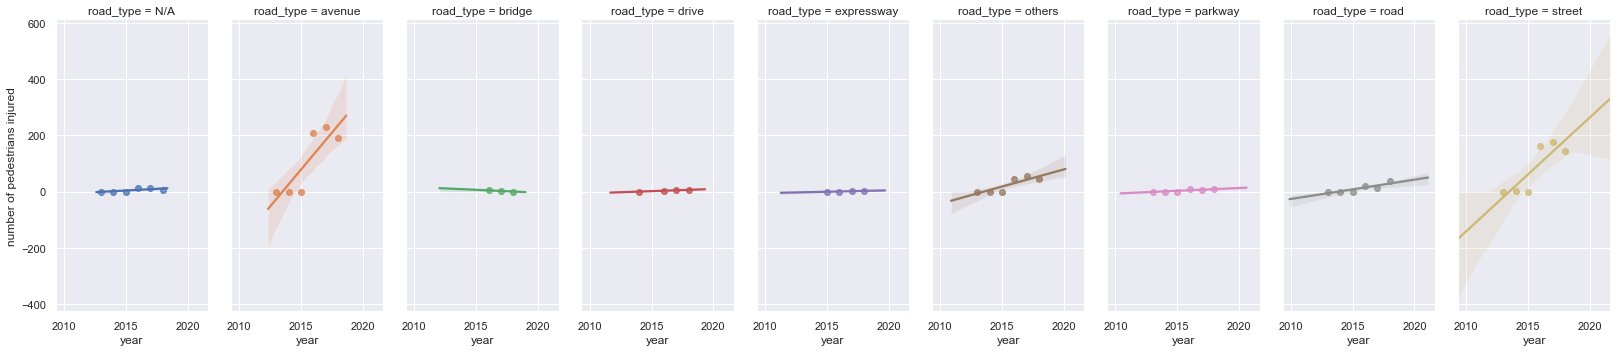

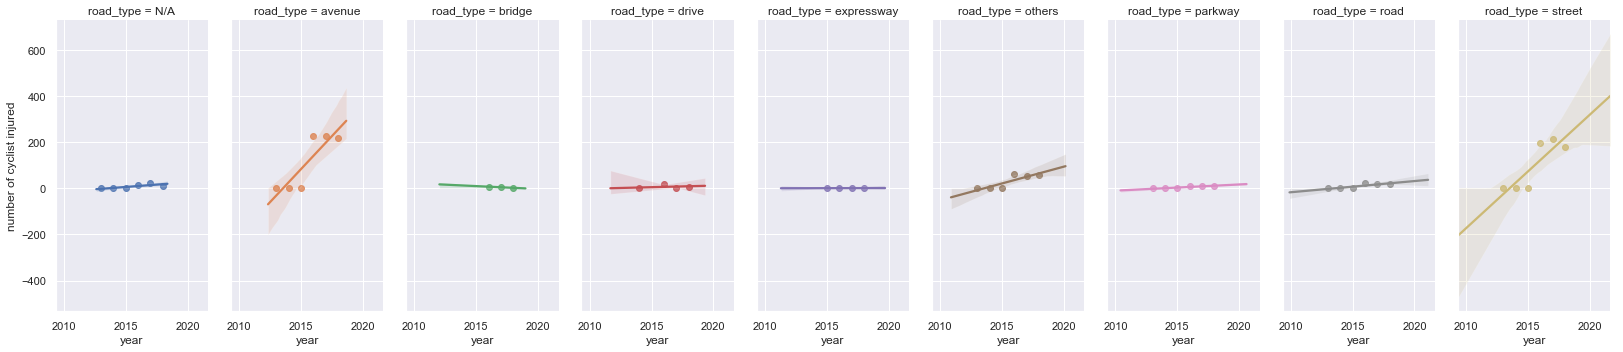

In [24]:
Plot_Injuries_vs_Year(df_ksi, col='road_type', hue='road_type', injured_killed='injured')

In [25]:
count_by_year_borough(df_ksi, injured_killed= 'injured')

number of pedestrians injured  number of cyclist injured  \
year borough                                                                   
2012 BRONX                                      0                          0   
     BROOKLYN                                   0                          0   
     MANHATTAN                                  0                          0   
     QUEENS                                     0                          0   
     STATEN ISLAND                              0                          0   
2013 BRONX                                      0                          0   
     BROOKLYN                                   0                          1   
     MANHATTAN                                  0                          0   
     N/A                                        0                          0   
     QUEENS                                     0                          0   
     STATEN ISLAND                              0                          0   
2014 BRONX                                      0                          0   
     BROOKLYN                                   0                          0   
     MANHATTAN                                  0                          0   
     N/A                                        0                          0   
     QUEENS                                     0                          0   
     STATEN ISLAND                              1                          0   
2015 BRONX                                      0                          0   
     BROOKLYN                                   0                          0   
     MANHATTAN                                  0                          0   
     N/A                                        0                          0   
     QUEENS                                     0                          0   
     STATEN ISLAND                              0                          0   
2016 BRONX                                     97                         68   
     BROOKLYN                                 139                        192   
     MANHATTAN                                138                        166   
     N/A                                       22                         36   
     QUEENS                                    56                         88   
     STATEN ISLAND                             13                          8   
2017 BRONX                                    115                         77   
     BROOKLYN                                 158                        190   
     MANHATTAN                                137                        151   
     N/A                                       22                         31   
     QUEENS                                    53                         96   
     STATEN ISLAND                             13                         10   
2018 BRONX                                    111                         79   
     BROOKLYN                                 124                        177   
     MANHATTAN                                114                        136   
     N/A                                       14                         27   
     QUEENS                                    63                         79   
     STATEN ISLAND                             14                         10   
2019 BRONX                                     59                         33   
     BROOKLYN                                  65                         92   
     MANHATTAN                                 64                        101   
     N/A                                       10                         26   
     QUEENS                                    26                         54   
     STATEN ISLAND                             10                          5   

                    number of motorist injured  
year borough                                    
2

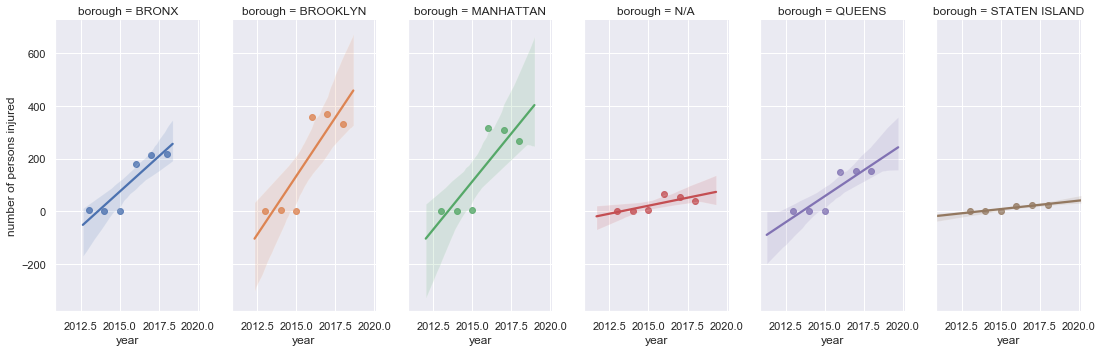

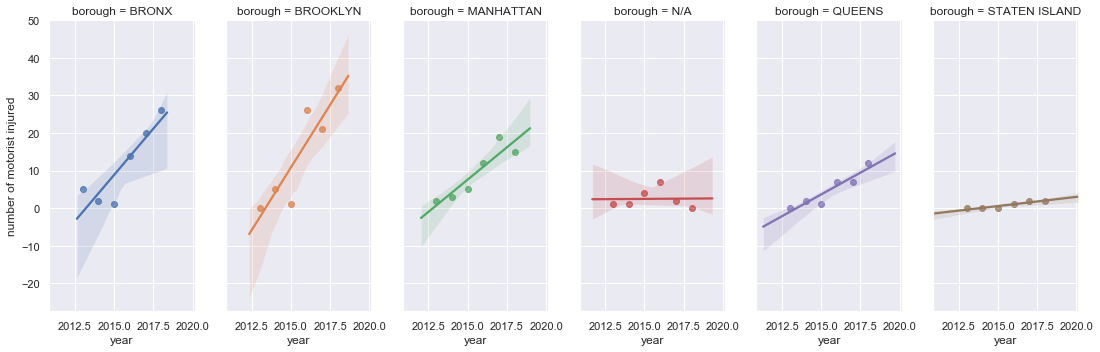

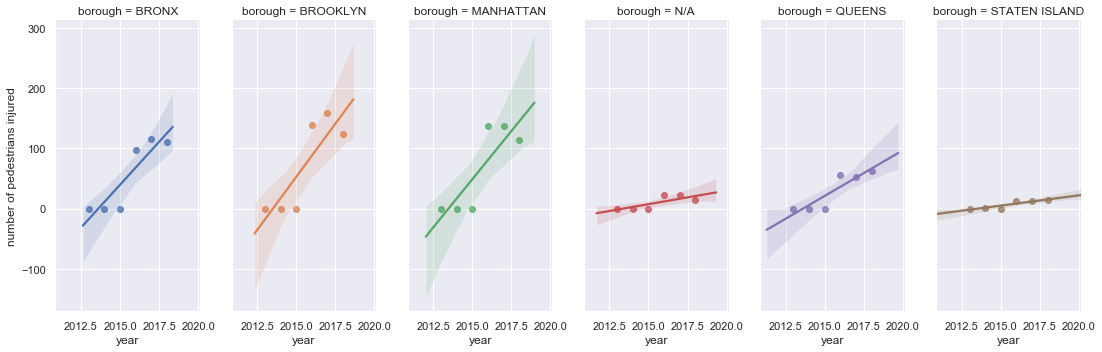

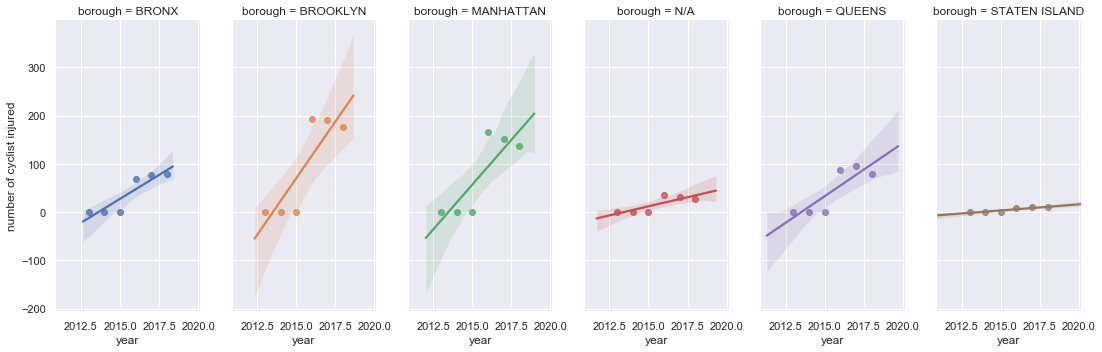

In [26]:
Plot_Injuries_vs_Year(df_ksi, col='borough', hue='borough', injured_killed='injured')

In [27]:
count_by_year_borough(df_ksi, col1 = 'year', col2= 'road_type', injured_killed= 'killed')

number of persons killed  number of pedestrians killed  \
year road_type                                                            
2012 avenue                           0.0                             0   
     others                           0.0                             0   
     road                             0.0                             0   
     street                           0.0                             0   
2013 N/A                              0.0                             0   
     avenue                           0.0                             0   
     others                           0.0                             0   
     parkway                          0.0                             0   
     road                             0.0                             0   
     street                           0.0                             0   
2014 N/A                              0.0                             0   
     avenue                           0.0                             0   
     drive                            0.0                             0   
     others                           0.0                             0   
     parkway                          0.0                             0   
     road                             0.0                             0   
     street                           0.0                             0   
2015 N/A                              0.0                             0   
     avenue                           0.0                             0   
     expressway                       0.0                             0   
     others                           0.0                             0   
     parkway                          0.0                             0   
     road                             0.0                             0   
     street                           0.0                             0   
2016 N/A                              0.0                             0   
     avenue                           4.0                             4   
     bridge                           0.0                             0   
     drive                            0.0                             0   
     expressway                       3.0                             3   
     others                           9.0                             5   
     parkway                          2.0                             1   
     road                             0.0                             0   
     street                           1.0                             1   
2017 N/A                              0.0                             0   
     avenue                           5.0                             0   
     bridge                           0.0                             0   
     drive                            0.0                             0   
     expressway                       1.0                             1   
     others                           1.0                             0   
     parkway                          1.0                             1   
     road                             2.0                             2   
     street                           4.0                             3   
2018 N/A                              0.0                             0   
     avenue                           5.0                             5   
     bridge                           0.0                             0   
     drive                            0.0                             0   
     expressway                       1.0                             1   
     others                           1.0                             1   
     parkway                          0.0                             0   
     road                             0.0                             0   
     street                           1.0                             1   
2019 N/A                              0.0 

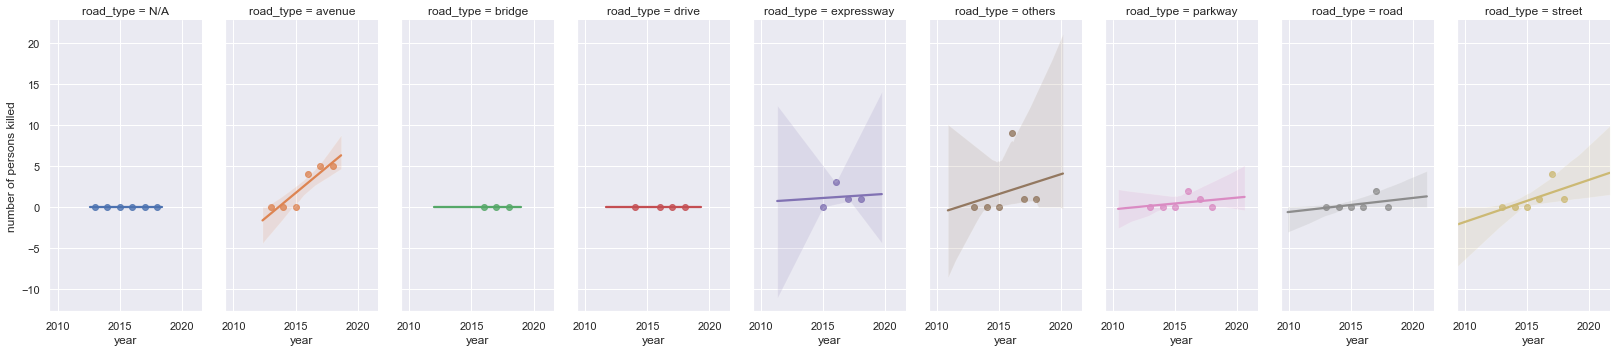

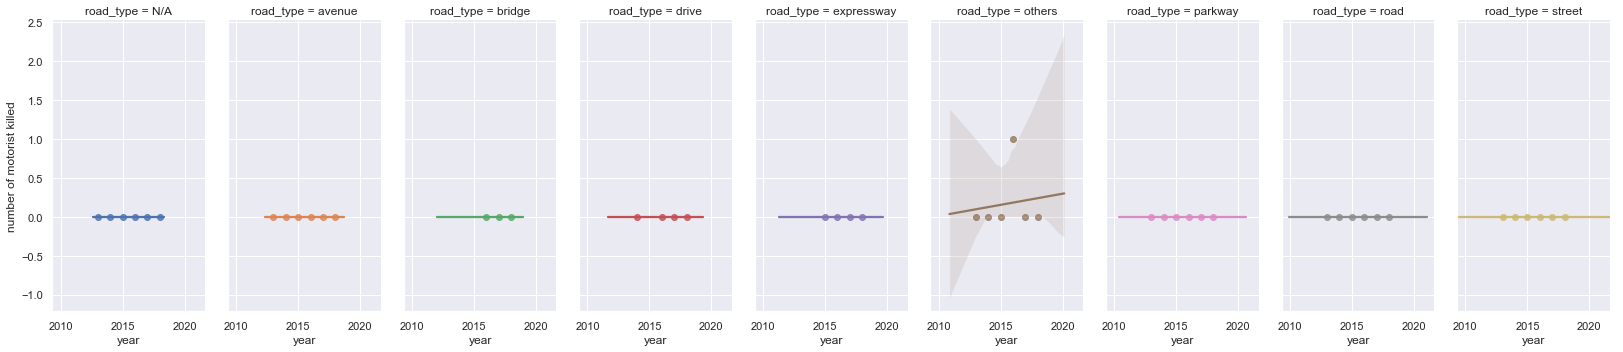

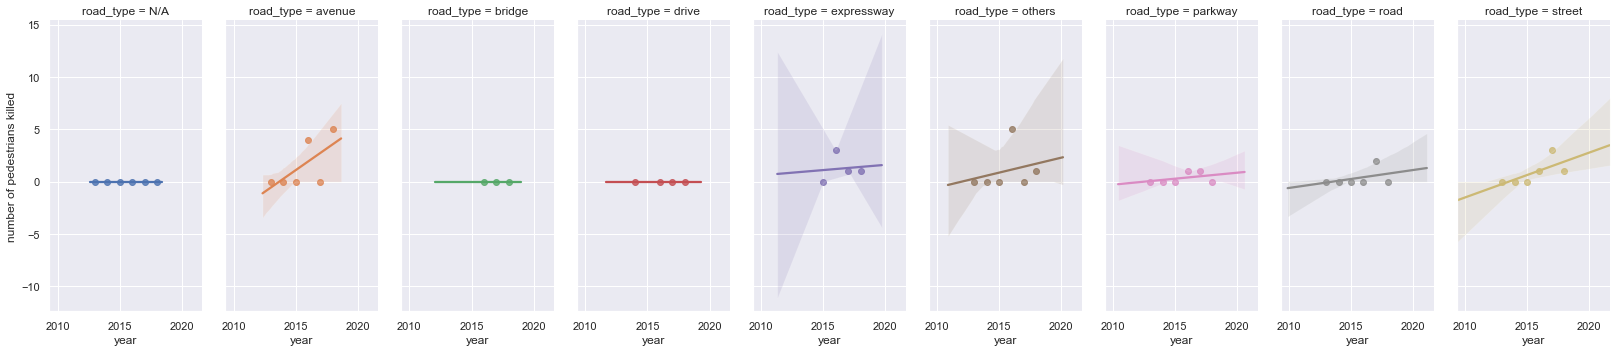

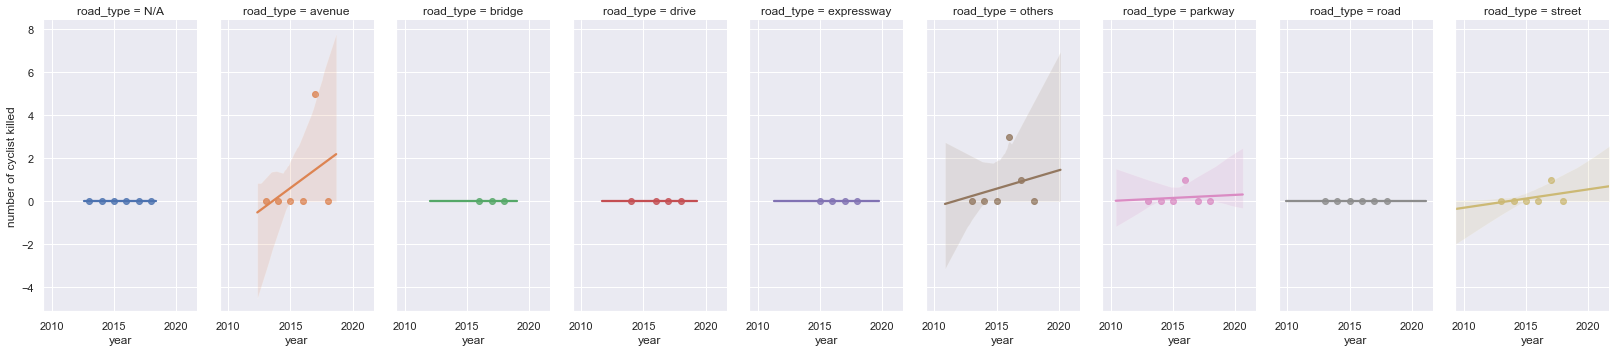

In [28]:
Plot_Injuries_vs_Year(df_ksi, col='road_type', hue='road_type', injured_killed='killed')

In [29]:
count_by_year_borough(df_ksi, injured_killed= 'killed')

number of pedestrians killed  number of cyclist killed  \
year borough                                                                 
2012 BRONX                                     0                         0   
     BROOKLYN                                  0                         0   
     MANHATTAN                                 0                         0   
     QUEENS                                    0                         0   
     STATEN ISLAND                             0                         0   
2013 BRONX                                     0                         0   
     BROOKLYN                                  0                         0   
     MANHATTAN                                 0                         0   
     N/A                                       0                         0   
     QUEENS                                    0                         0   
     STATEN ISLAND                             0                         0   
2014 BRONX                                     0                         0   
     BROOKLYN                                  0                         0   
     MANHATTAN                                 0                         0   
     N/A                                       0                         0   
     QUEENS                                    0                         0   
     STATEN ISLAND                             0                         0   
2015 BRONX                                     0                         0   
     BROOKLYN                                  0                         0   
     MANHATTAN                                 0                         0   
     N/A                                       0                         0   
     QUEENS                                    0                         0   
     STATEN ISLAND                             0                         0   
2016 BRONX                                     6                         0   
     BROOKLYN                                  0                         0   
     MANHATTAN                                 2                         0   
     N/A                                       1                         0   
     QUEENS                                    4                         4   
     STATEN ISLAND                             1                         0   
2017 BRONX                                     3                         0   
     BROOKLYN                                  1                         3   
     MANHATTAN                                 1                         3   
     N/A                                       0                         0   
     QUEENS                                    1                         1   
     STATEN ISLAND                             1                         0   
2018 BRONX                                     3                         0   
     BROOKLYN                                  1                         0   
     MANHATTAN                                 2                         0   
     N/A                                       0                         0   
     QUEENS                                    2                         0   
     STATEN ISLAND                             0                         0   
2019 BRONX                                     0                         0   
     BROOKLYN                                  0                         1   
     MANHATTAN                                 1                         0   
     N/A                                       0                         0   
     QUEENS                                    2                         0   
     STATEN ISLAND                             1                         0   

                    number of motorist killed  
year borough                                   
2012 BRONX                                  0  
     BROOKLYN                               0  
     

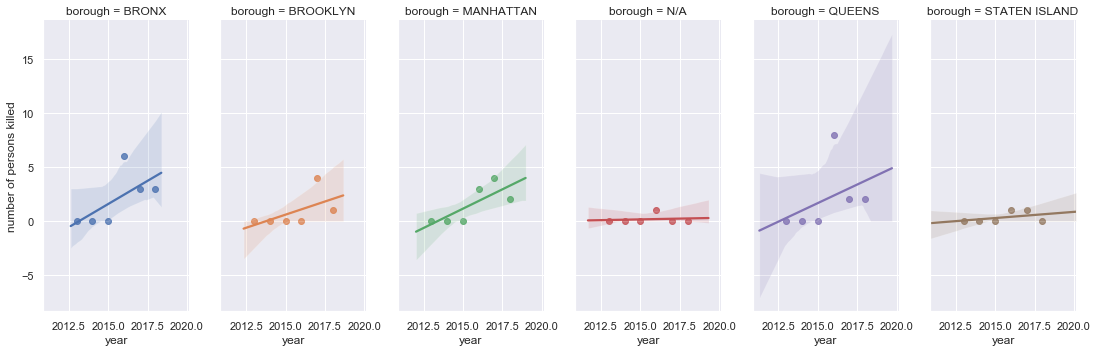

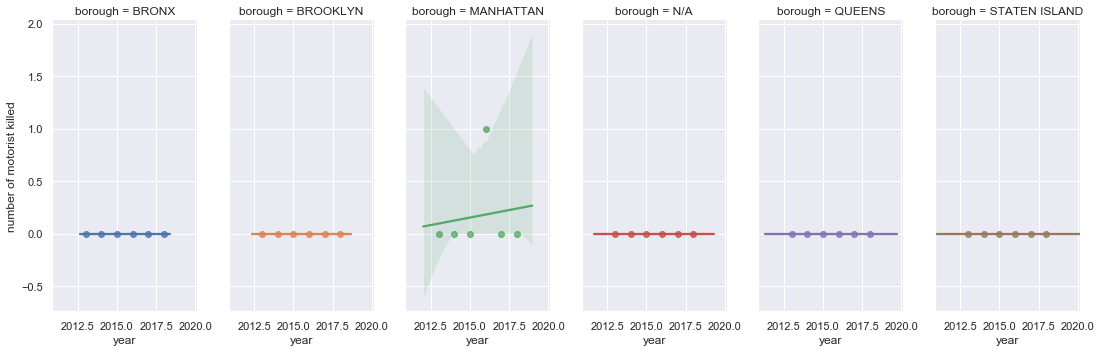

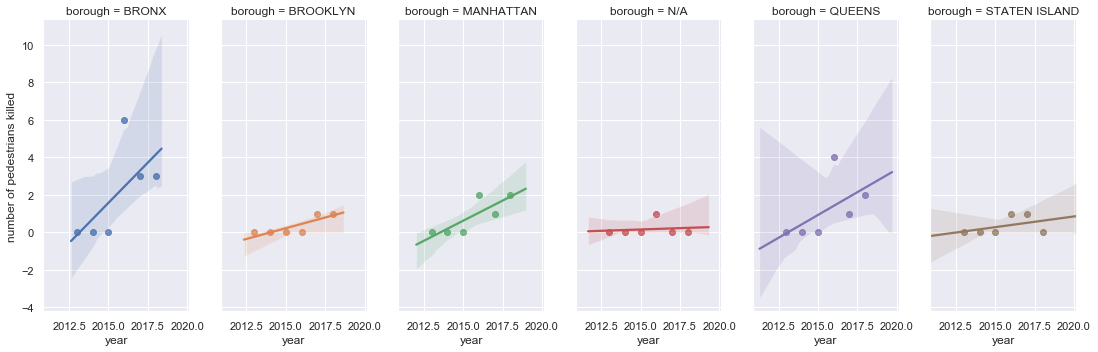

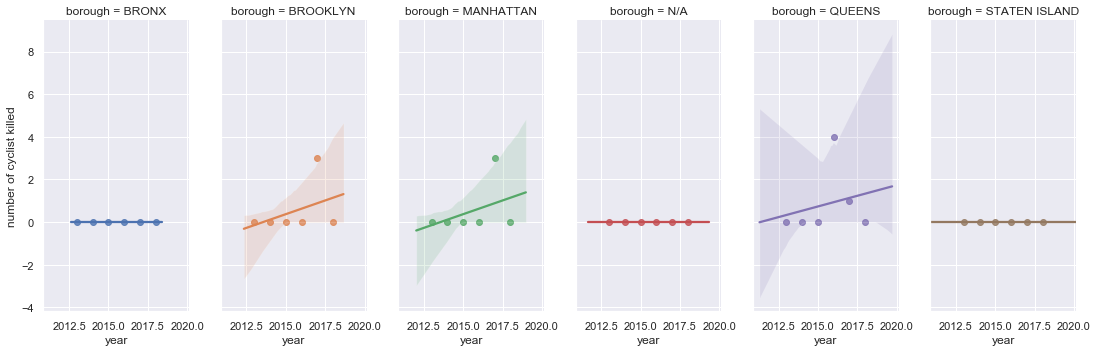

In [30]:
Plot_Injuries_vs_Year(df_ksi, col='borough', hue='borough', injured_killed='killed')

In [31]:
pivot_table(df_ksi, injured_killed= "killed", index='borough')


number of cyclist killed  number of motorist killed  \
borough                                                              
QUEENS                                5                          0   
BRONX                                 0                          0   
MANHATTAN                             3                          1   
BROOKLYN                              4                          0   
STATEN ISLAND                         0                          0   
N/A                                   0                          0   

               number of pedestrians killed  number of persons killed  
borough                                                                
QUEENS                                    9                      14.0  
BRONX                                    12                      12.0  
MANHATTAN                                 6                      10.0  
BROOKLYN                                  2                       6.0  
STATEN ISLAND                             3                       3.0  
N/A                                       1                       1.0

In [32]:
pivot_table(df_ksi, injured_killed= "injured", index='borough')


number of cyclist injured  number of motorist injured  \
borough                                                                
BROOKLYN                             652                         105   
MANHATTAN                            554                          72   
BRONX                                257                          86   
QUEENS                               317                          35   
N/A                                  120                          16   
STATEN ISLAND                         33                           6   

               number of pedestrians injured  number of persons injured  
borough                                                                  
BROOKLYN                                 486                     1242.0  
MANHATTAN                                453                     1081.0  
BRONX                                    382                      726.0  
QUEENS                                   198                      549.0  
N/A                                       68                      204.0  
STATEN ISLAND                             51                       90.0

In [33]:
pivot_table(df_ksi, injured_killed= "injured", index='road_type')


number of cyclist injured  number of motorist injured  \
road_type                                                           
avenue                            812                         142   
street                            693                          98   
others                            204                          44   
road                               66                          13   
N/A                                66                           8   
parkway                            35                           8   
drive                              34                           6   
bridge                             17                           0   
expressway                          6                           1   

            number of pedestrians injured  number of persons injured  
road_type                                                             
avenue                                728                     1681.0  
street                                570                     1363.0  
others                                169                      417.0  
road                                   80                      159.0  
N/A                                    34                      108.0  
parkway                                25                       68.0  
drive                                  20                       60.0  
bridge                                  7                       24.0  
expressway                              5                       12.0

In [34]:
pivot_table(df_ksi, injured_killed= "killed", index='road_type')


number of cyclist killed  number of motorist killed  \
road_type                                                         
avenue                             6                          0   
others                             4                          1   
street                             1                          0   
expressway                         0                          0   
parkway                            1                          0   
road                               0                          0   
N/A                                0                          0   
bridge                             0                          0   
drive                              0                          0   

            number of pedestrians killed  number of persons killed  
road_type                                                           
avenue                                12                      18.0  
others                                 6                      11.0  
street                                 5                       6.0  
expressway                             5                       5.0  
parkway                                3                       4.0  
road                                   2                       2.0  
N/A                                    0                       0.0  
bridge                                 0                       0.0  
drive                                  0                       0.0

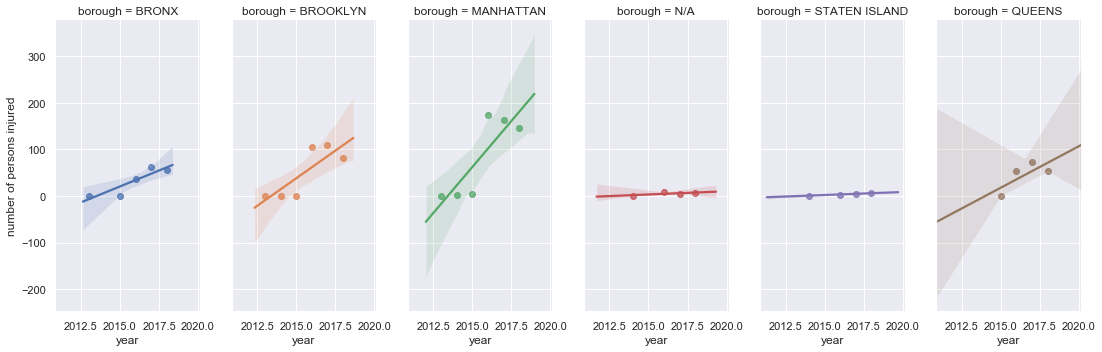

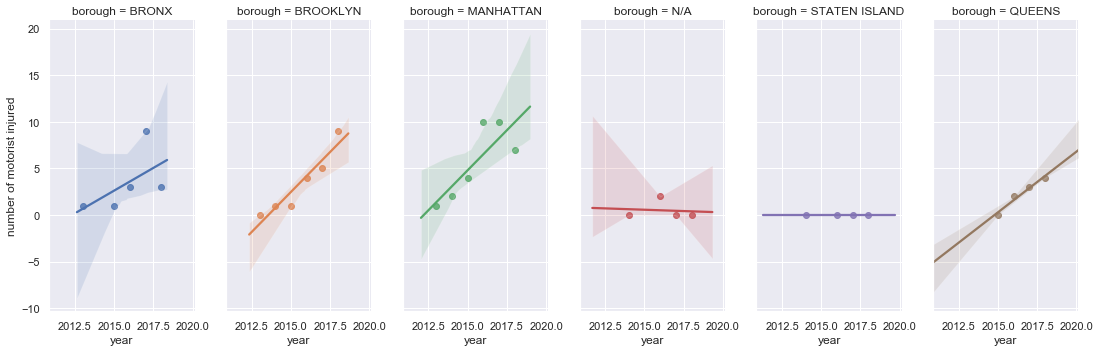

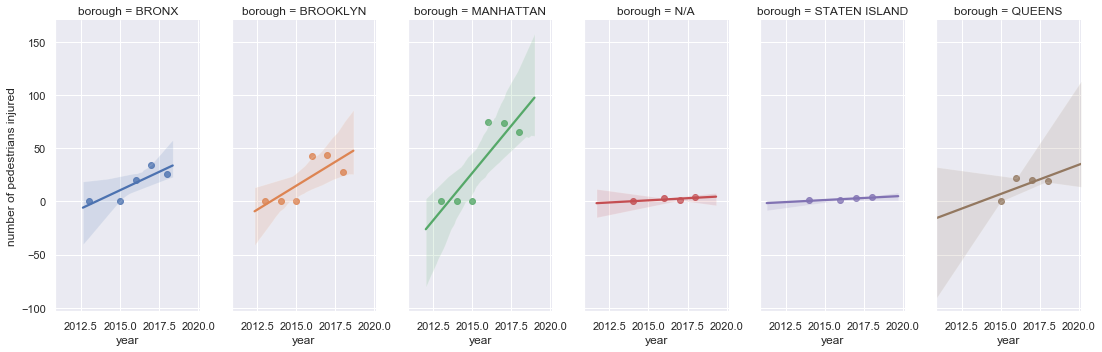

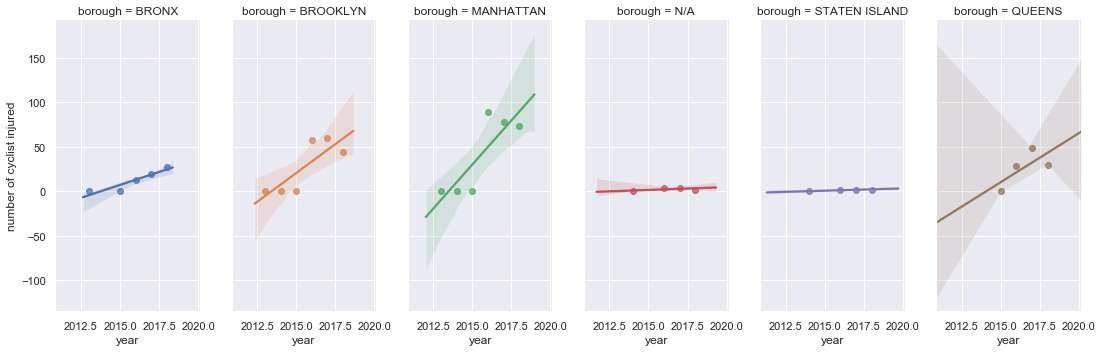

In [35]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'street'] , col='borough', hue='borough', injured_killed='injured')

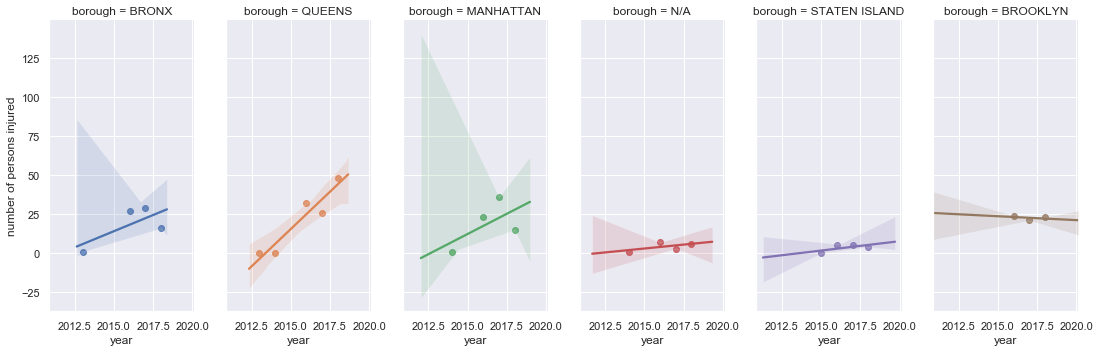

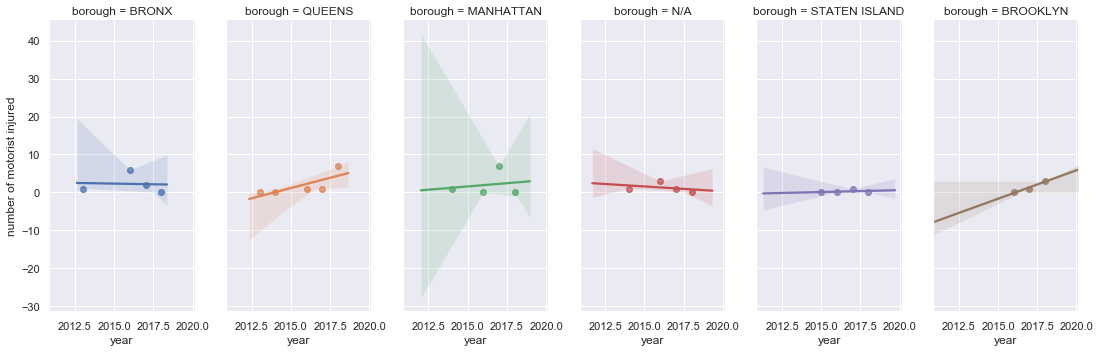

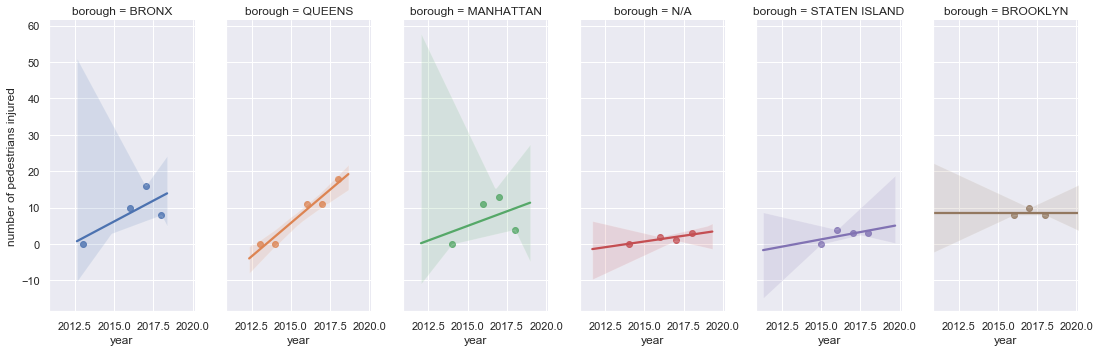

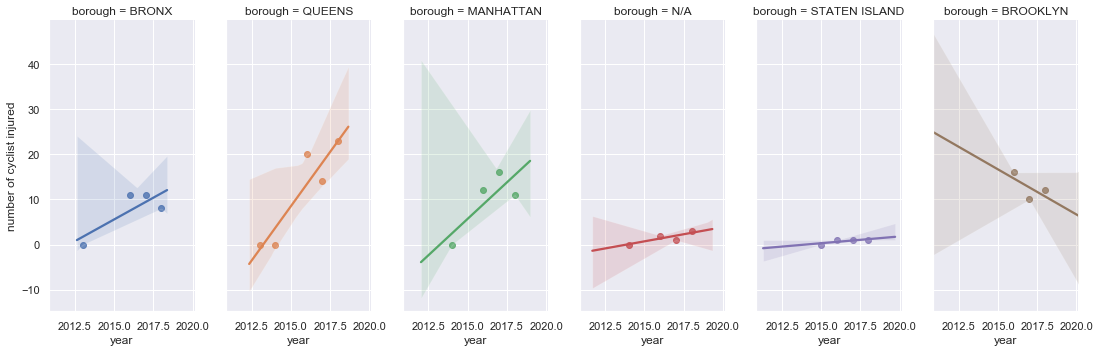

In [36]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'others'] , col='borough', hue='borough', injured_killed='injured')

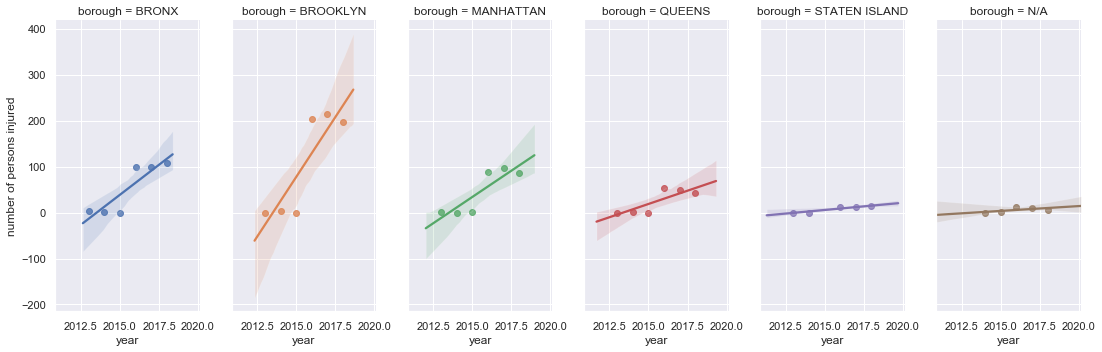

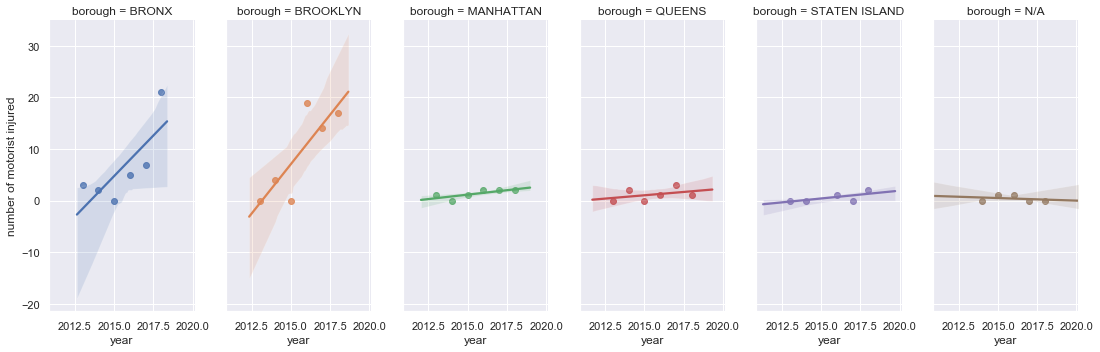

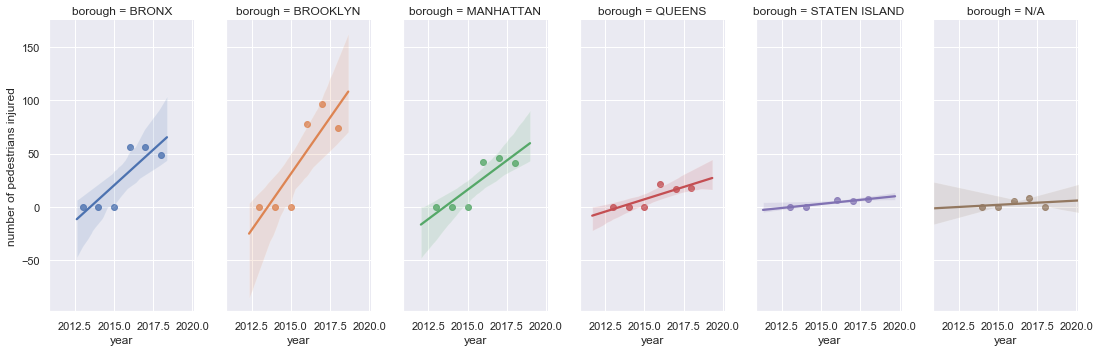

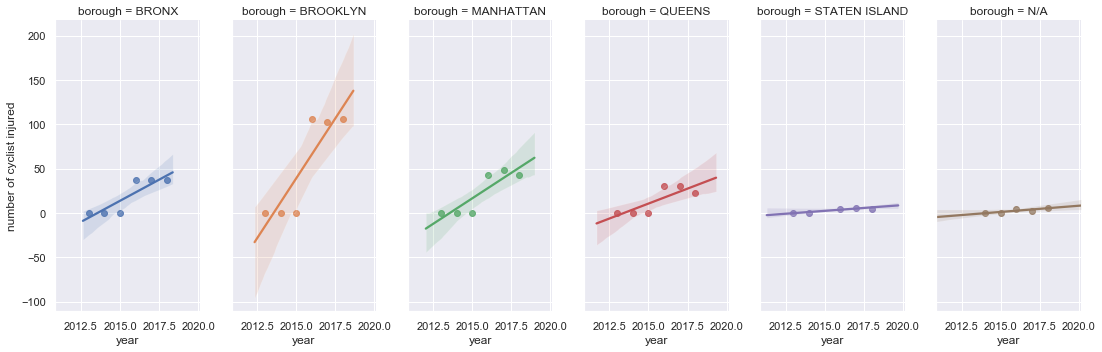

In [37]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'avenue'] , col='borough', hue='borough', injured_killed='injured')

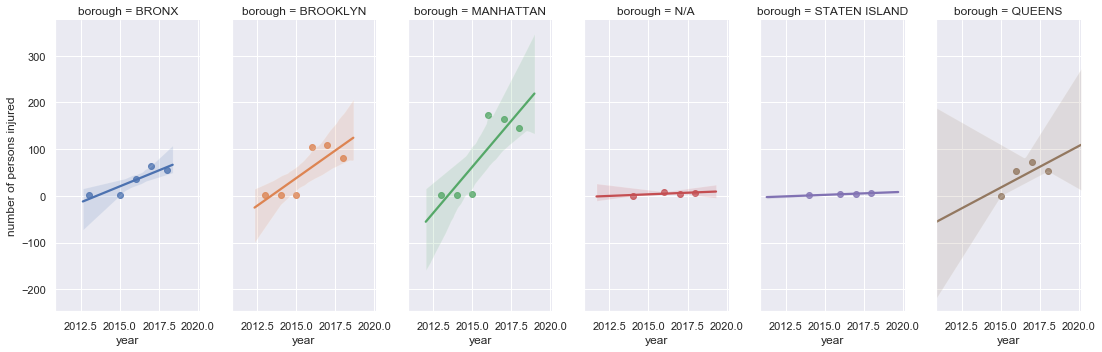

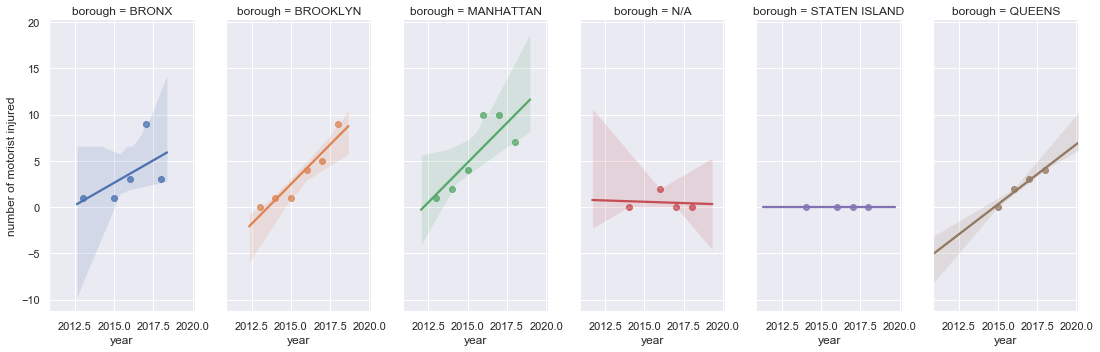

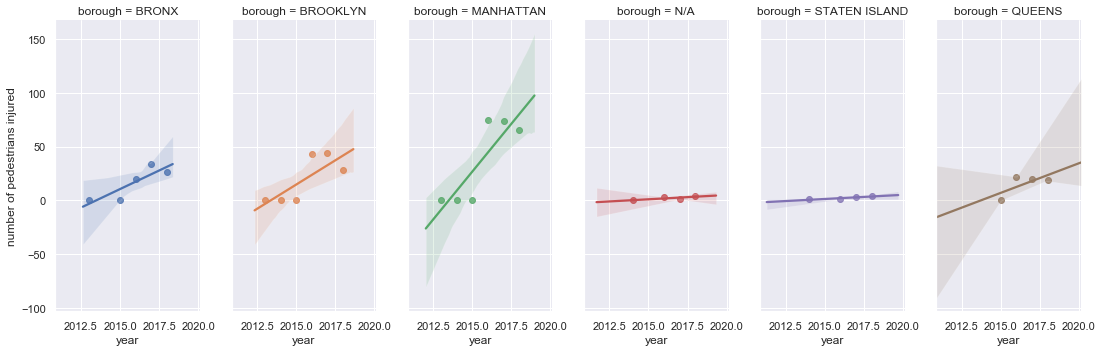

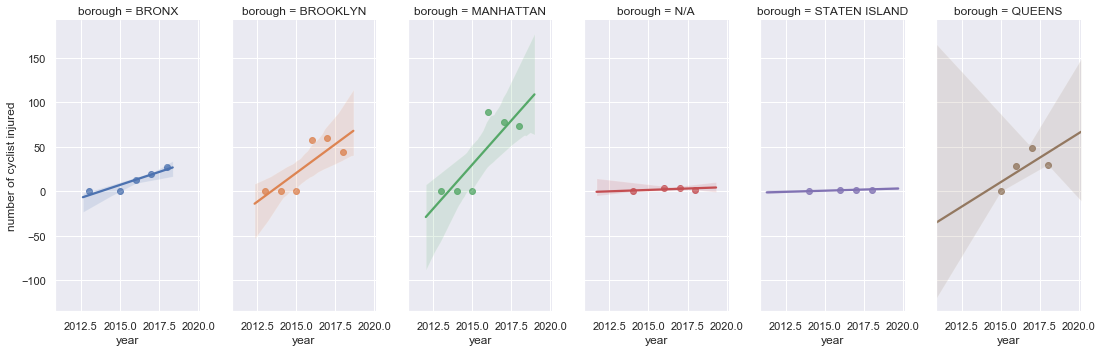

In [38]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'street'] , col='borough', hue='borough', injured_killed='injured')

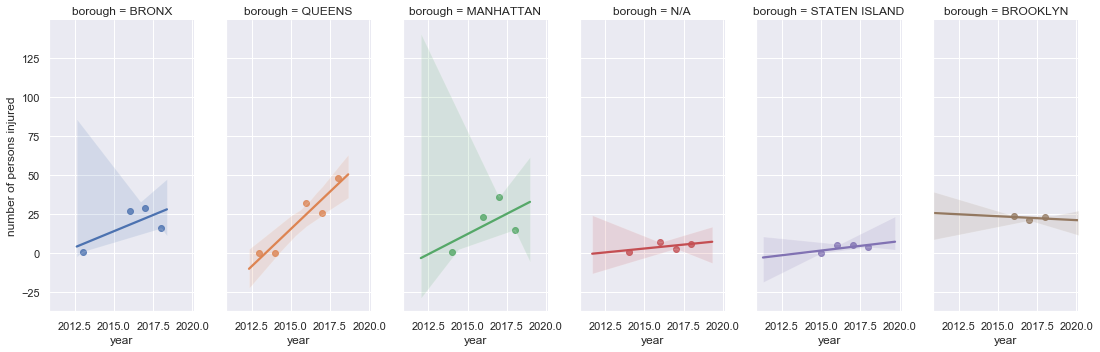

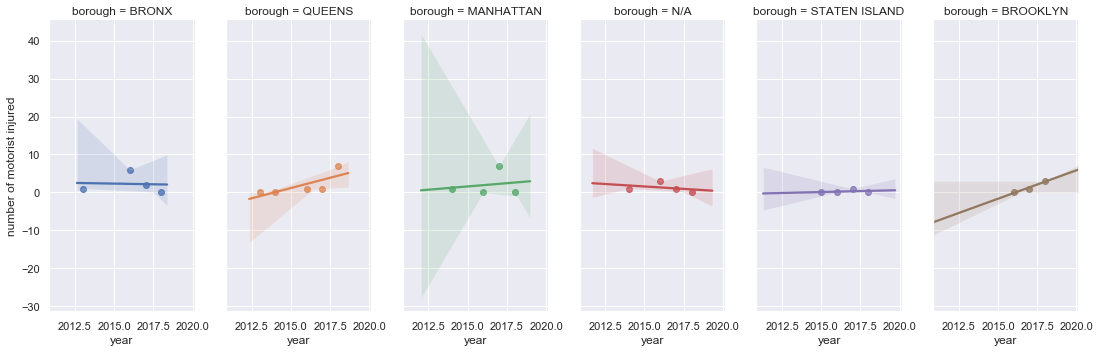

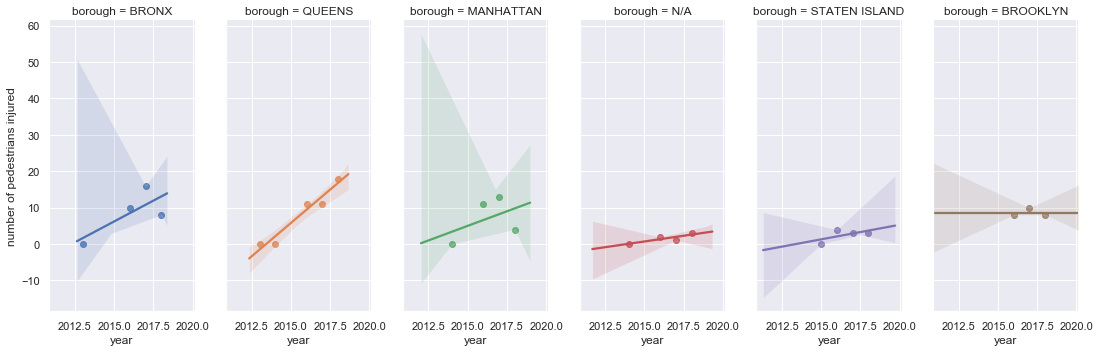

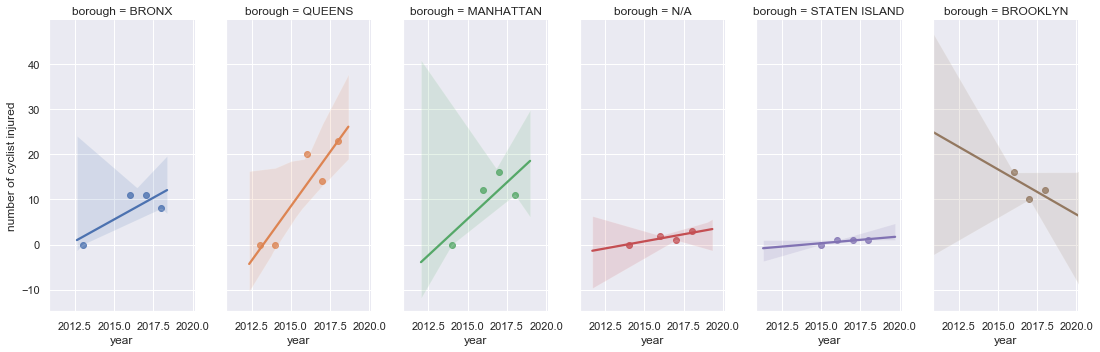

In [39]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'others'] , col='borough', hue='borough', injured_killed='injured')

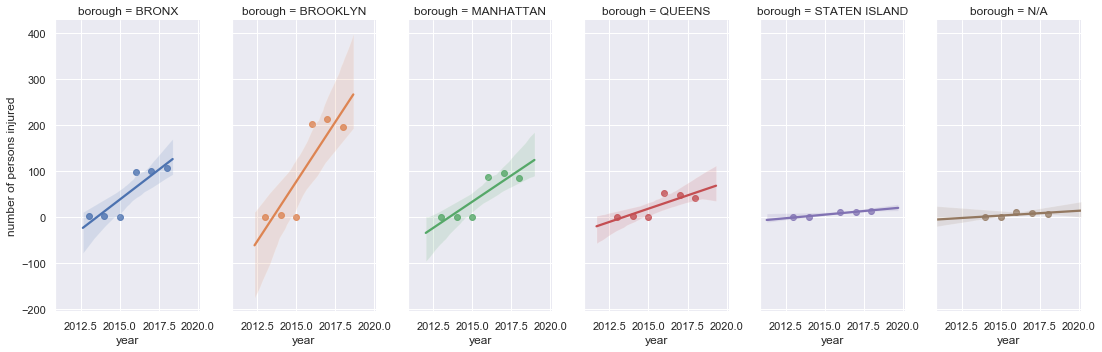

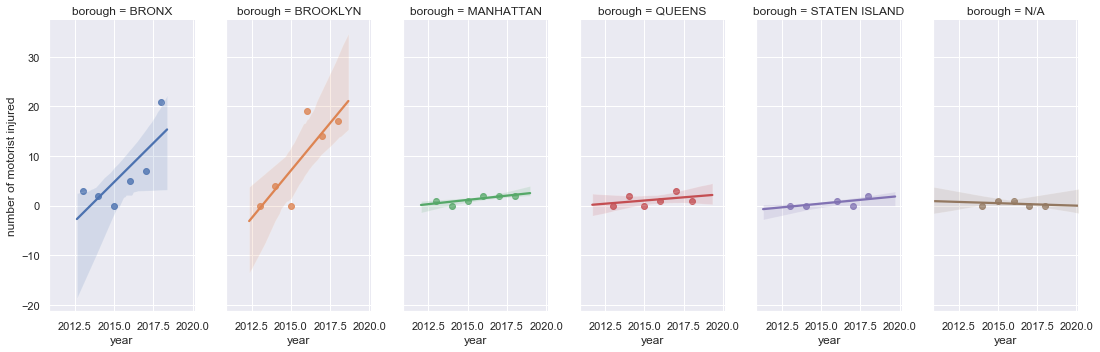

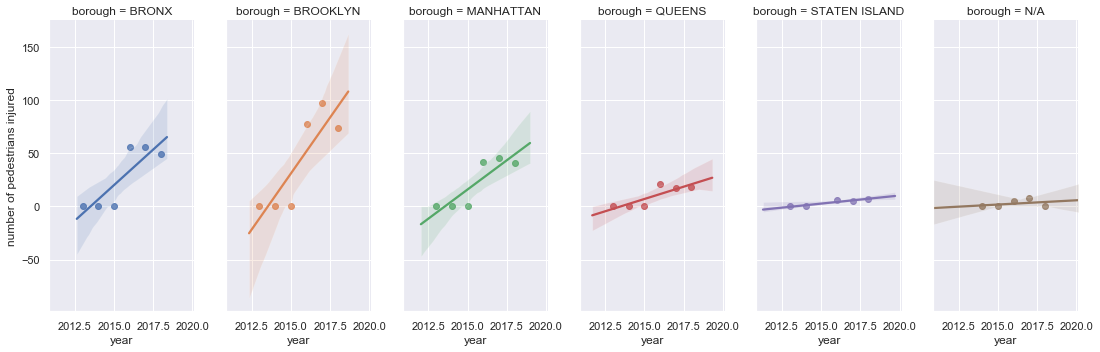

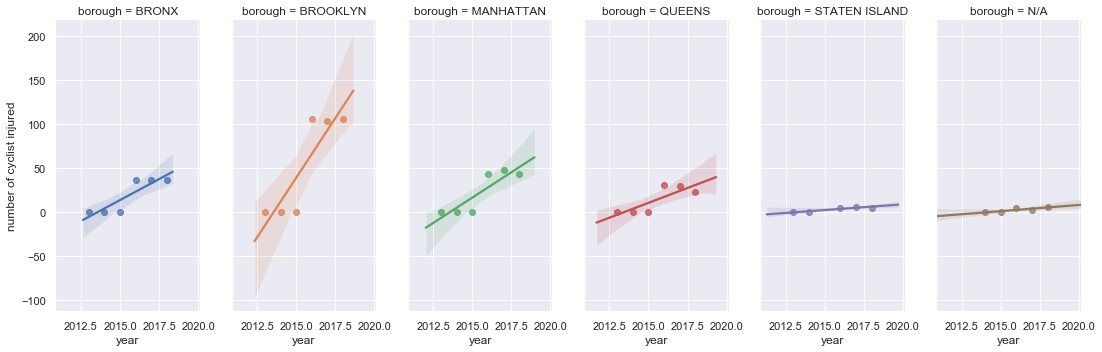

In [40]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'avenue'] , col='borough', hue='borough', injured_killed='injured')

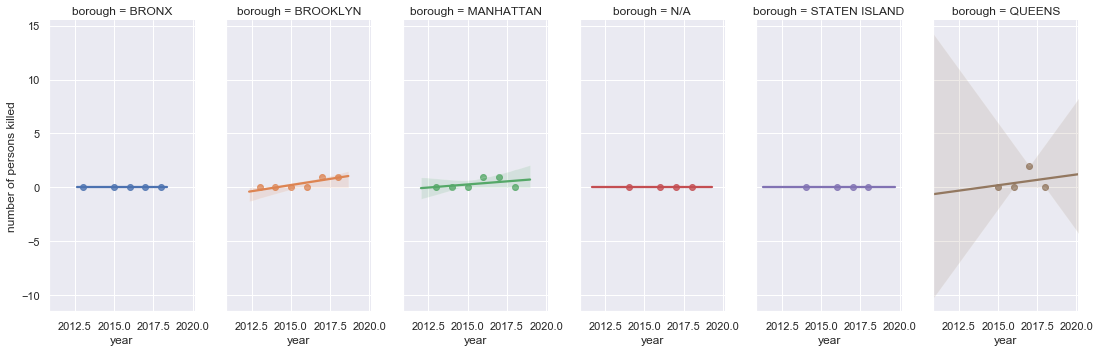

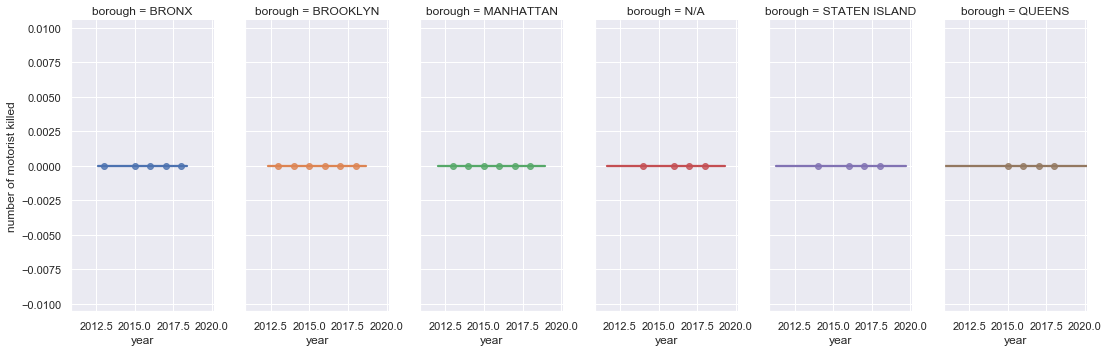

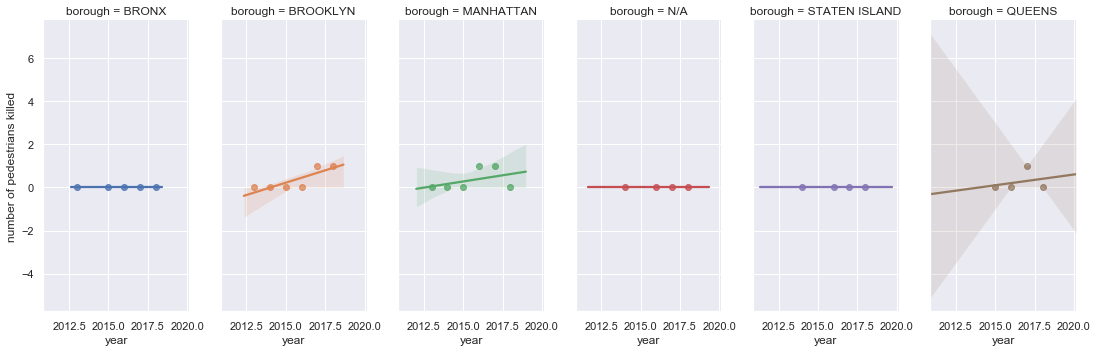

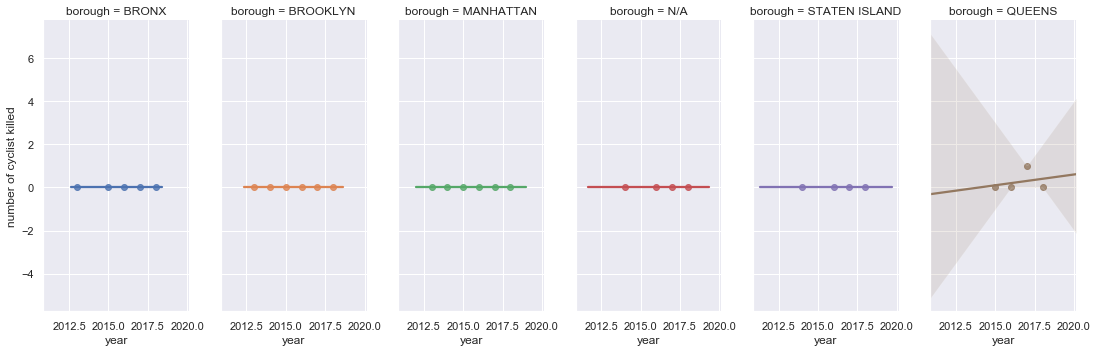

In [41]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'street'] , col='borough', hue='borough', injured_killed='killed')

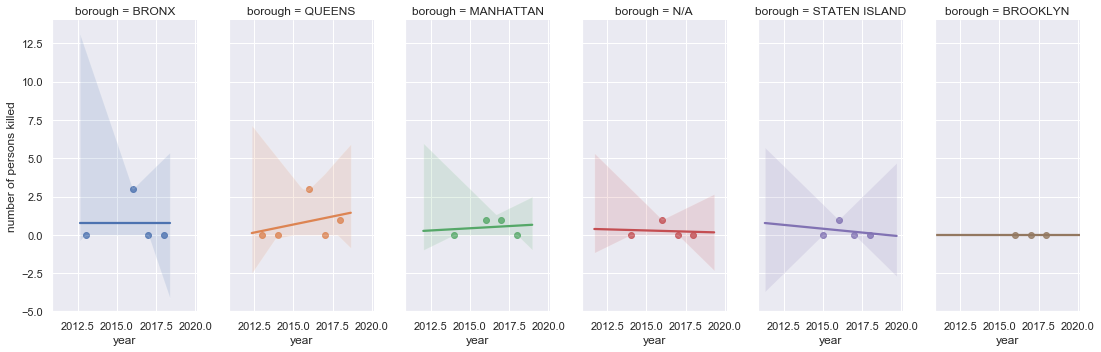

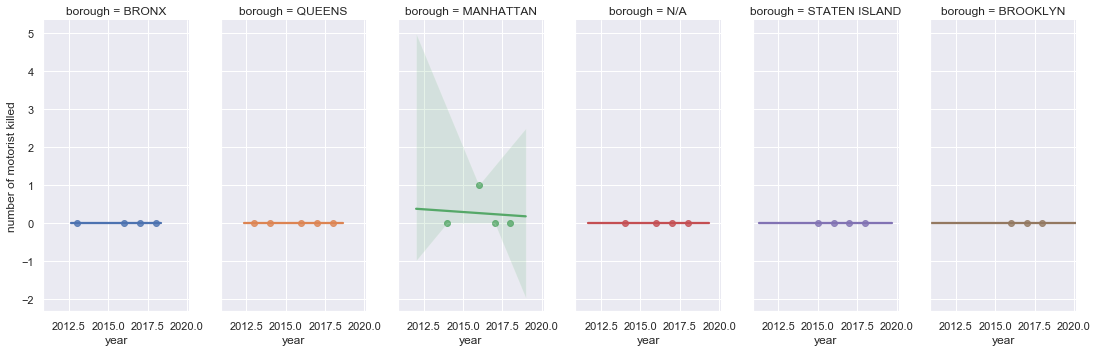

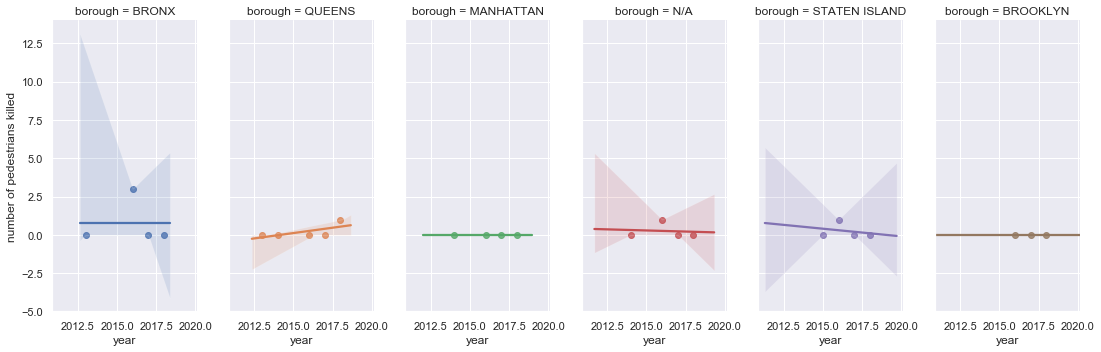

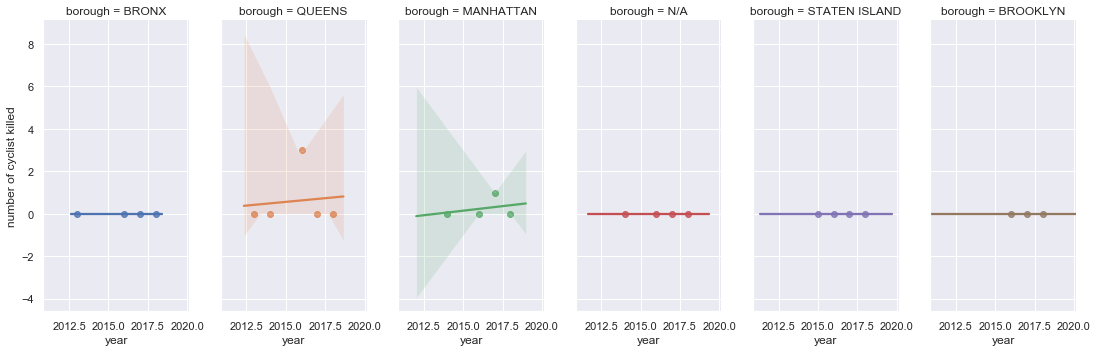

In [42]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'others'] , col='borough', hue='borough', injured_killed='killed')

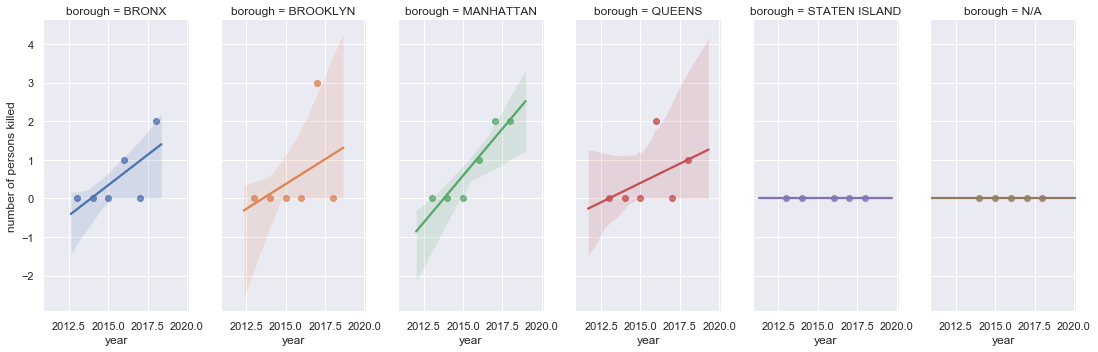

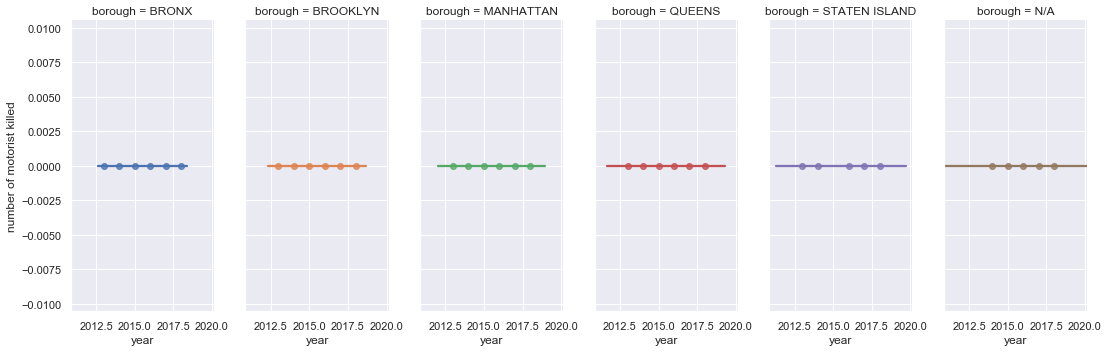

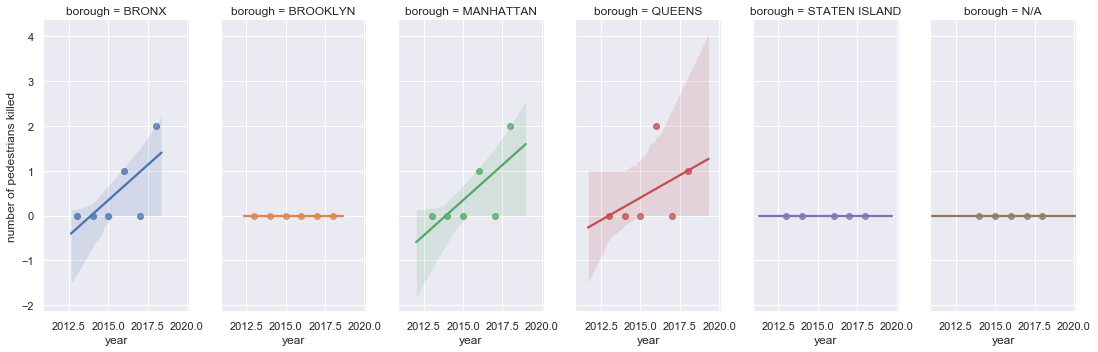

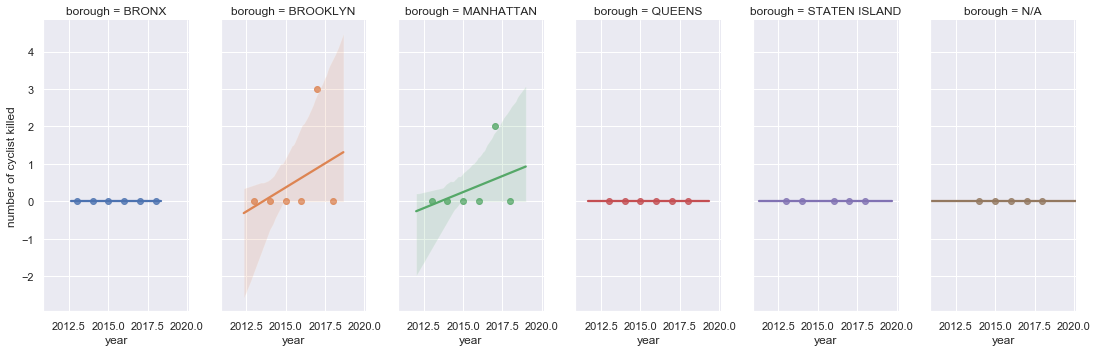

In [43]:
Plot_Injuries_vs_Year(df_ksi.loc[df_ksi['road_type'] == 'avenue'] , col='borough', hue='borough', injured_killed='killed')

In [44]:
pivot_table(df= df_ksi, injured_killed='killed', index='year')

number of cyclist killed  number of motorist killed  \
year                                                        
2016                         4                          1   
2017                         7                          0   
2018                         0                          0   
2019                         1                          0   
2012                         0                          0   
2013                         0                          0   
2014                         0                          0   
2015                         0                          0   

      number of pedestrians killed  number of persons killed  
year                                                          
2016                            14                      19.0  
2017                             7                      14.0  
2018                             8                       8.0  
2019                             4                       5.0  
2012                             0                       0.0  
2013                             0                       0.0  
2014                             0                       0.0  
2015                             0                       0.0

In [45]:
pivot_table(df= df_ksi, injured_killed='injured', index='year')

number of cyclist injured  number of motorist injured  \
year                                                          
2017                        555                          71   
2016                        558                          67   
2018                        508                          87   
2019                        311                          55   
2014                          0                          13   
2015                          0                          12   
2013                          1                           8   
2012                          0                           7   

      number of pedestrians injured  number of persons injured  
year                                                            
2017                            498                     1124.0  
2016                            465                     1090.0  
2018                            440                     1036.0  
2019                            234                      600.0  
2014                              1                       14.0  
2015                              0                       12.0  
2013                              0                        9.0  
2012                              0                        7.0

In [46]:
pivot_table(df= df_ksi.loc[df_ksi['road_type'] == 'avenue'], injured_killed='injured', index='borough')


number of cyclist injured  number of motorist injured  \
borough                                                                
BROOKLYN                             373                          66   
BRONX                                131                          46   
MANHATTAN                            168                          13   
QUEENS                               105                          11   
STATEN ISLAND                         19                           4   
N/A                                   16                           2   

               number of pedestrians injured  number of persons injured  
borough                                                                  
BROOKLYN                                 286                      725.0  
BRONX                                    191                      368.0  
MANHATTAN                                151                      332.0  
QUEENS                                    64                      179.0  
STATEN ISLAND                             23                       46.0  
N/A                                       13                       31.0

Assumption 2: the reason for the spike in the 2016 compare to the previous years is because NYPD start implementing the digital reproting system. That is, it's faster and conveninent for the police and citizens to reprot, leading to dramatic increase in the number of reprots

# general data


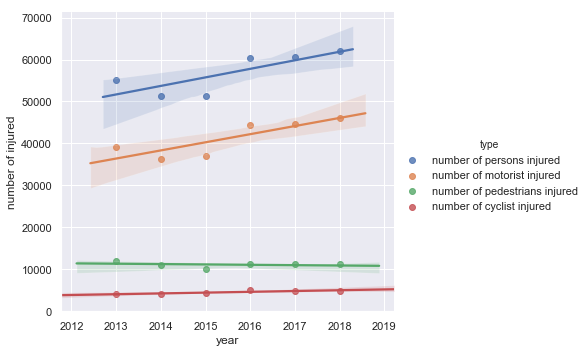

In [47]:
Plot_Injuries_vs_Year(df_col, col=None, hue=None, injured_killed='injured')

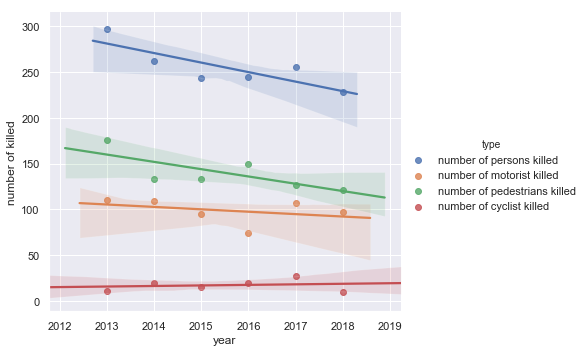

In [48]:
Plot_Injuries_vs_Year(df_col, col=None, hue=None, injured_killed='killed')

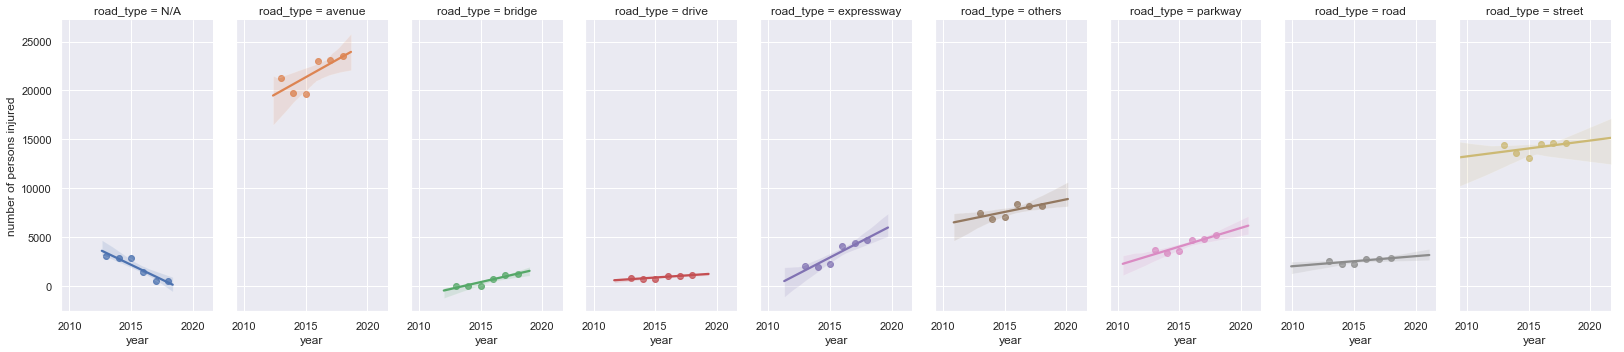

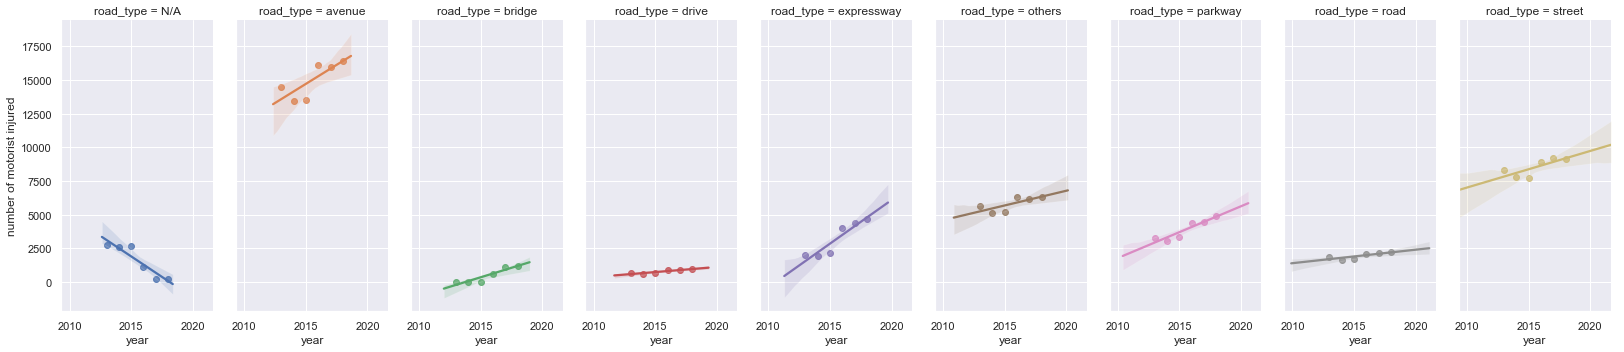

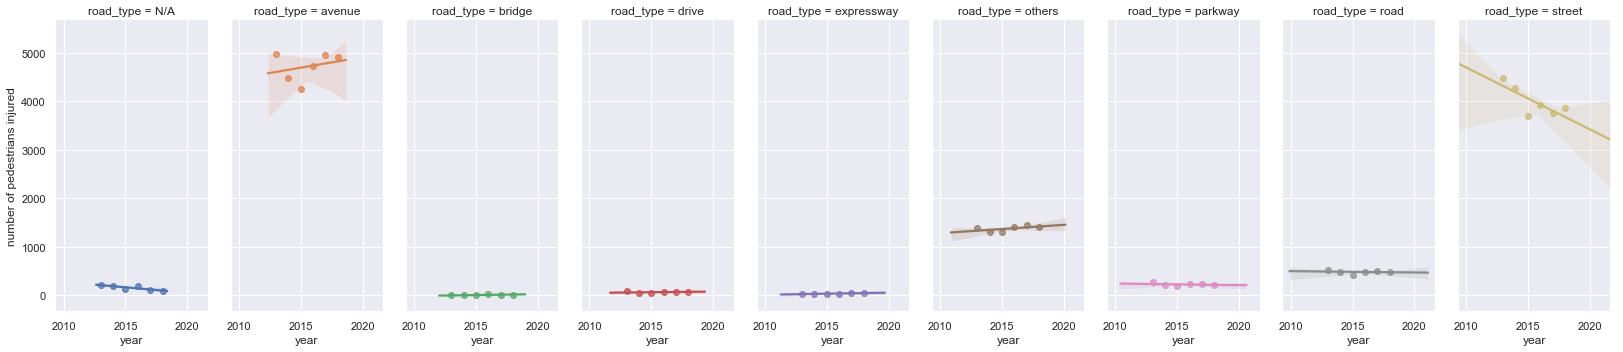

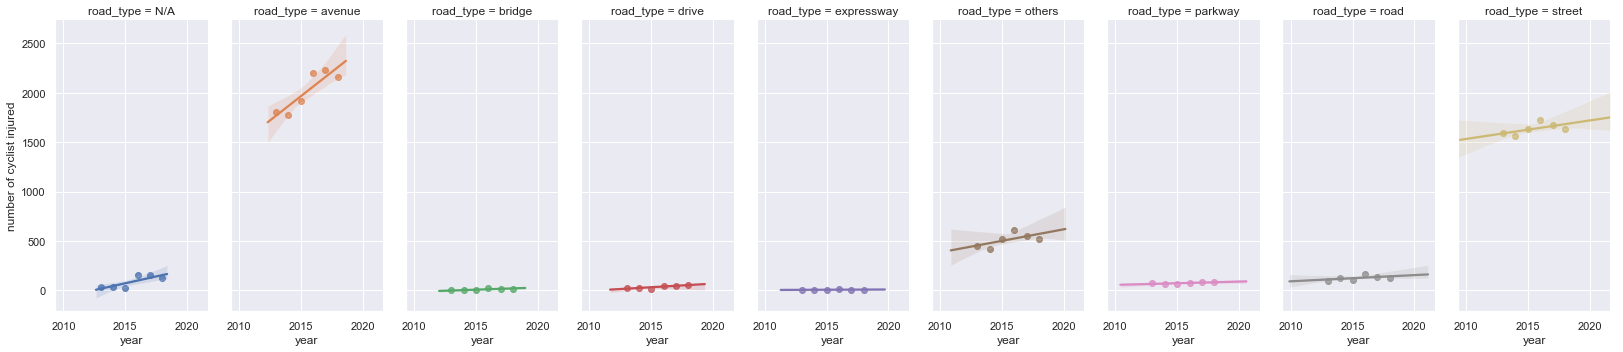

In [49]:
Plot_Injuries_vs_Year(df_col, col='road_type', hue='road_type', injured_killed='injured')

In [50]:
pivot_table(df_col, injured_killed= "killed", index='borough')


number of cyclist killed  number of motorist killed  \
borough                                                              
QUEENS                               27                        224   
BROOKLYN                             49                        165   
MANHATTAN                            30                         58   
BRONX                                11                        101   
N/A                                   9                        109   
STATEN ISLAND                         3                         52   

               number of pedestrians killed  number of persons killed  
borough                                                                
QUEENS                                  252                     503.0  
BROOKLYN                                260                     475.0  
MANHATTAN                               198                     285.0  
BRONX                                   135                     246.0  
N/A                                      98                     213.0  
STATEN ISLAND                            38                      93.0

In [51]:
pivot_table(df= df_col, injured_killed='injured', index='borough')


number of cyclist injured  number of motorist injured  \
borough                                                                
BROOKLYN                           11925                       85722   
QUEENS                              5848                       84533   
BRONX                               2865                       44408   
MANHATTAN                           9124                       32073   
N/A                                 2105                       35344   
STATEN ISLAND                        391                       14583   

               number of pedestrians injured  number of persons injured  
borough                                                                  
BROOKLYN                               24667                   122241.0  
QUEENS                                 17069                   107455.0  
BRONX                                  11792                    59055.0  
MANHATTAN                              17795                    58905.0  
N/A                                     5070                    42460.0  
STATEN ISLAND                           2346                    17308.0

In [52]:
pivot_table(df= df_col, injured_killed='killed', index='year')

number of cyclist killed  number of motorist killed  \
year                                                        
2013                        11                        110   
2014                        20                        109   
2017                        27                        107   
2016                        20                         74   
2015                        15                         95   
2018                        10                         97   
2019                        20                         58   
2012                         6                         59   

      number of pedestrians killed  number of persons killed  
year                                                          
2013                           176                     297.0  
2014                           133                     262.0  
2017                           126                     255.0  
2016                           150                     245.0  
2015                           133                     243.0  
2018                           121                     228.0  
2019                            70                     148.0  
2012                            72                     137.0

In [53]:
pivot_table(df= df_col, injured_killed='injured', index='year')

number of cyclist injured  number of motorist injured  \
year                                                          
2018                       4725                       46059   
2017                       4889                       44620   
2016                       5005                       44470   
2013                       4075                       39062   
2015                       4281                       36993   
2014                       4000                       36172   
2019                       3074                       29956   
2012                       2209                       19331   

      number of pedestrians injured  number of persons injured  
year                                                            
2018                          11118                    61928.0  
2017                          11152                    60658.0  
2016                          11108                    60307.0  
2013                          11988                    55125.0  
2015                          10084                    51358.0  
2014                          11036                    51219.0  
2019                           6347                    39377.0  
2012                           5906                    27452.0

In [54]:
pivot_table(df= df_col, injured_killed='injured', index='road_type')


number of cyclist injured  number of motorist injured  \
road_type                                                           
avenue                          14513                      107915   
street                          11665                       61228   
others                           3647                       41695   
parkway                           526                       28110   
expressway                         49                       23219   
road                              904                       14099   
N/A                               626                       11107   
drive                             258                        5627   
bridge                             70                        3663   

            number of pedestrians injured  number of persons injured  
road_type                                                             
avenue                              33551                   155901.0  
street                              28508                   101348.0  
others                               9767                    55086.0  
parkway                              1599                    30220.0  
expressway                            271                    23513.0  
road                                 3397                    18393.0  
N/A                                  1096                    12801.0  
drive                                 486                     6364.0  
bridge                                 64                     3798.0

In [55]:
pivot_table(df= df_col, injured_killed='killed', index='road_type')


number of cyclist killed  number of motorist killed  \
road_type                                                         
avenue                            61                        235   
others                            19                        126   
street                            36                         81   
parkway                            2                        104   
expressway                         0                         72   
road                               7                         26   
N/A                                3                         37   
drive                              0                         16   
bridge                             1                         12   

            number of pedestrians killed  number of persons killed  
road_type                                                           
avenue                               400                     698.0  
others                               200                     343.0  
street                               227                     342.0  
parkway                               47                     152.0  
expressway                            37                     109.0  
road                                  35                      68.0  
N/A                                   26                      66.0  
drive                                  8                      24.0  
bridge                                 1                      13.0

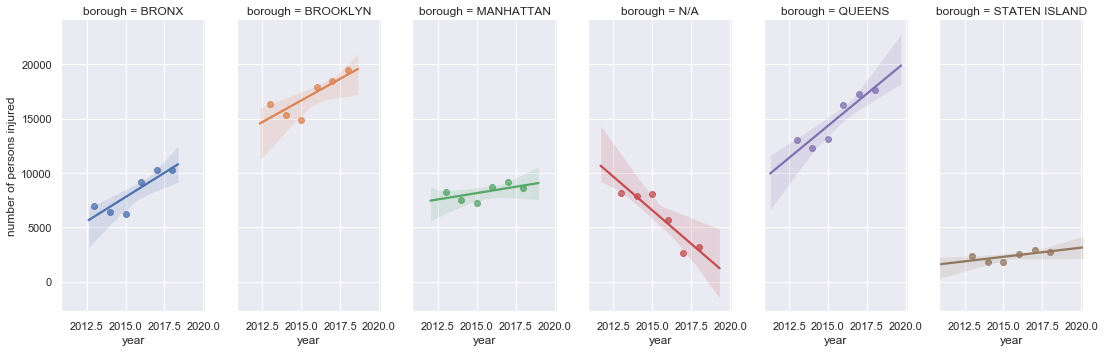

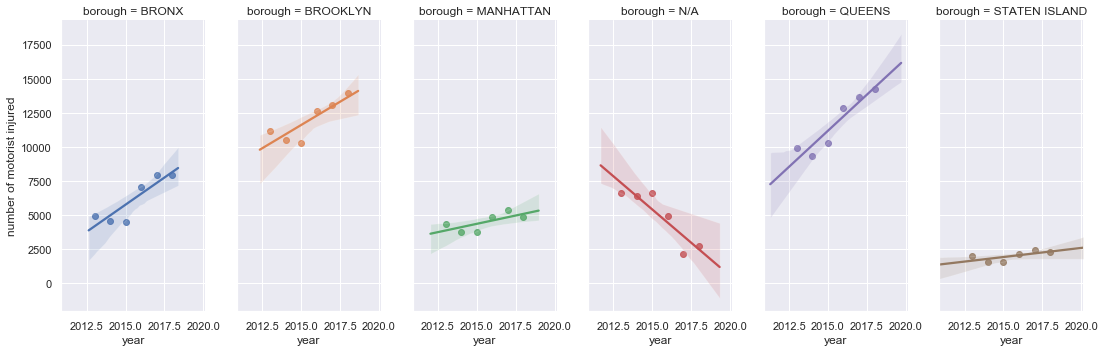

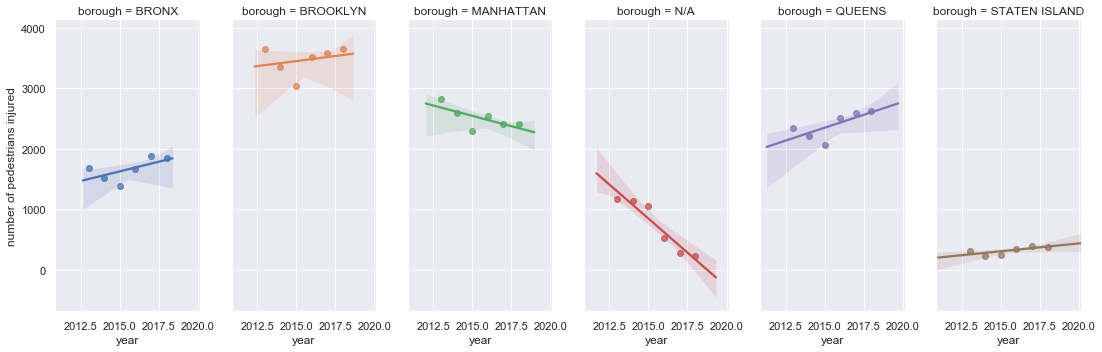

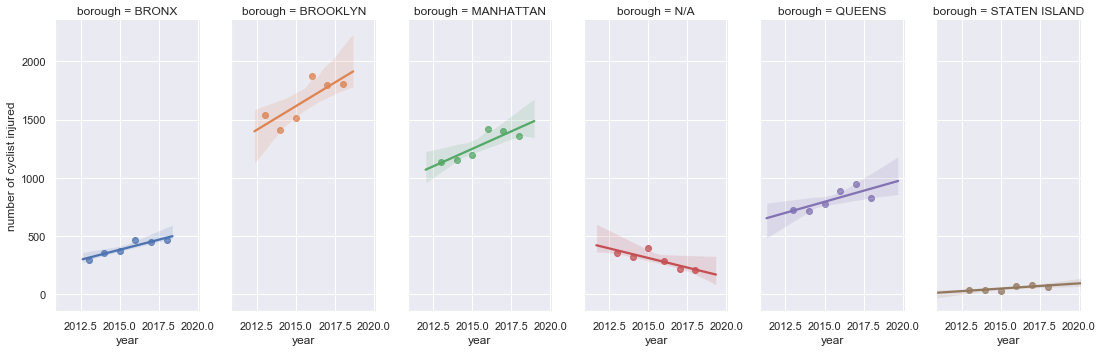

In [56]:
Plot_Injuries_vs_Year(df_col, col='borough', hue='borough', injured_killed='injured')

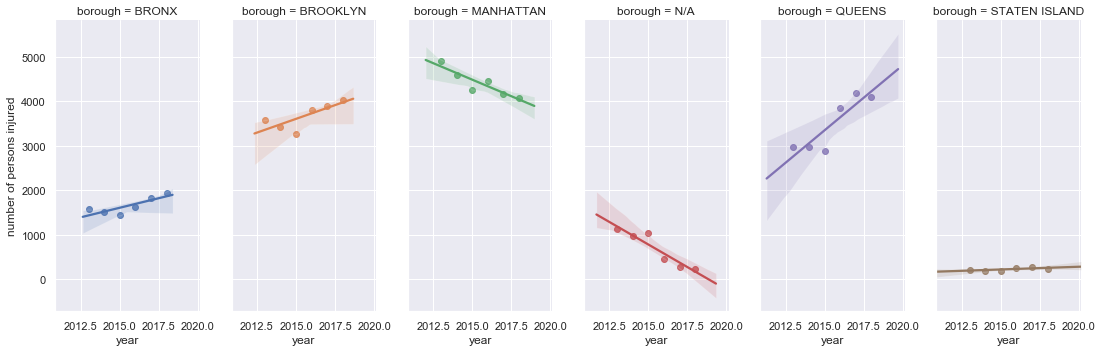

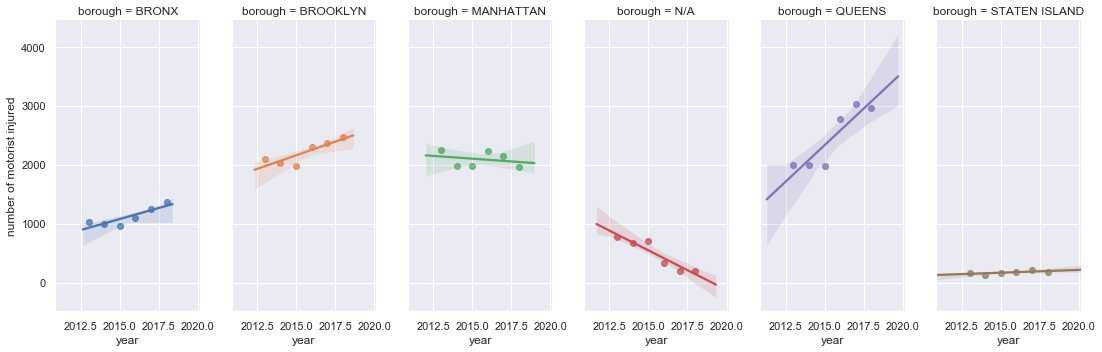

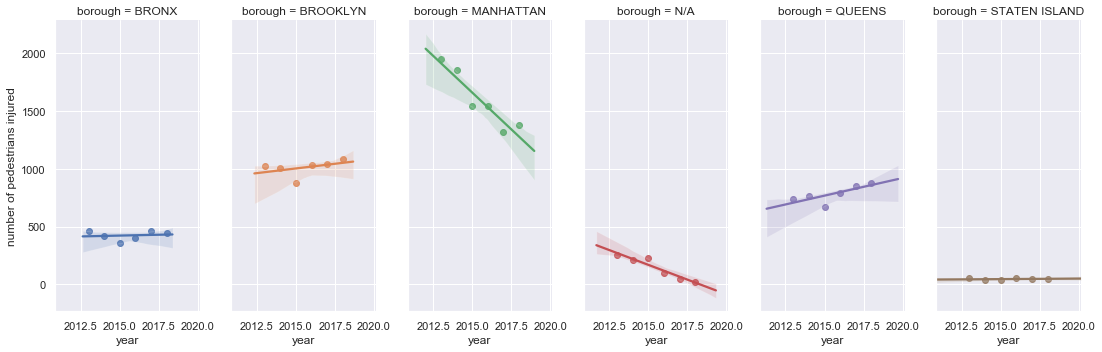

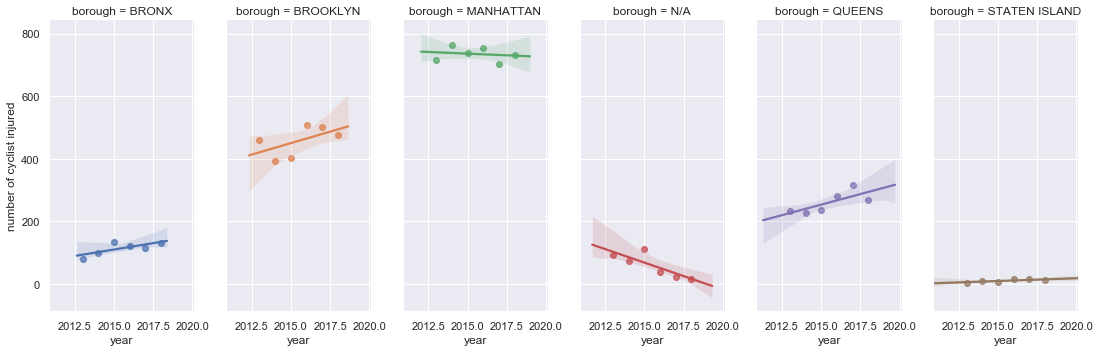

In [57]:
Plot_Injuries_vs_Year(df_col.loc[df_col['road_type'] == 'street'] , col='borough', hue='borough', injured_killed='injured')

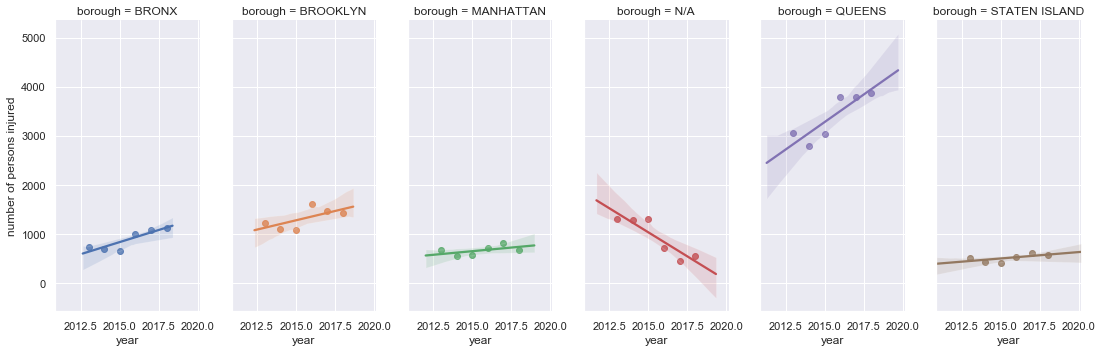

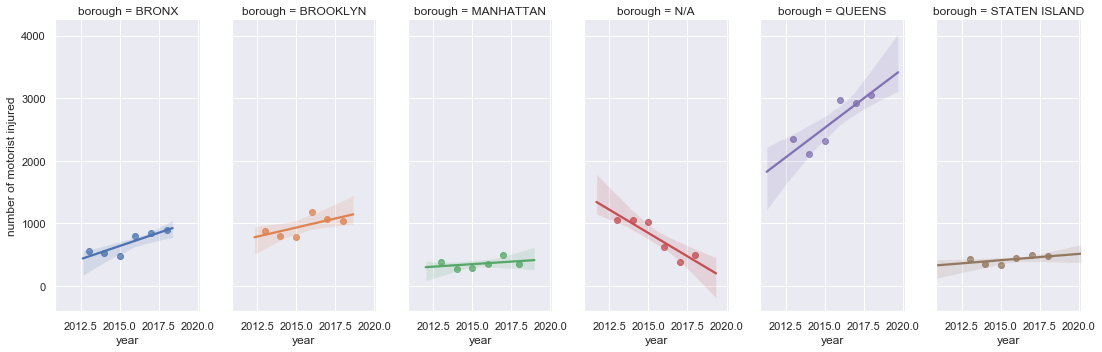

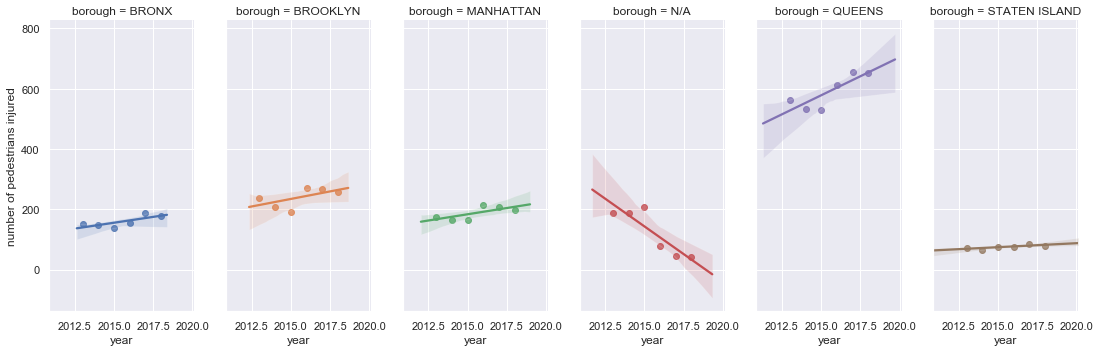

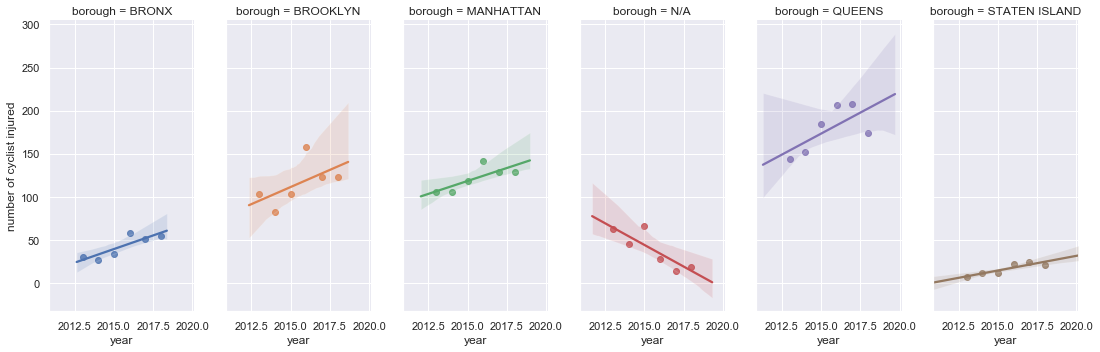

In [58]:
Plot_Injuries_vs_Year(df_col.loc[df_col['road_type'] == 'others'] , col='borough', hue='borough', injured_killed='injured')

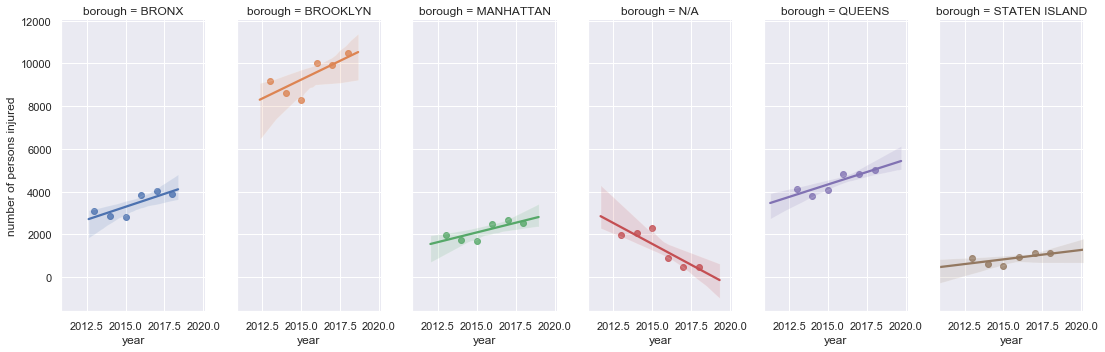

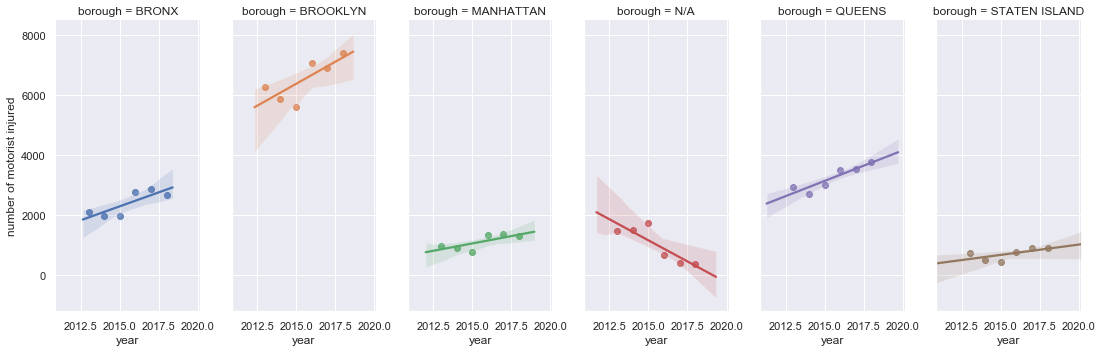

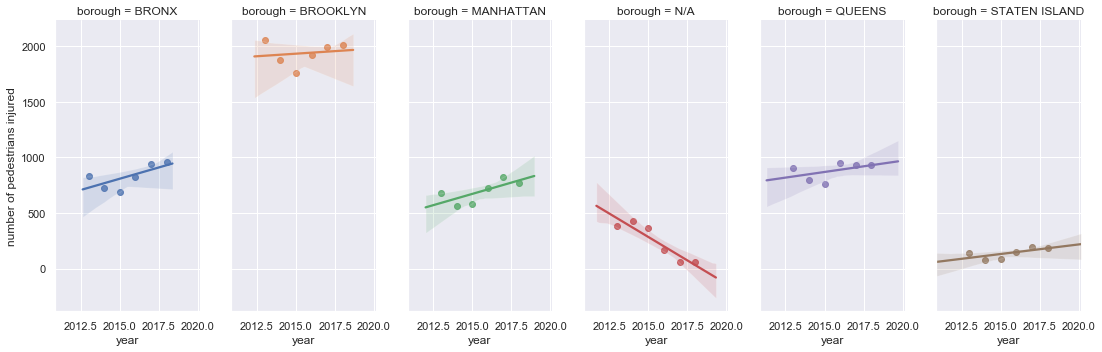

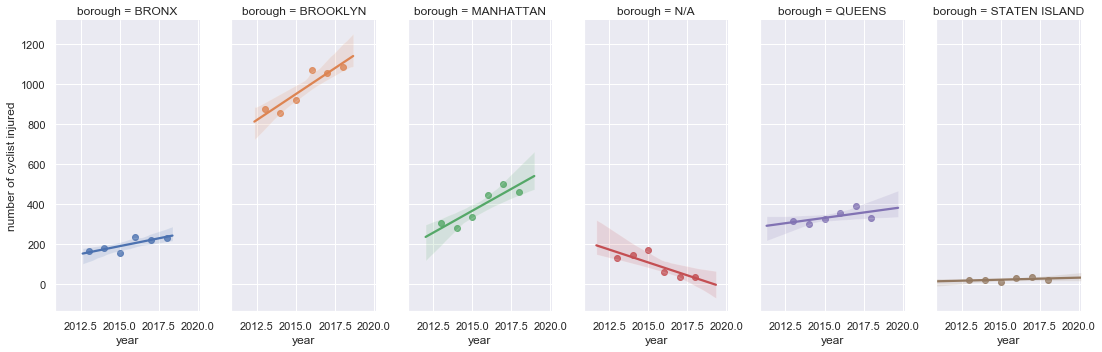

In [59]:
Plot_Injuries_vs_Year(df_col.loc[df_col['road_type'] == 'avenue'] , col='borough', hue='borough', injured_killed='injured')

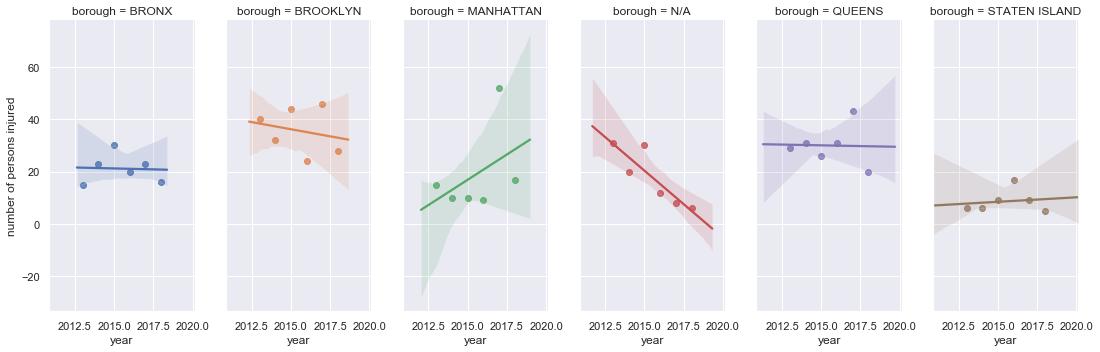

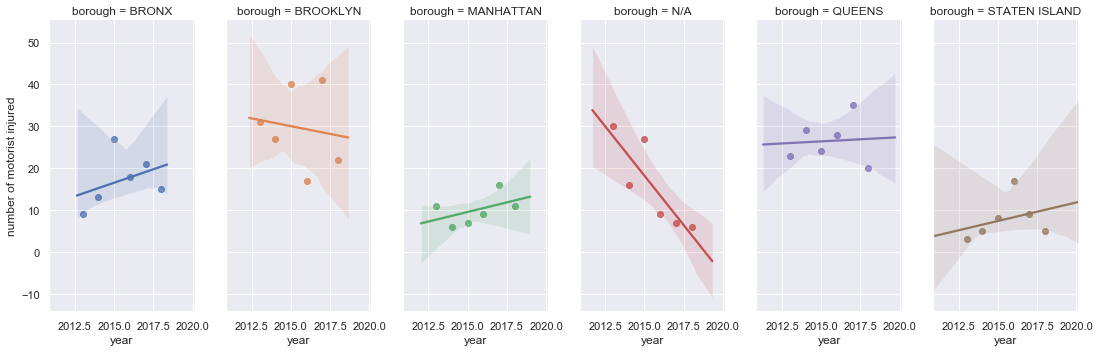

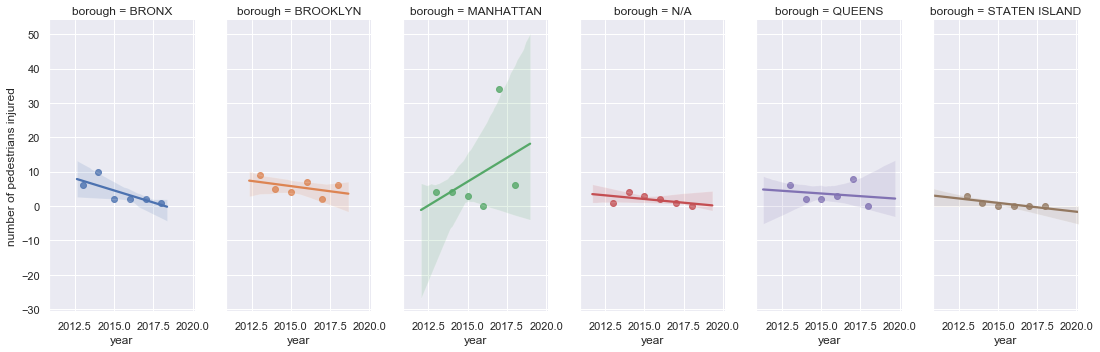

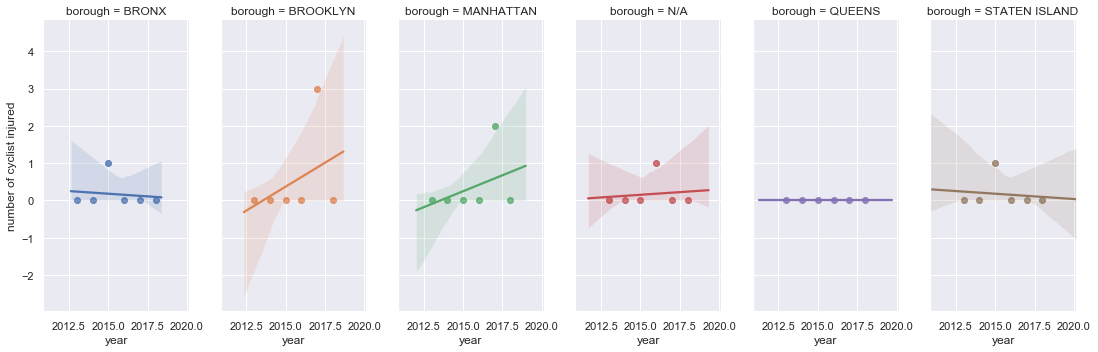

In [60]:
test = df_col.loc[(df_col['number of persons killed'] > 0) & (df_col['number of persons injured'] > 0)]

Plot_Injuries_vs_Year(test, col='borough', hue='borough', injured_killed='injured')

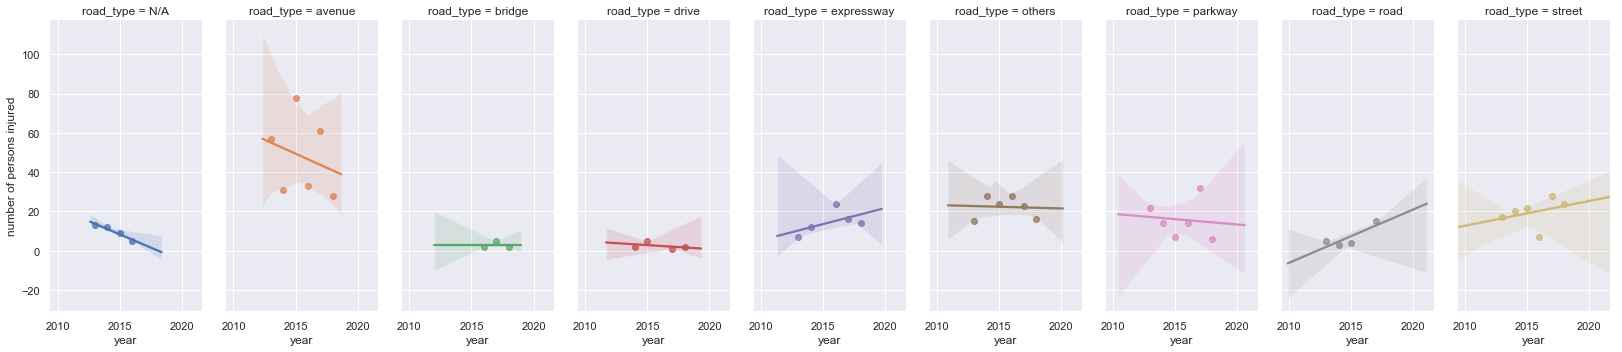

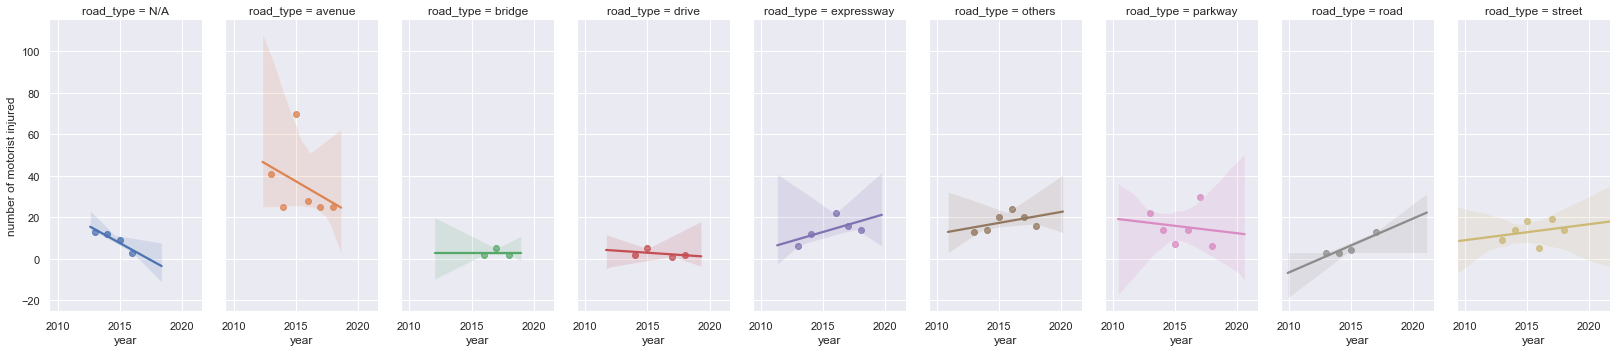

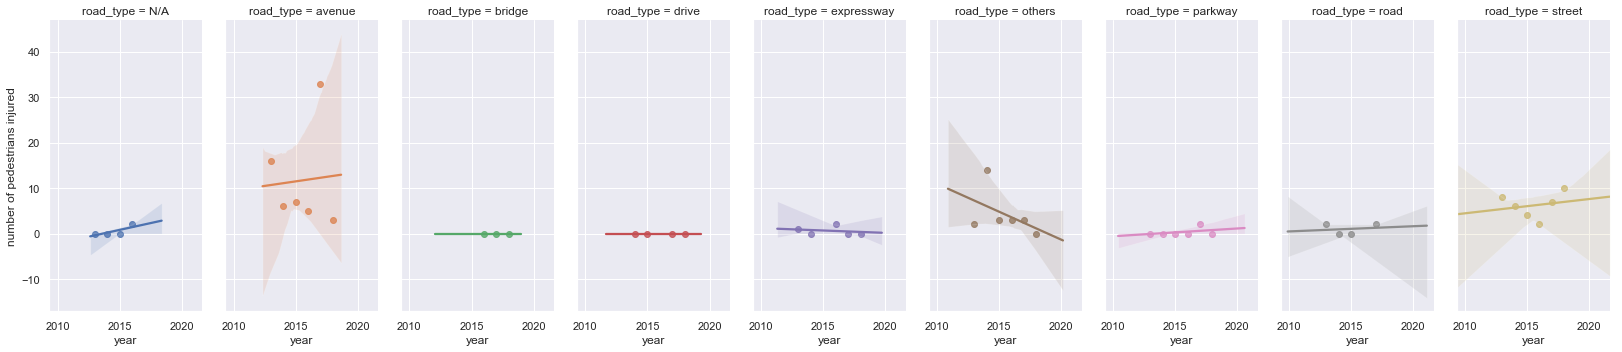

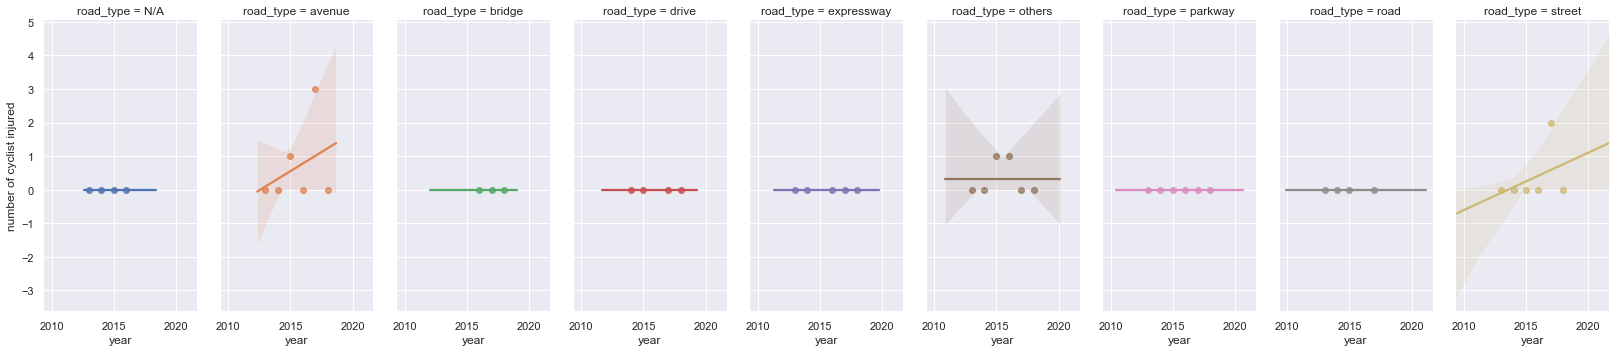

In [61]:
Plot_Injuries_vs_Year(test, col='road_type', hue='road_type', injured_killed='injured')

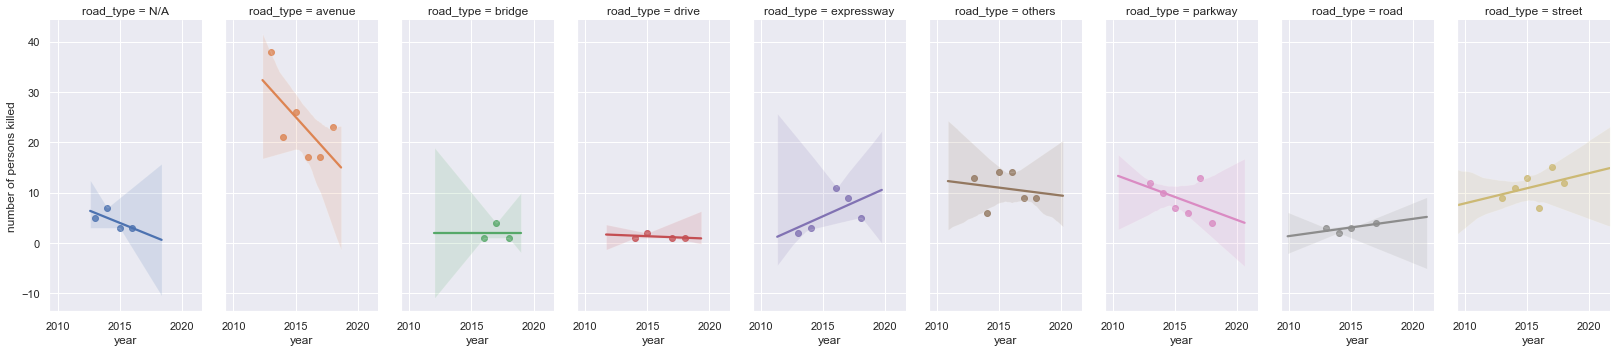

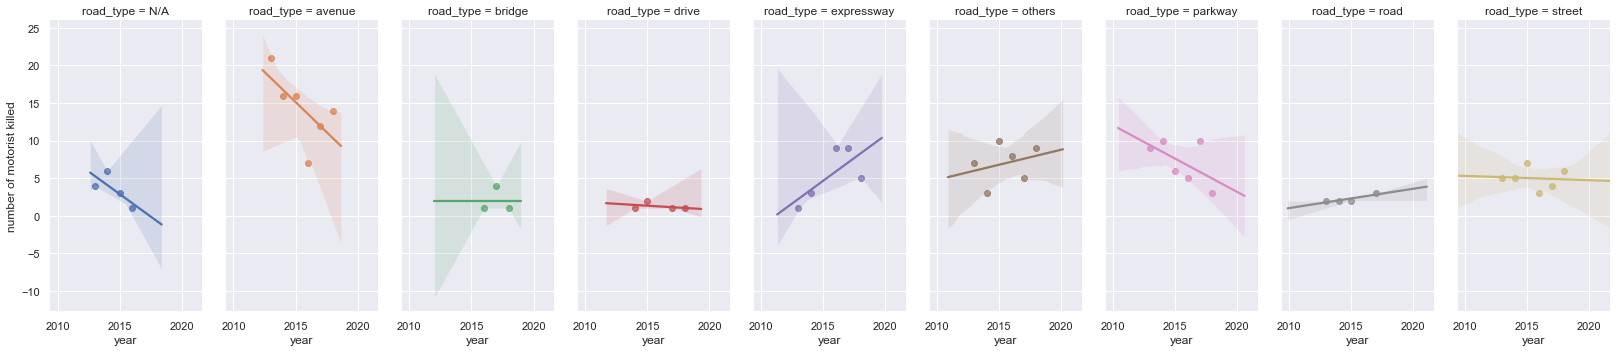

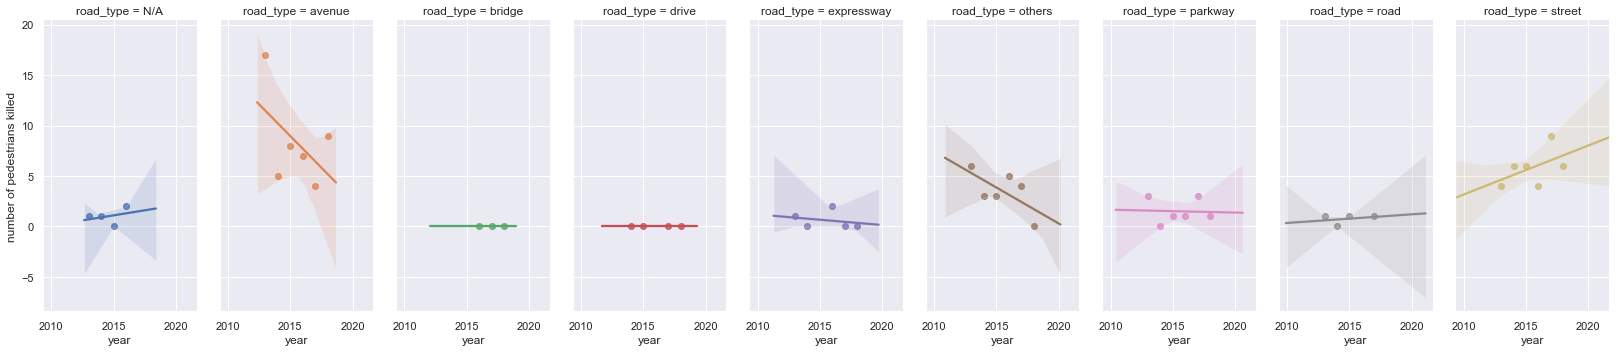

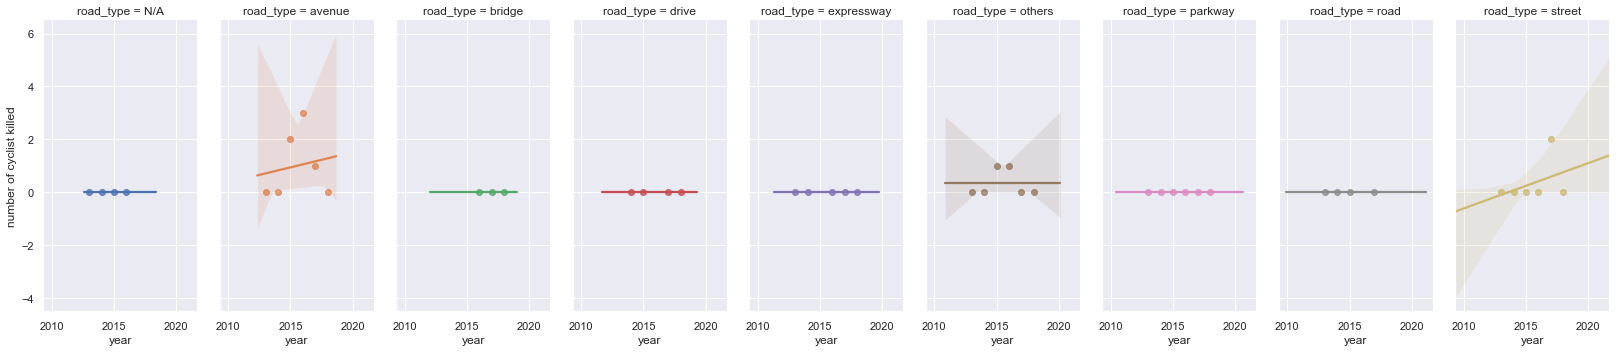

In [62]:
Plot_Injuries_vs_Year(test, col='road_type', hue='road_type', injured_killed='killed')

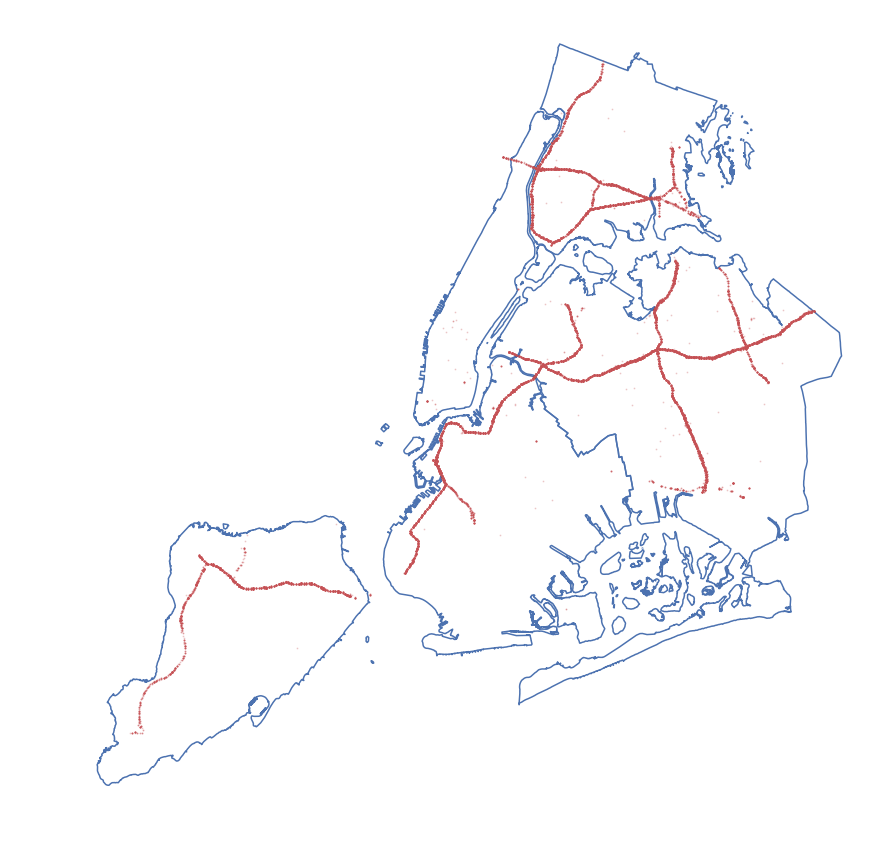

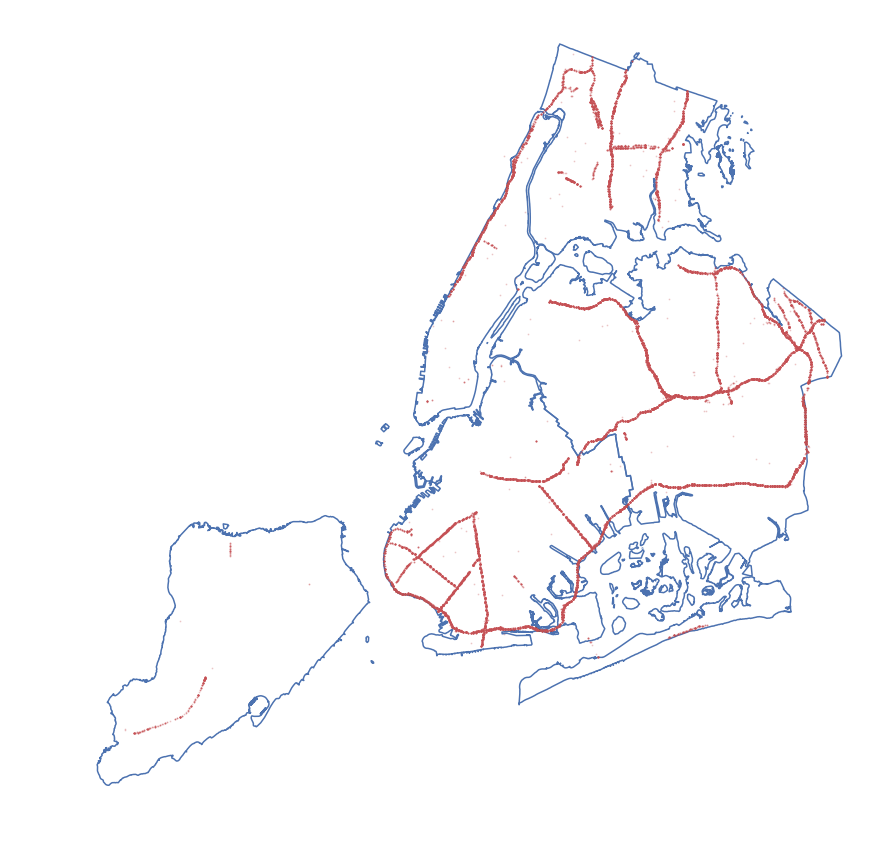

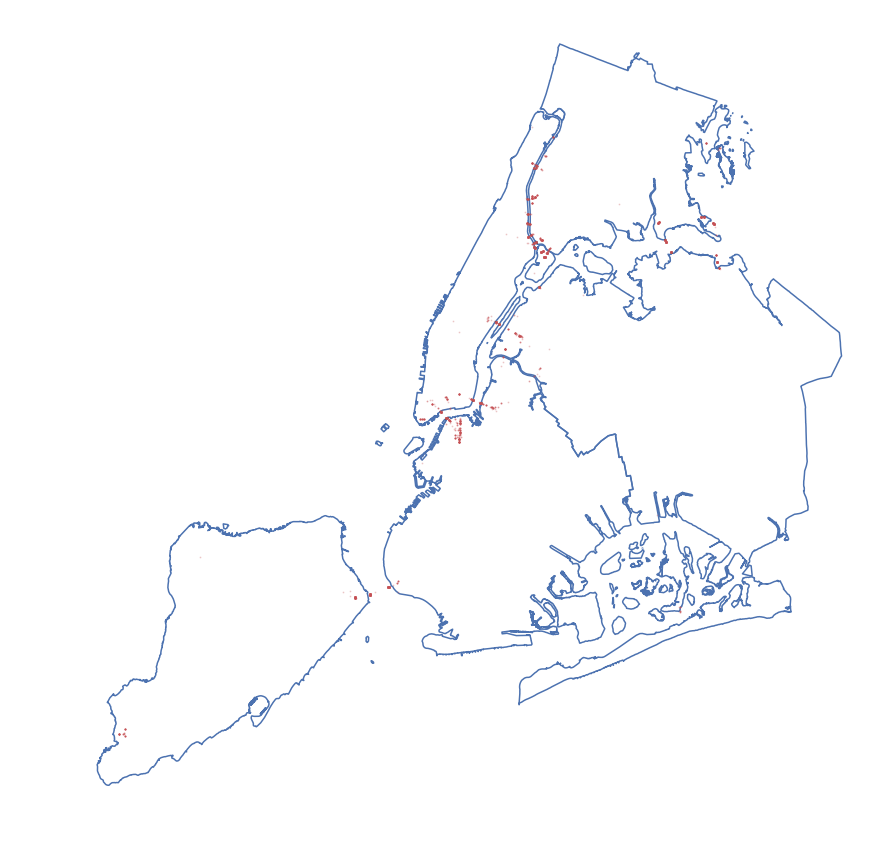

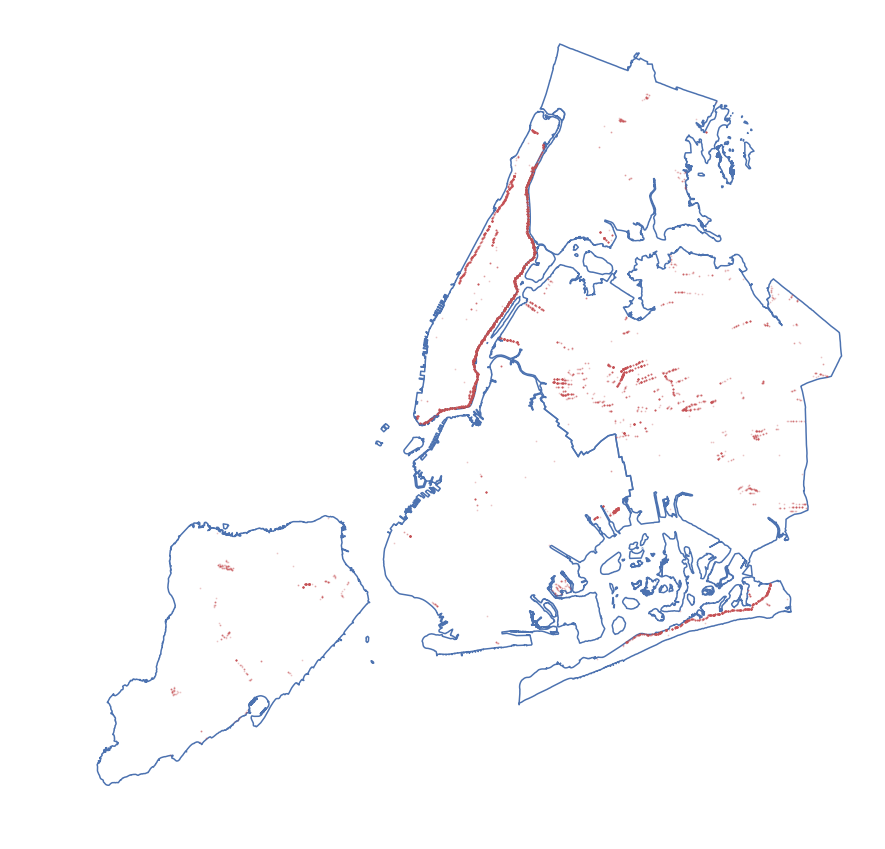

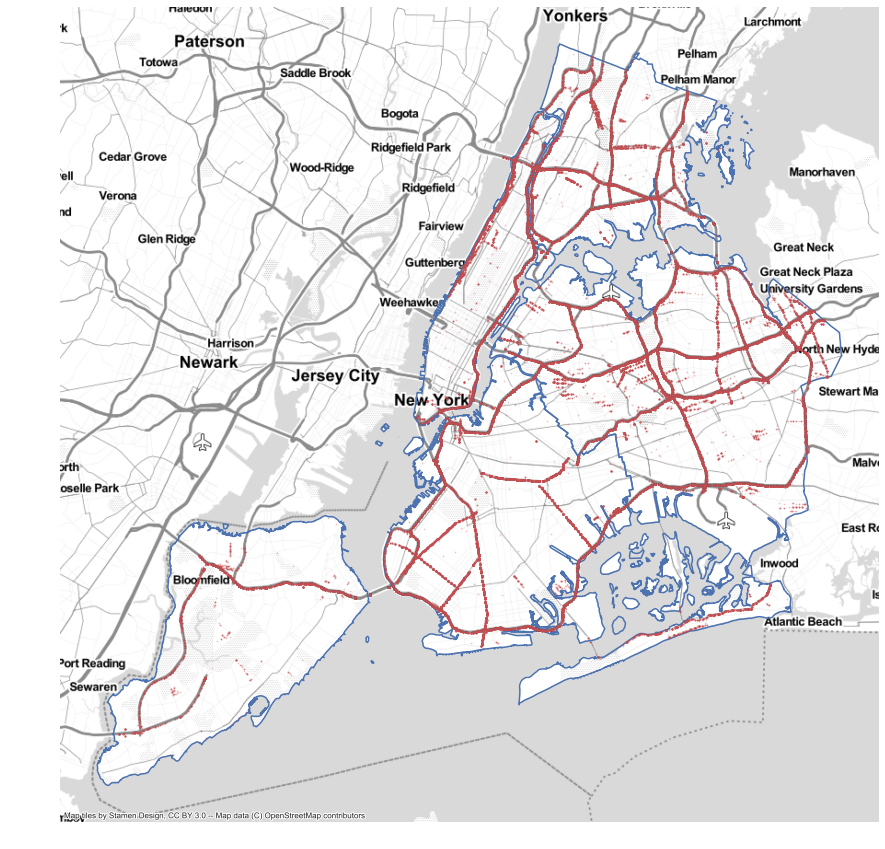

In [63]:
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='expressway','location'].dropna(), ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='parkway','location'].dropna(), ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='bridge','location'].dropna(), ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='drive','location'].dropna(), ON_MAP=False)

Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type'].apply(lambda x: x in ['expressway','parkway','bridge','drive']),'location'].dropna())

In [153]:
df_arterial = pd.read_csv("data/dot_VZV_Arterial_Slow_Zones_20190903.csv")
df_bike = pd.read_csv("data/dot_VZV_Bike_Priority_Districts_20190903.csv")
df_cross = pd.read_csv("data/dot_VZV_Enhanced_Crossings_20190903.csv")
df_left = pd.read_csv("data/dot_VZV_Left_Turn_Traffic_Calming_20190903.csv")
df_slow = pd.read_csv("data/dot_VZV_Neighborhood_Slow_Zones_20190903.csv")
df_signal = pd.read_csv("data/dot_VZV_Signal_Timing_20190903.csv")
df_spdhump = pd.read_csv("data/dot_VZV_Speed_Humps_20190903.csv")
df_spdlimit = pd.read_csv("data/dot_VZV_Speed_Limits_20190903.csv")

df_arterial['the_geom'] = df_arterial['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_bike['the_geom'] = df_bike['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_cross['the_geom'] = df_cross['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_left['the_geom'] = df_left['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_slow['the_geom'] = df_slow['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_signal['the_geom'] = df_signal['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_spdhump['the_geom'] = df_spdhump['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_spdlimit['the_geom'] = df_spdlimit['the_geom'].apply(lambda x: shapely.wkt.loads(x))

if False: 
    is_arterial, geoms_arterial = Is_Event_of_Geom(df_col, df_arterial, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_arterial, geoms_arterial], open('data/is_arterial.pickle', 'wb'))
    # 10000 : 37 s
    # total : 1h 22min 9s
else:
    is_arterial, geoms_arterial = pickle.load(open('data/is_arterial.pickle', 'rb'))        

if False: 
    is_bike, geoms_bike = Is_Event_of_Geom(df_col, df_bike, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_bike, geoms_bike], open('data/is_bike.pickle', 'wb'))
    # 10000 : 11.6 s
    # 100000 : 
else:
    is_bike, geoms_bike = pickle.load(open('data/is_bike.pickle', 'rb'))    

if False: 
    is_cross, geoms_cross = Is_Event_of_Geom(df_col, df_cross, num_head = 100000000, THRESHOLD_DISTANCE = 0.0002)
    pickle.dump([is_cross, geoms_cross], open('data/is_cross.pickle', 'wb'))
    # 10000 : 1.61 s
    # 100000 : 13.7 s
    # total : 3min 45s
else:
    is_cross, geoms_cross = pickle.load(open('data/is_cross.pickle', 'rb'))

if False: 
    is_left, geoms_left = Is_Event_of_Geom(df_col, df_left, num_head = 100000000, THRESHOLD_DISTANCE = 0.0002)
    pickle.dump([is_left, geoms_left], open('data/is_left.pickle', 'wb'))
    # 10000 : 2.63 s
    # 100000 :
    # total : 5min 37s
else:
    is_left, geoms_left = pickle.load(open('data/is_left.pickle', 'rb'))    

if False: 
    is_slow, geoms_slow = Is_Event_of_Geom(df_col, df_slow, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_slow, geoms_slow], open('data/is_slow.pickle', 'wb'))
    # 10000 : 14.2 s
    # total : 25min 41s
else:
    is_slow, geoms_slow = pickle.load(open('data/is_slow.pickle', 'rb'))        

if False: 
    is_signal, geoms_signal = Is_Event_of_Geom(df_col, df_signal, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_signal, geoms_signal], open('data/is_signal.pickle', 'wb'))
    # 10000 : 22.1 s
    # 100000 : 41min 28s
else:
    is_signal, geoms_signal = pickle.load(open('data/is_signal.pickle', 'rb'))            

if False: 
    is_spdhump, geoms_spdhump = Is_Event_of_Geom(df_col, df_spdhump, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_spdhump, geoms_spdhump], open('data/is_spdhump.pickle', 'wb'))
    # 10000 : 14.6 s
    # total: 39min 43s
else:
    is_spdhump, geoms_spdhump = pickle.load(open('data/is_spdhump.pickle', 'rb'))                    
    
# if True: 
#     is_spdlimit, geoms_spdlimit = Is_Event_of_Geom(df_col, df_spdlimit, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
#     pickle.dump([is_spdlimit, geoms_spdlimit], open('is_spdlimit.pickle', 'wb'))
#     # 100 : 7min 45s
#     # 1000 : 9min 46s
# else:
#     is_spdlimit, geoms_spdlimit = pickle.load(open('is_spdlimit.pickle', 'rb'))                    

df_col['is_arterial'] = is_arterial
df_col['is_bike'] = is_bike
df_col['is_cross'] = is_cross
df_col['is_left'] = is_left
df_col['is_slow'] = is_slow
df_col['is_signal'] = is_signal
df_col['is_spdhump'] = is_spdhump
# df_col['is_spdlimit'] = is_spdlimit

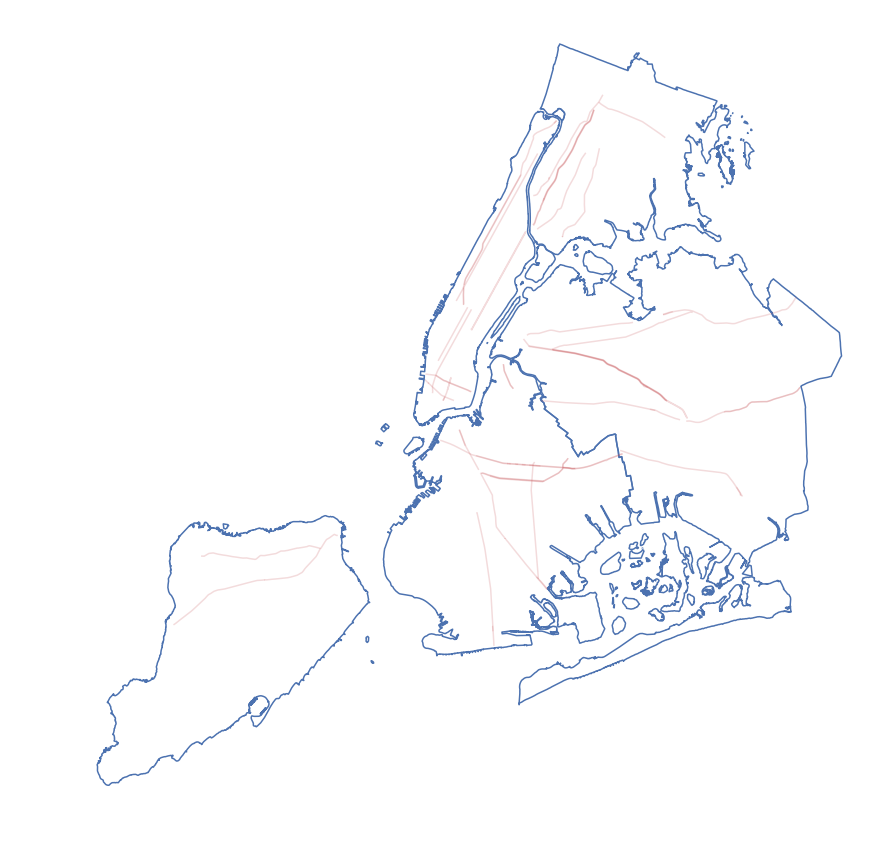

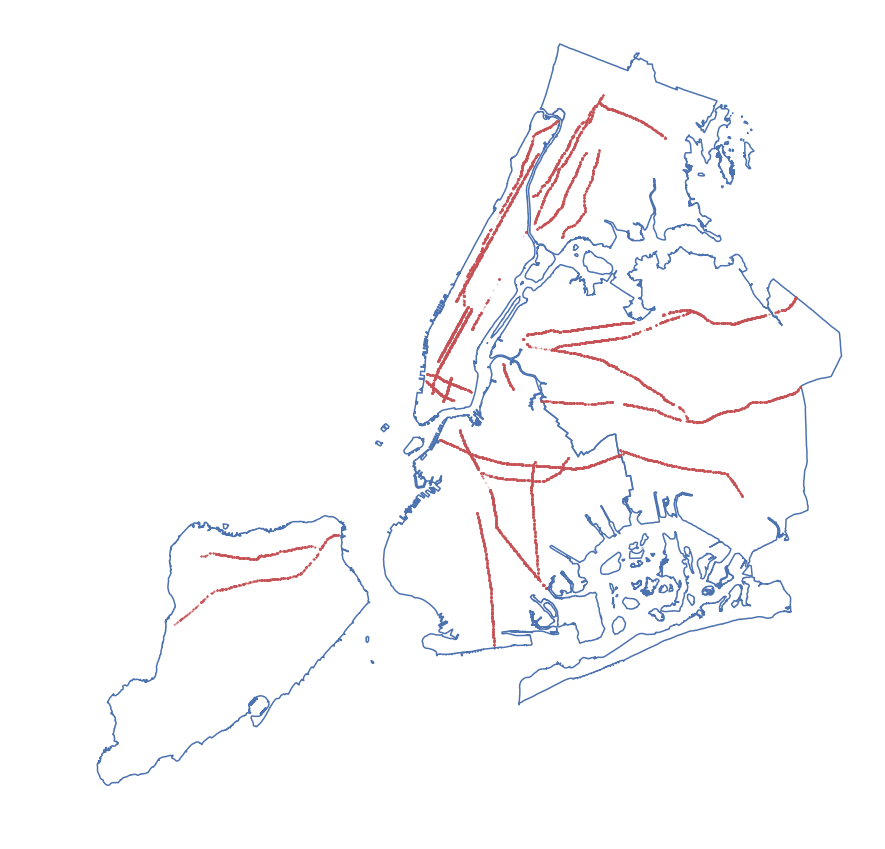

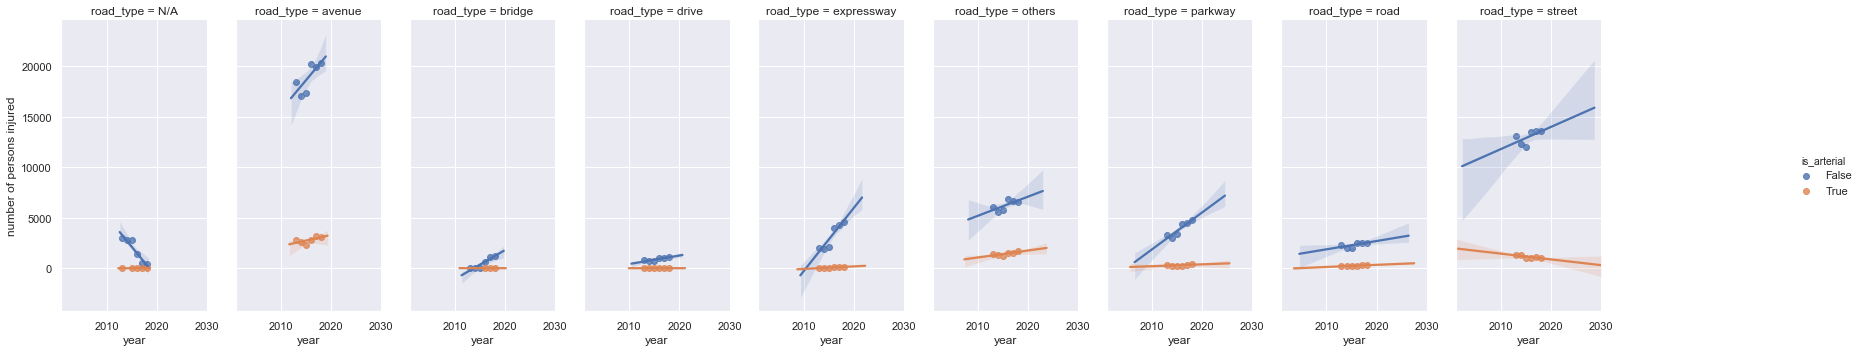

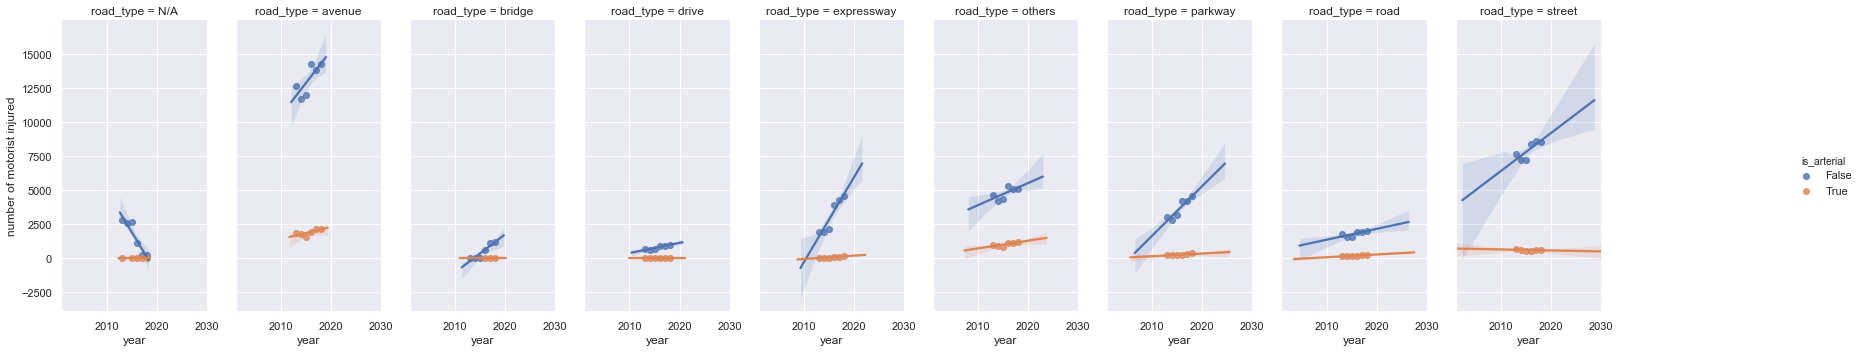

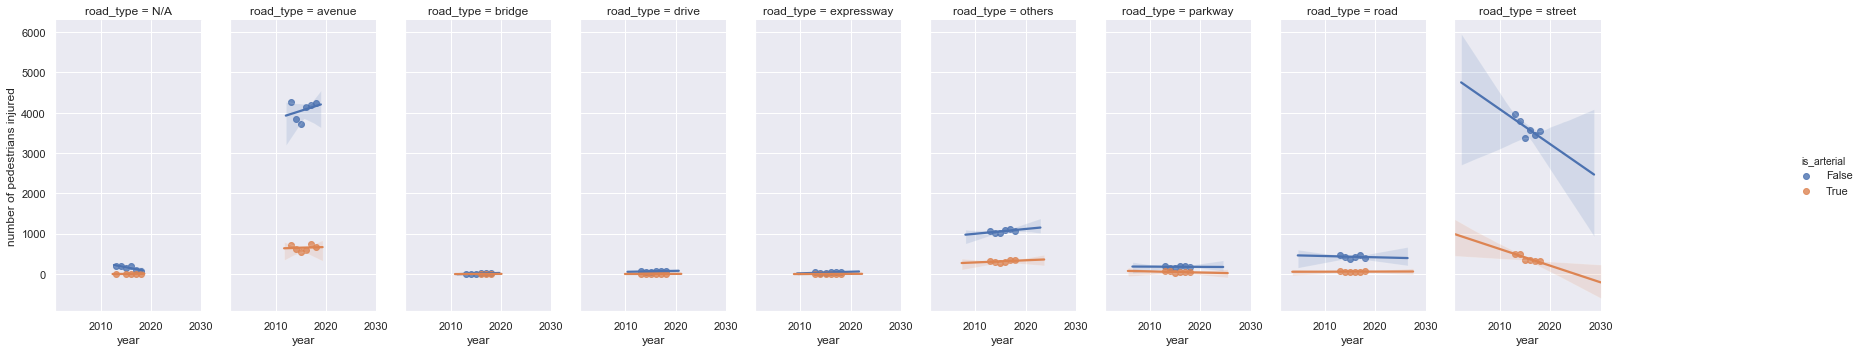

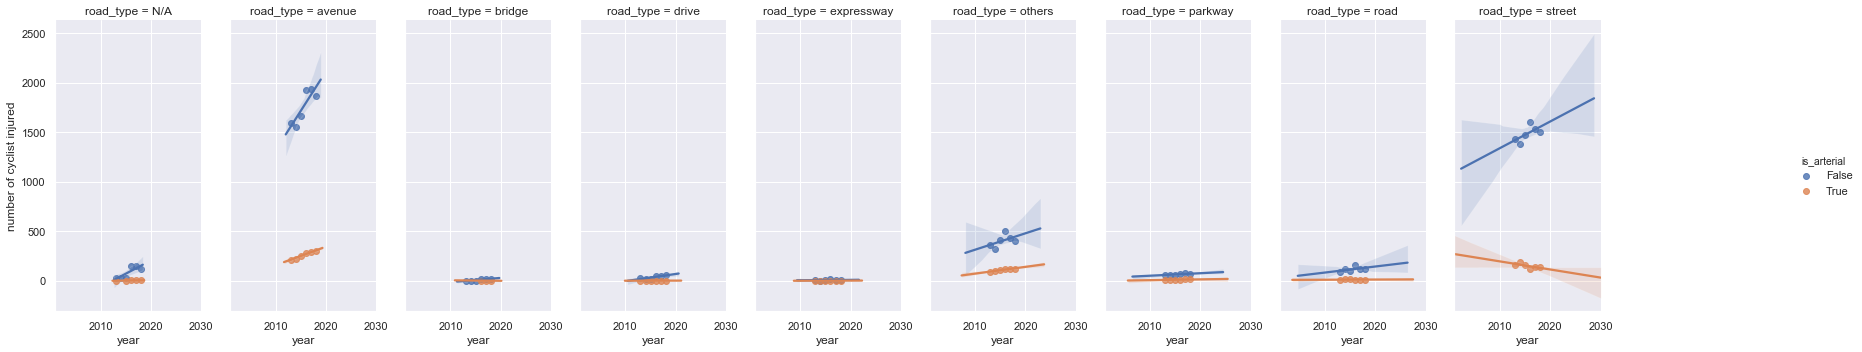

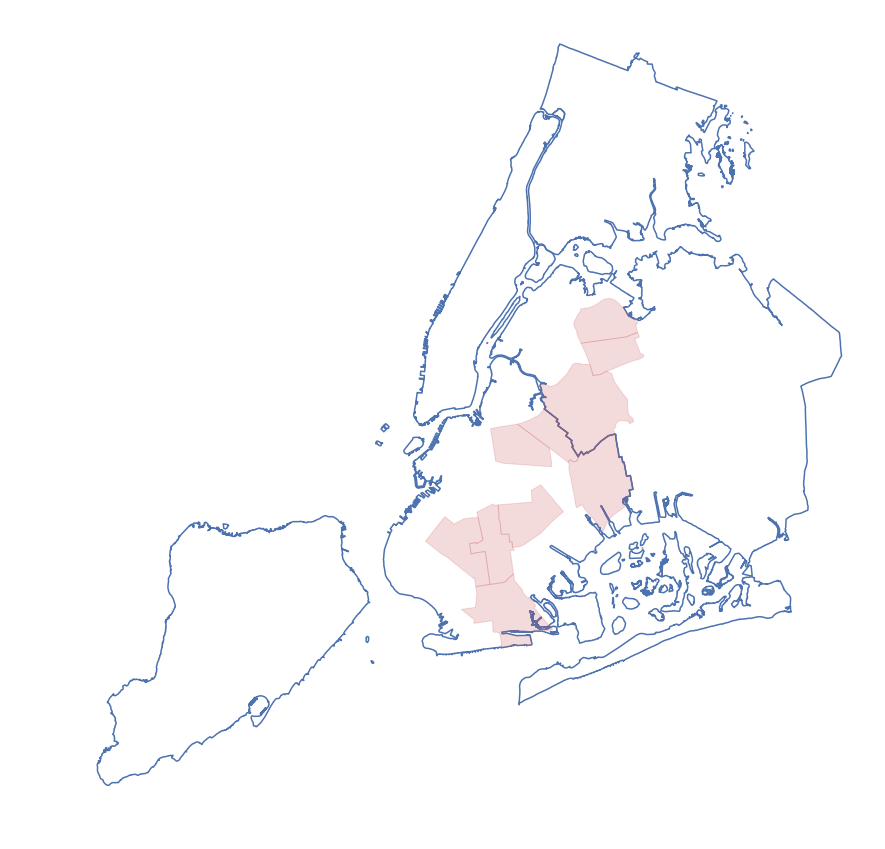

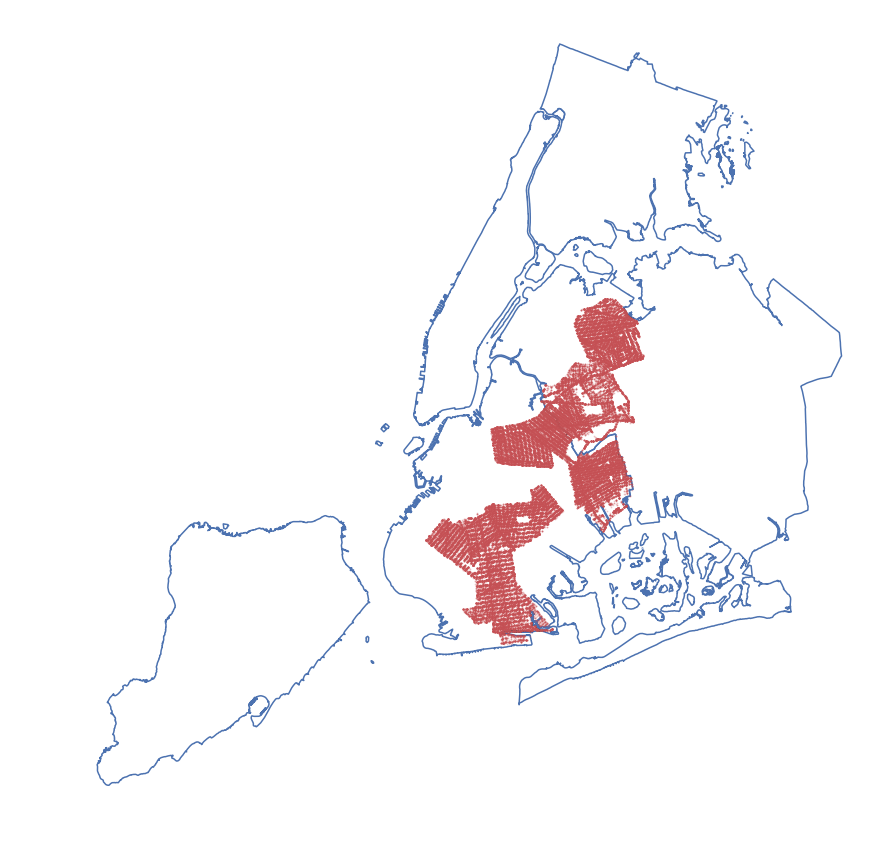

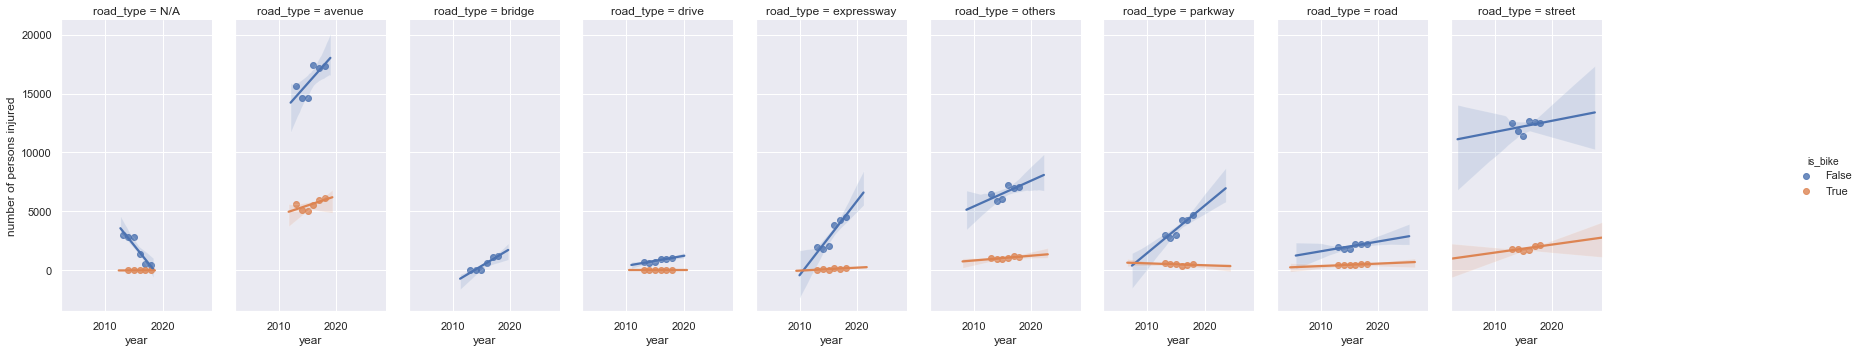

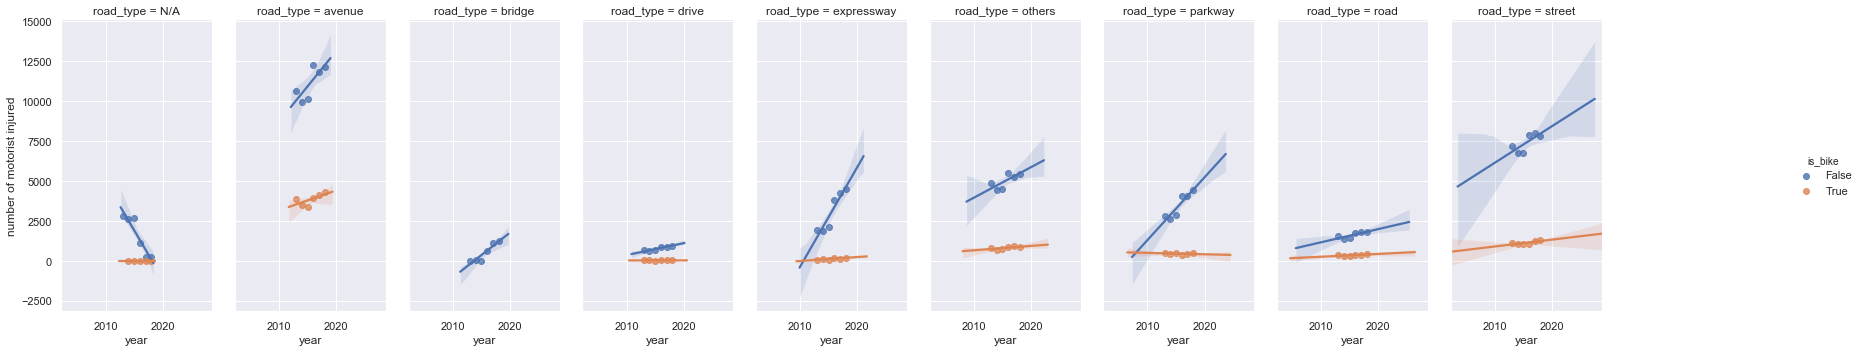

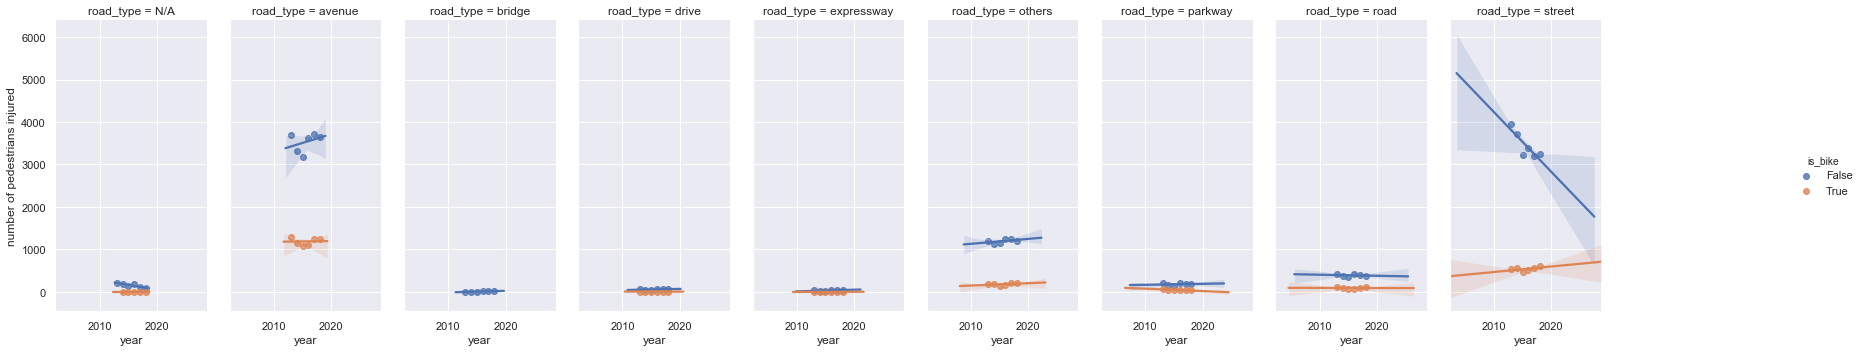

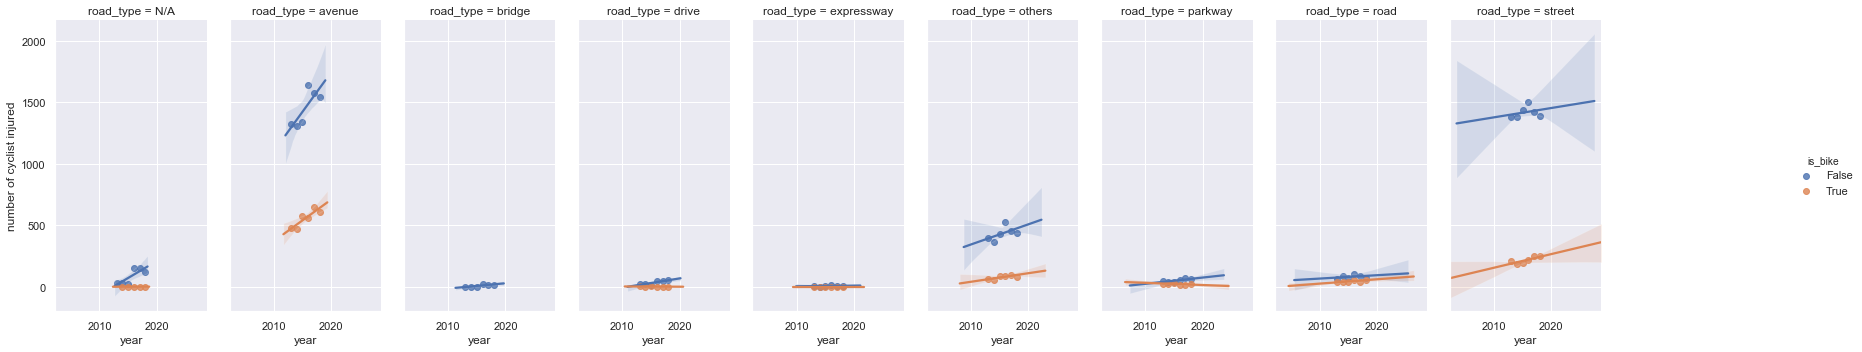

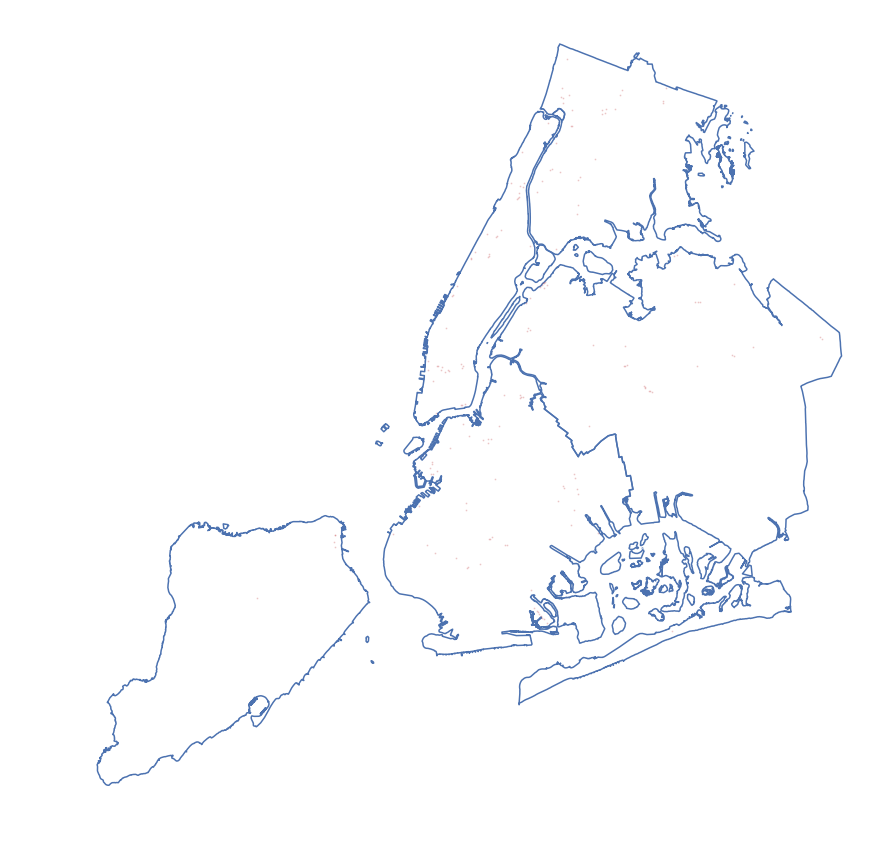

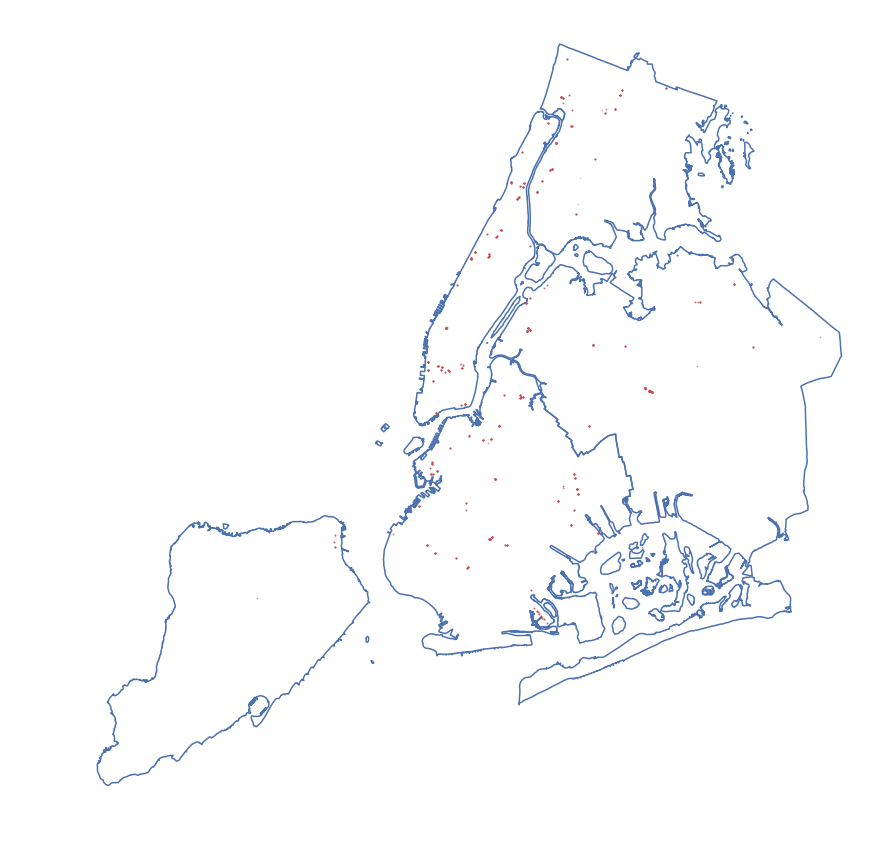

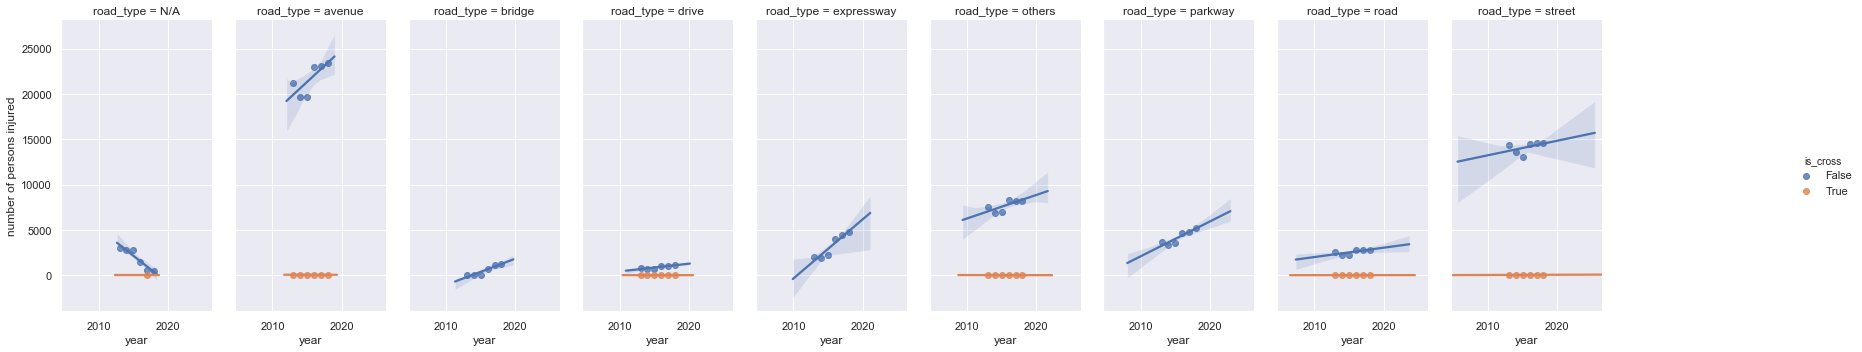

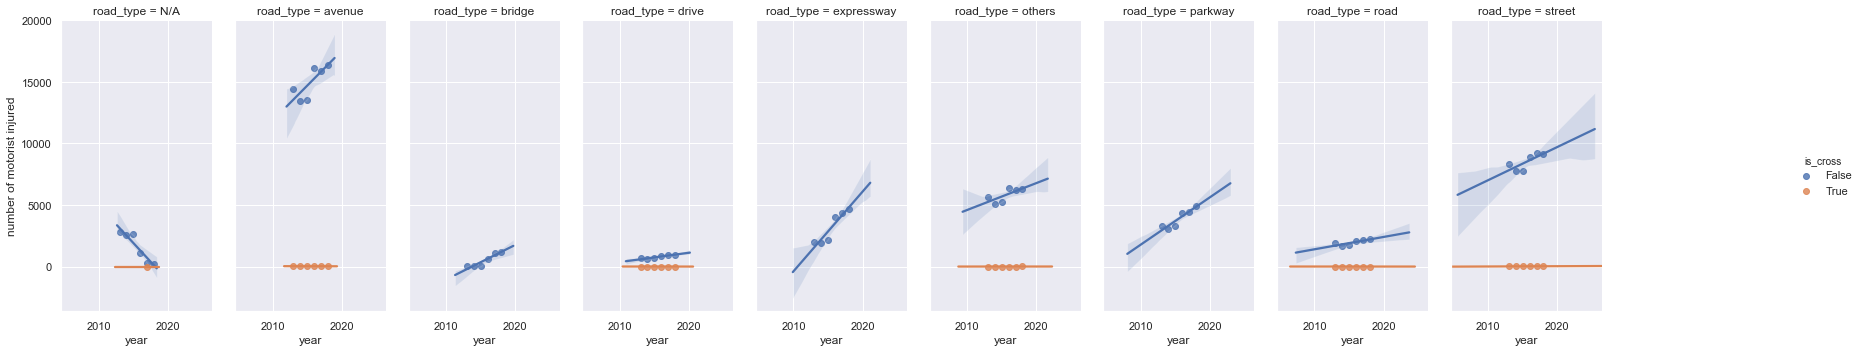

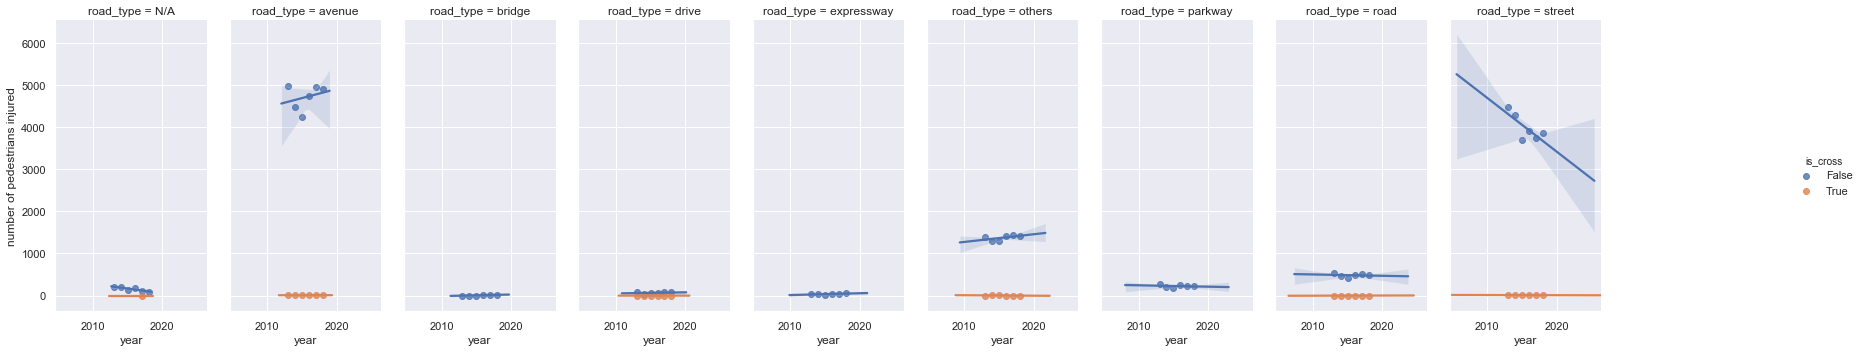

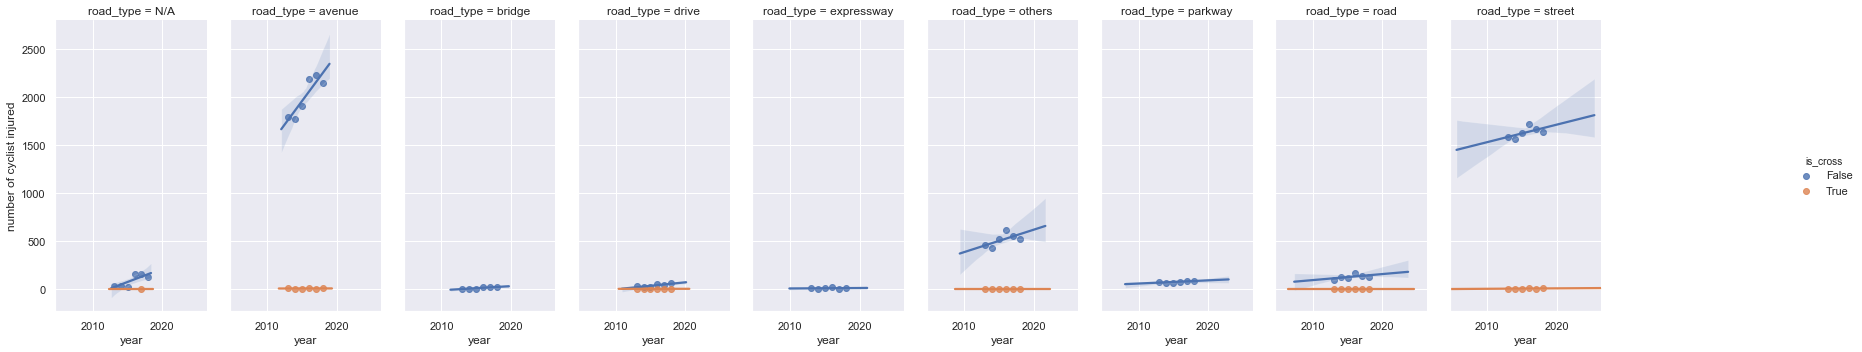

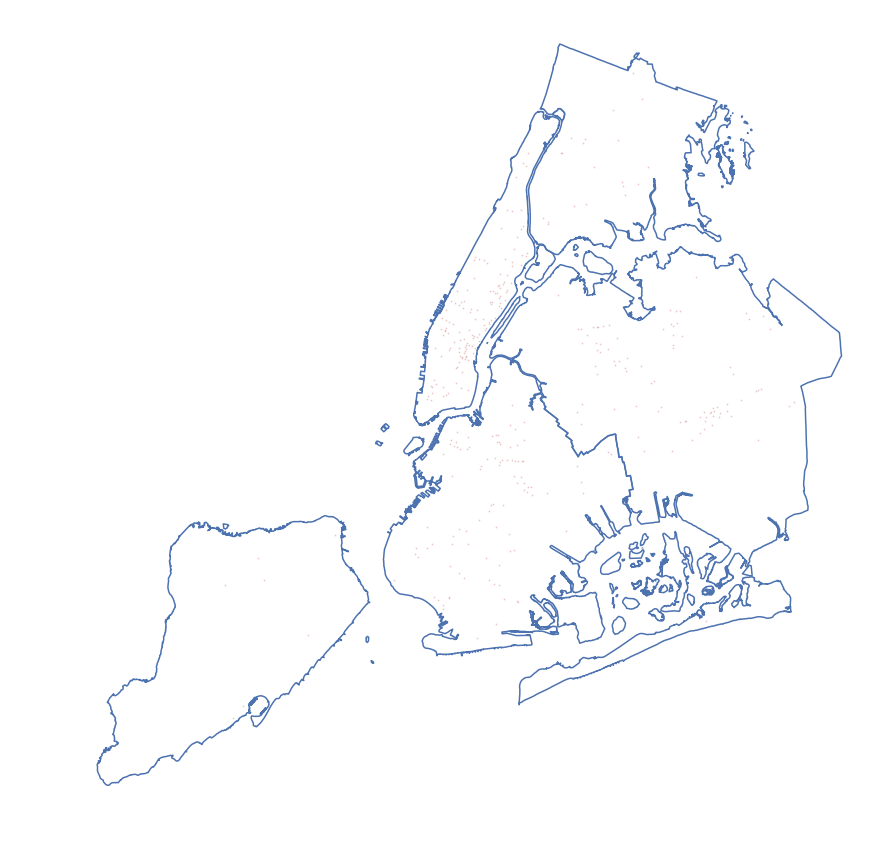

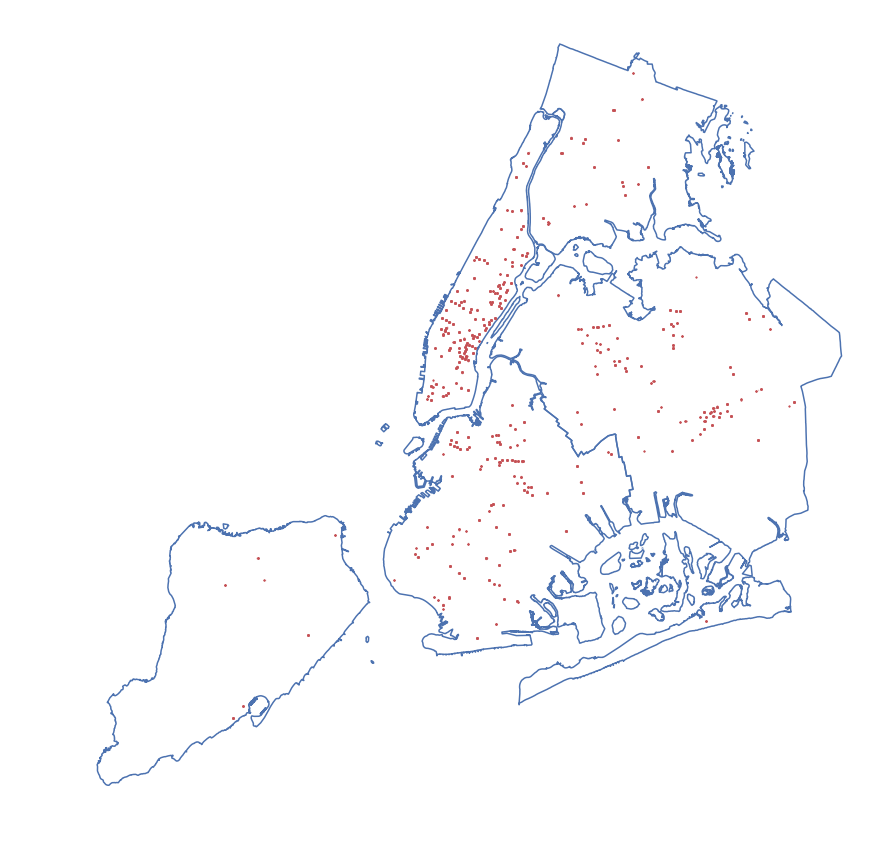

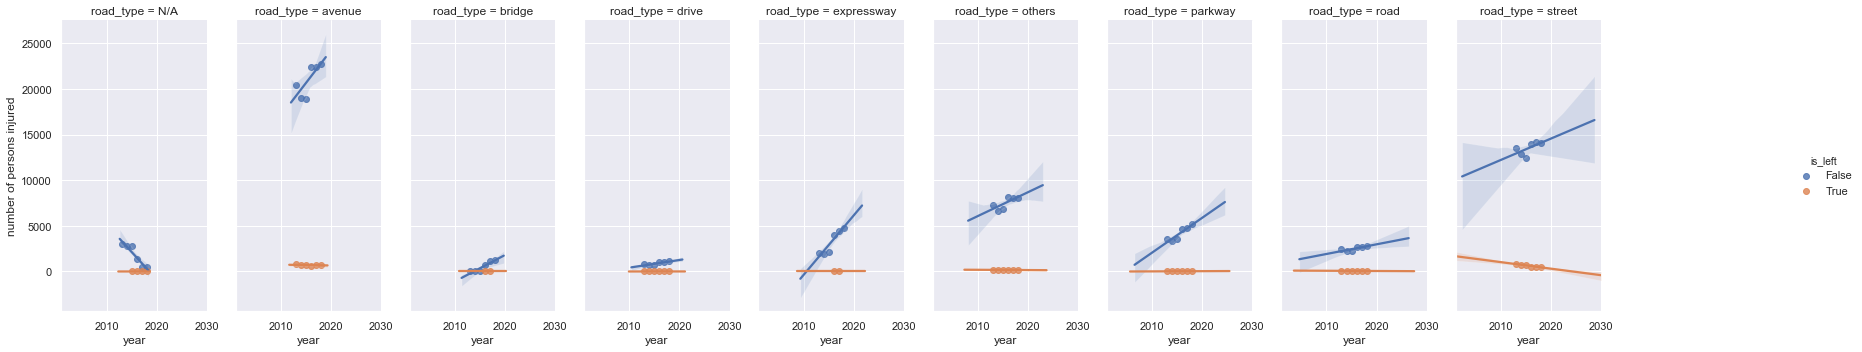

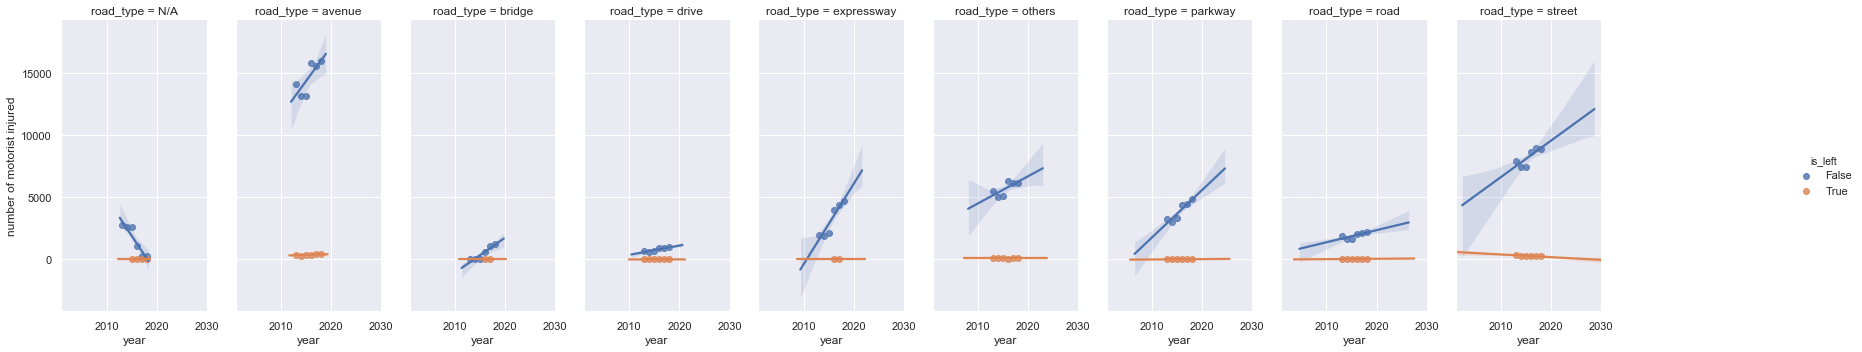

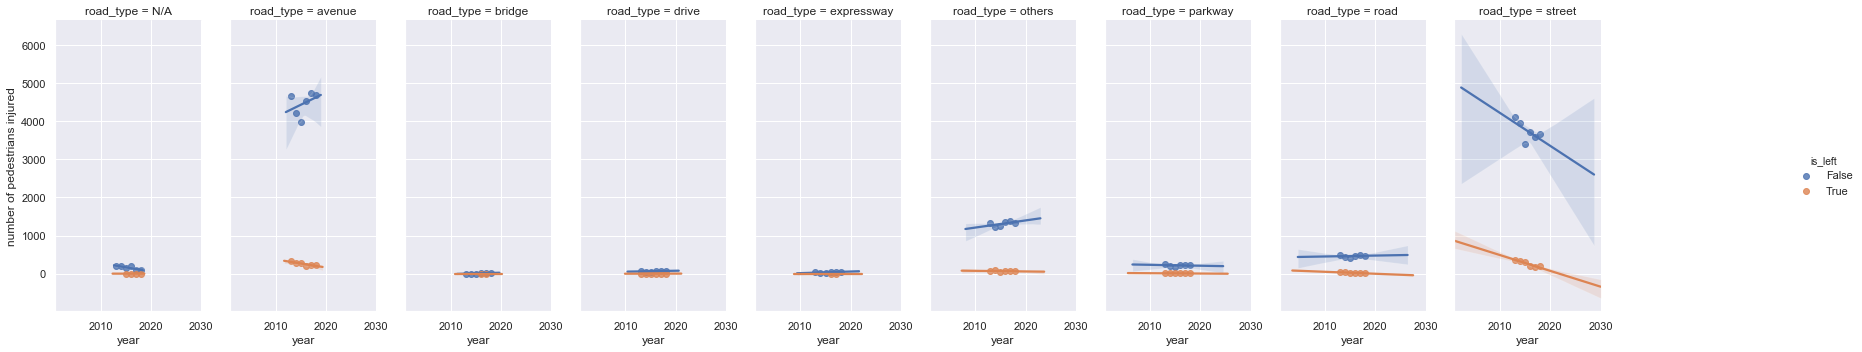

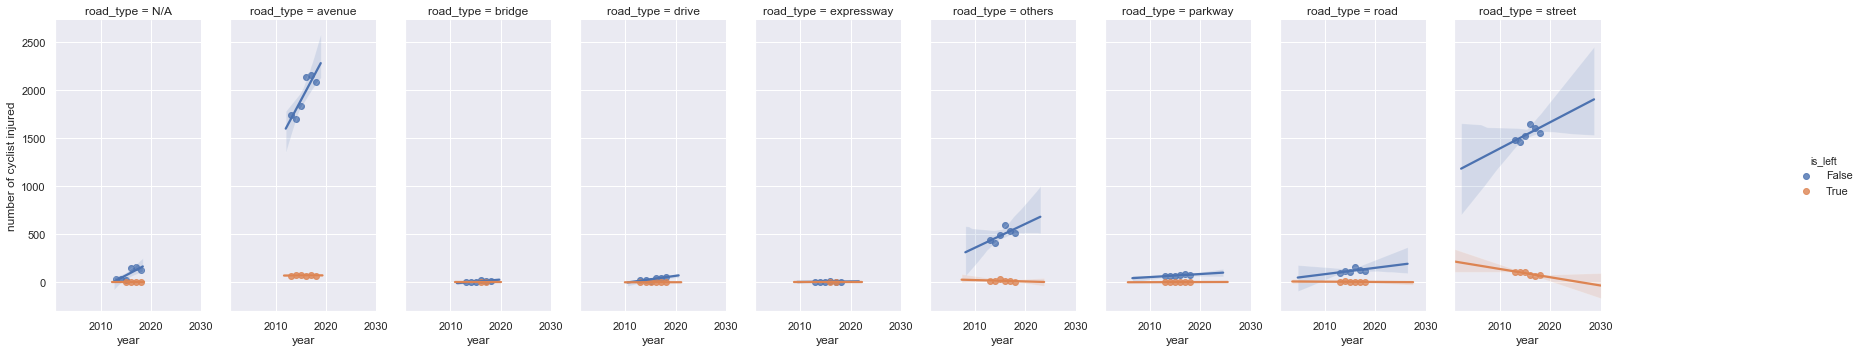

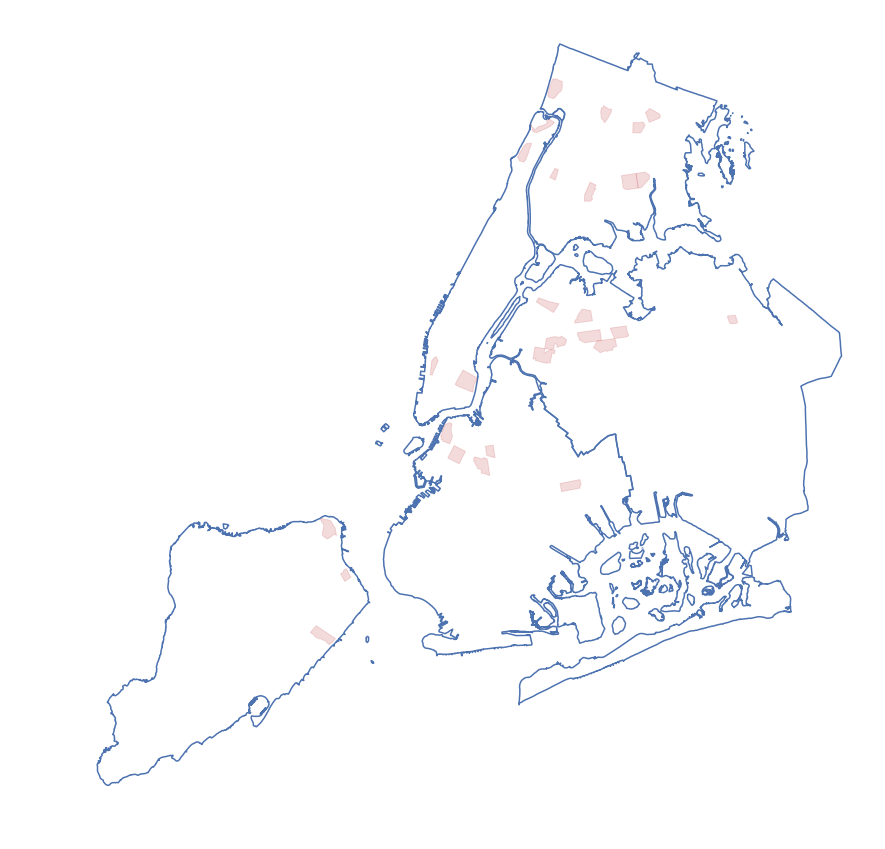

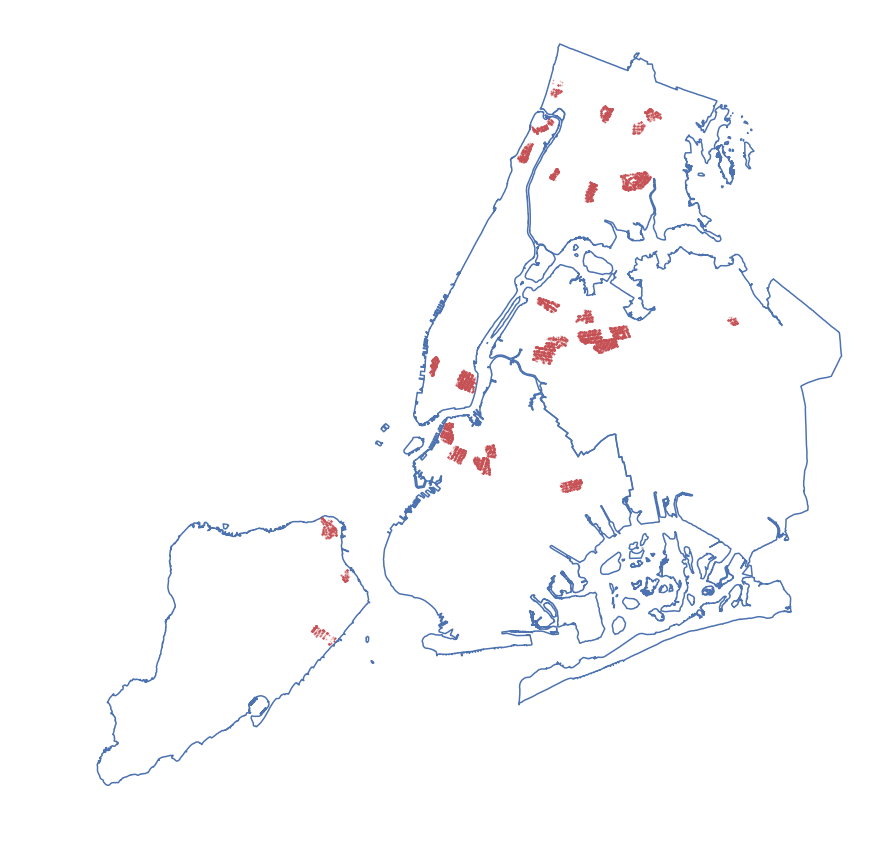

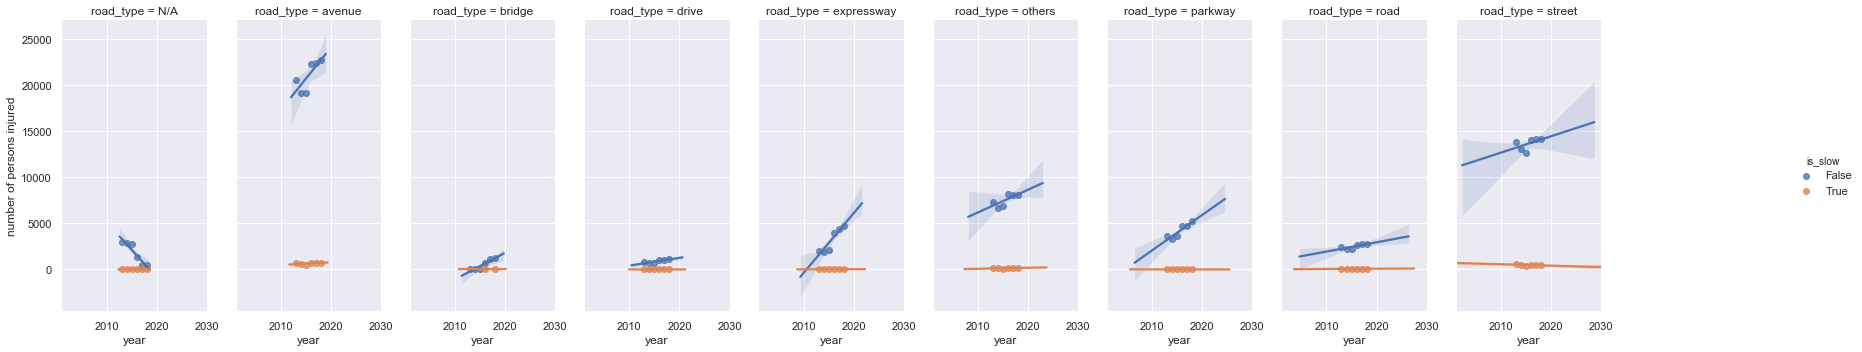

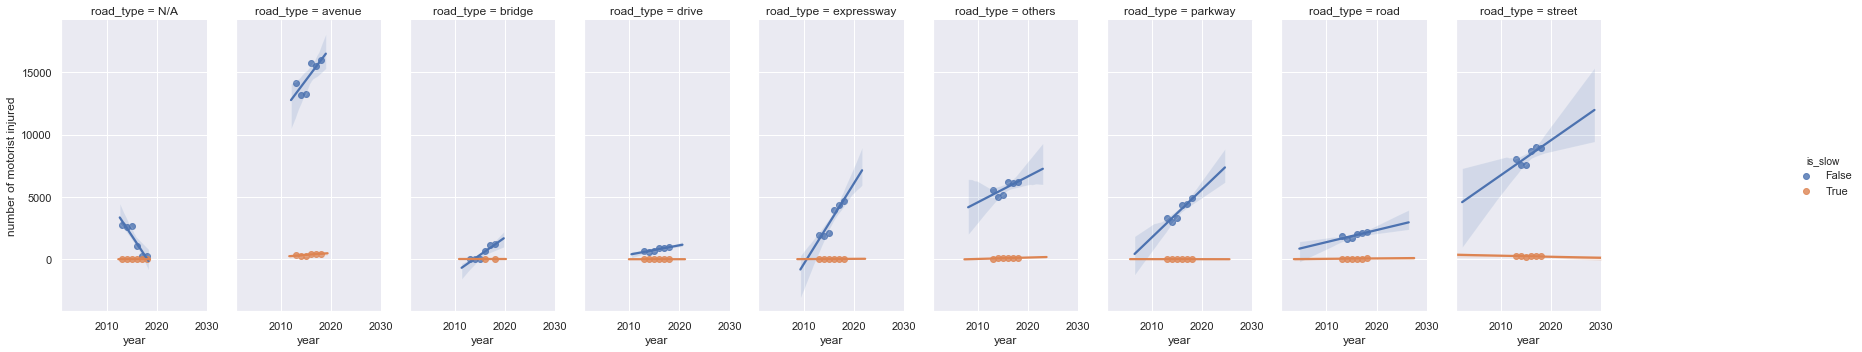

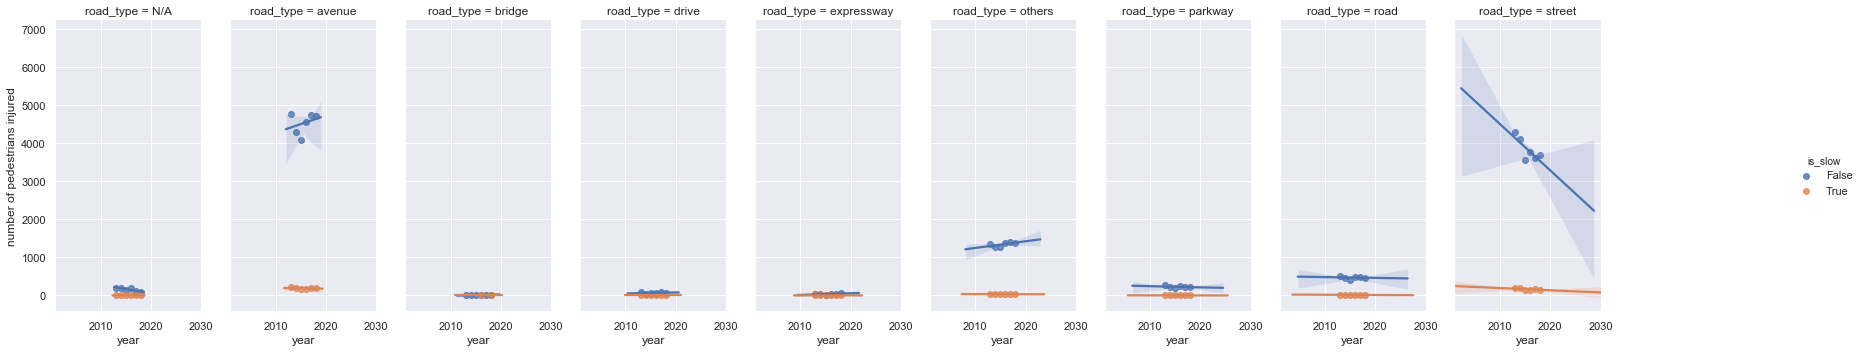

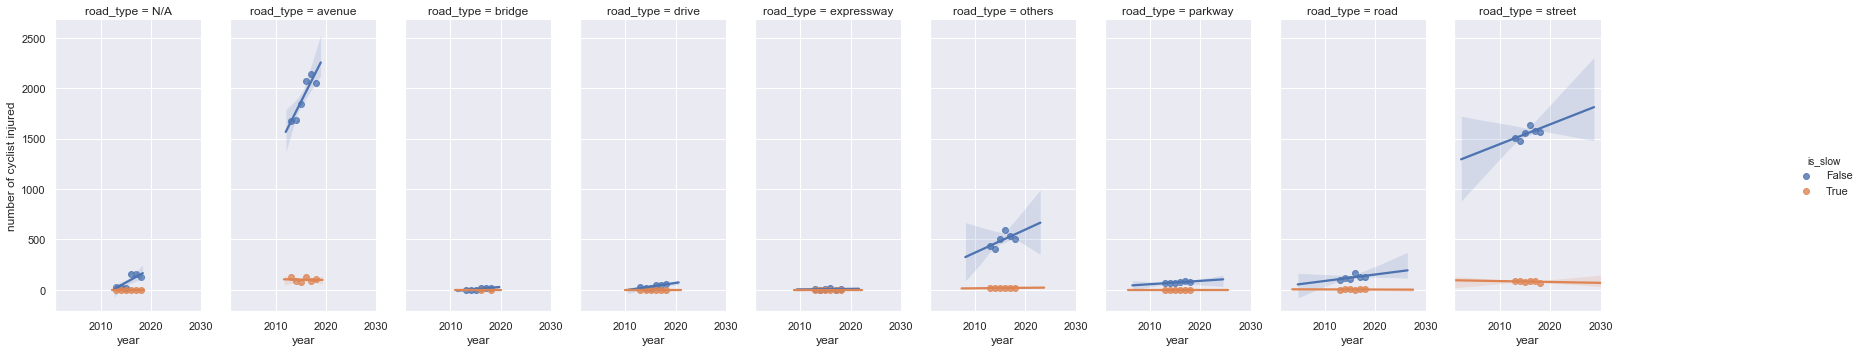

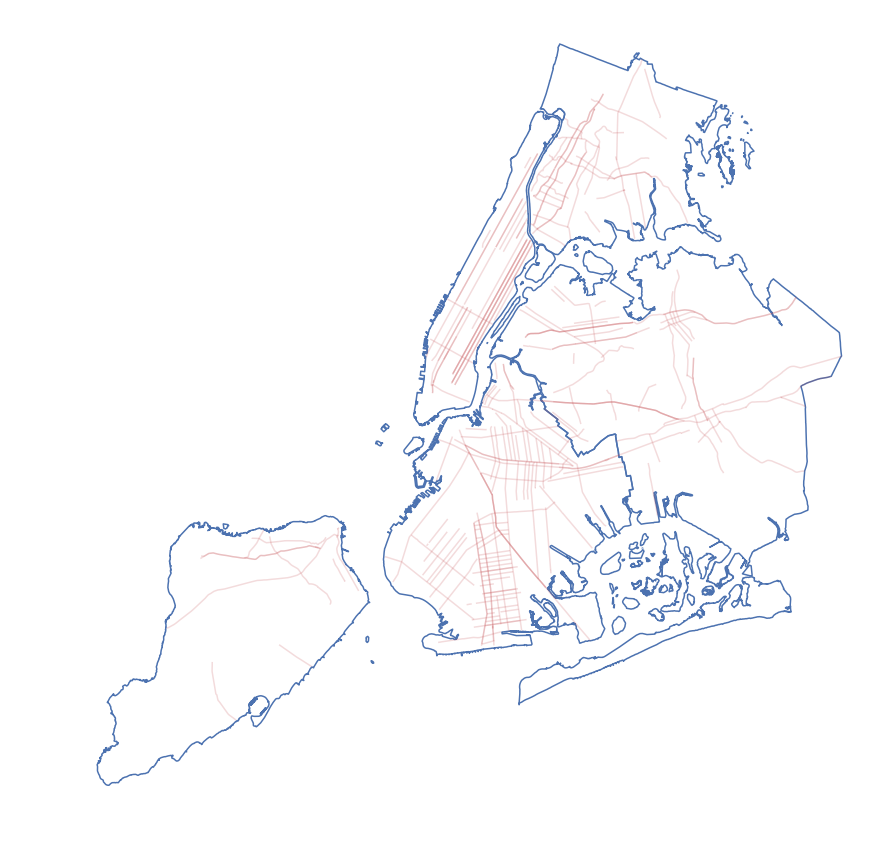

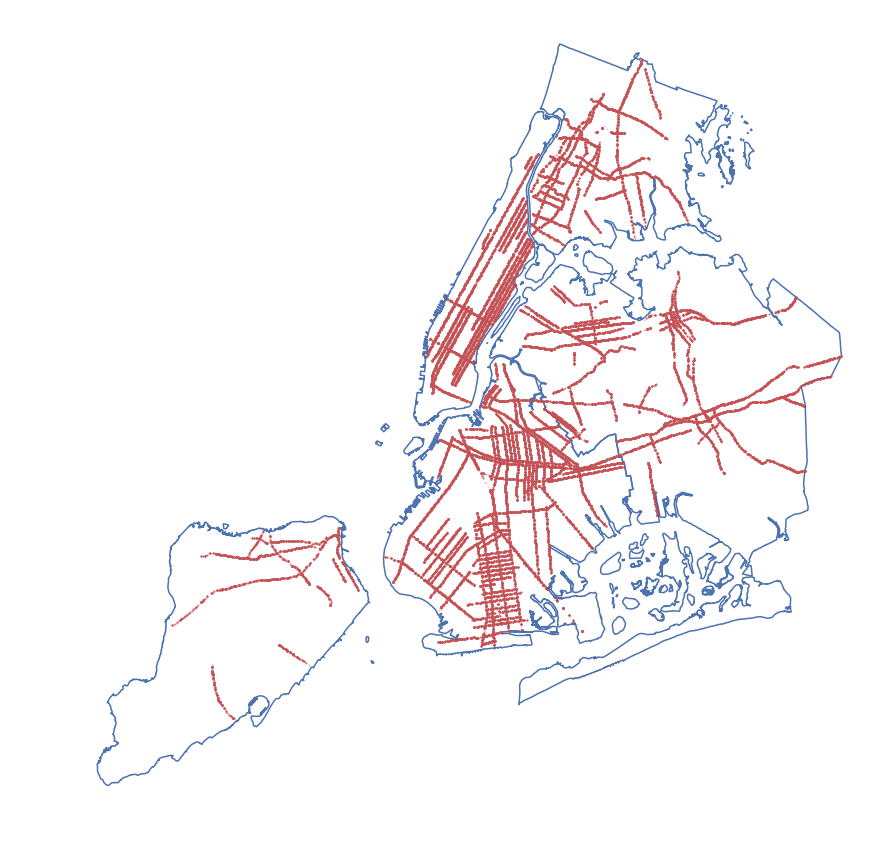

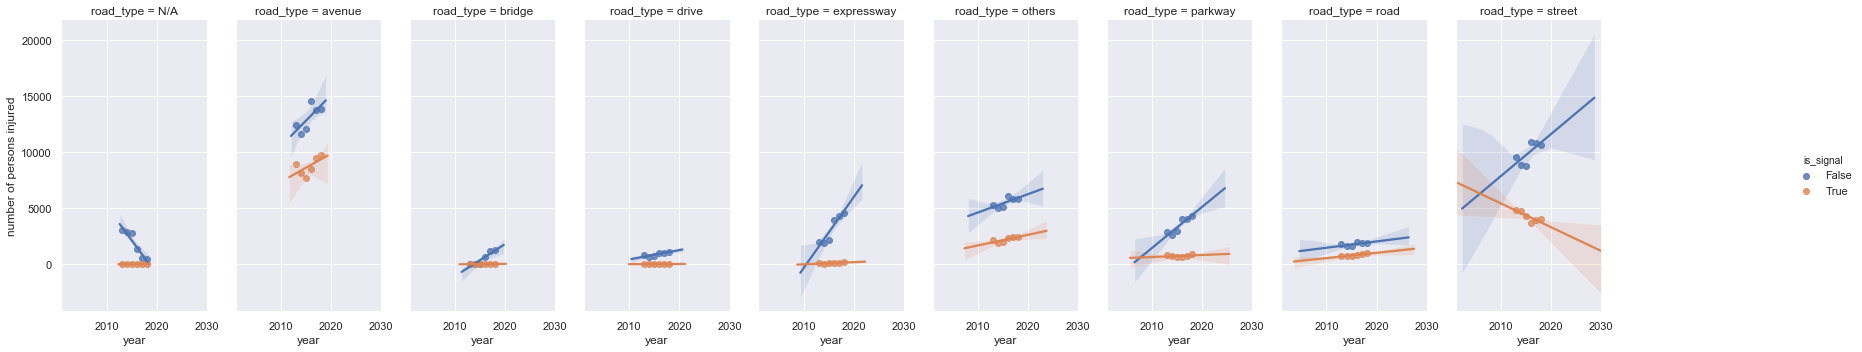

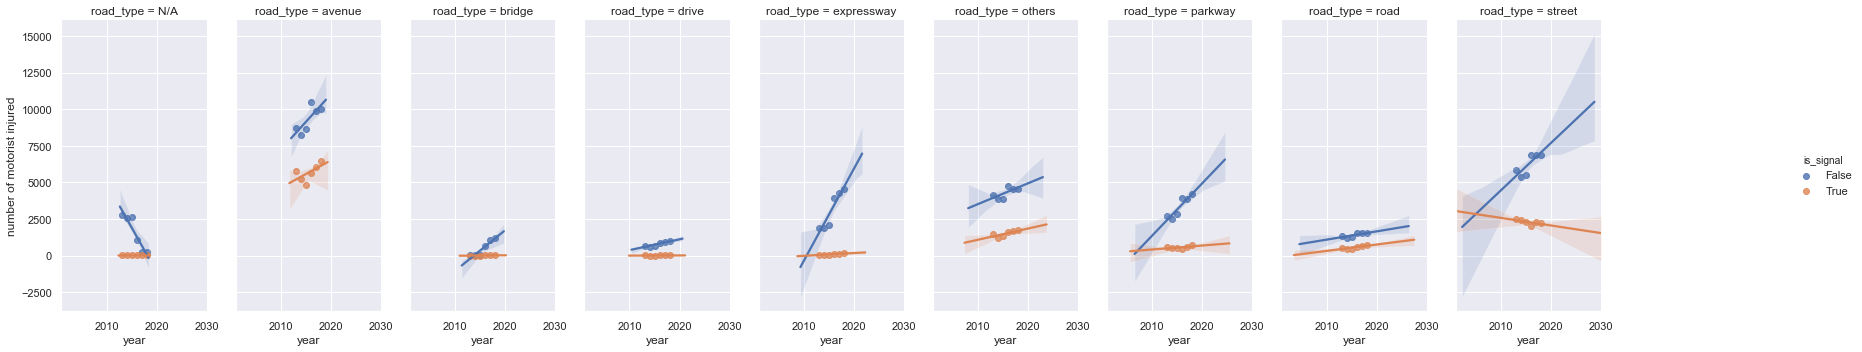

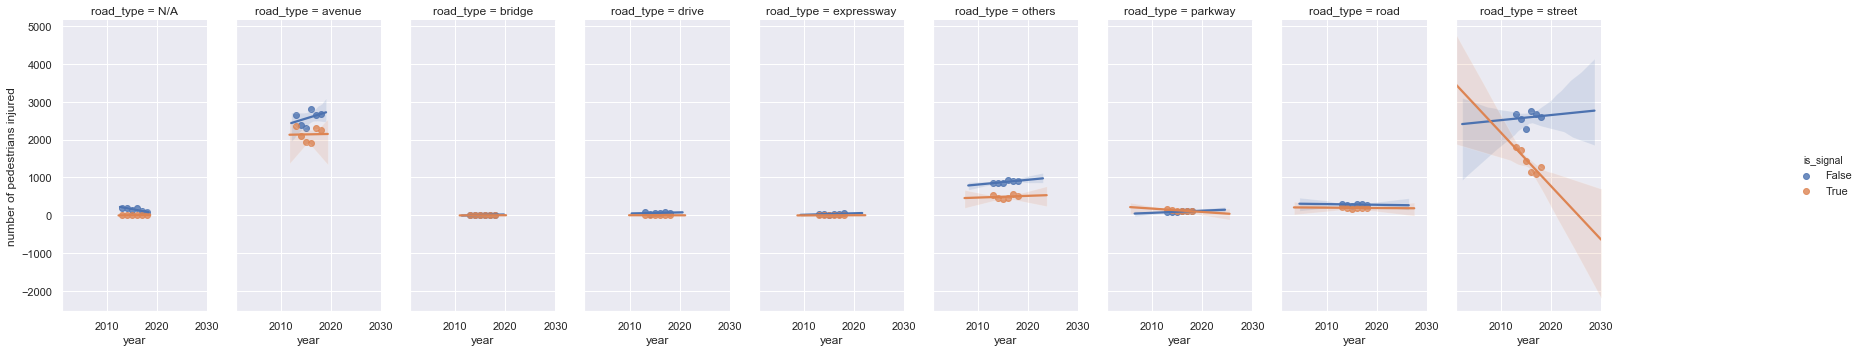

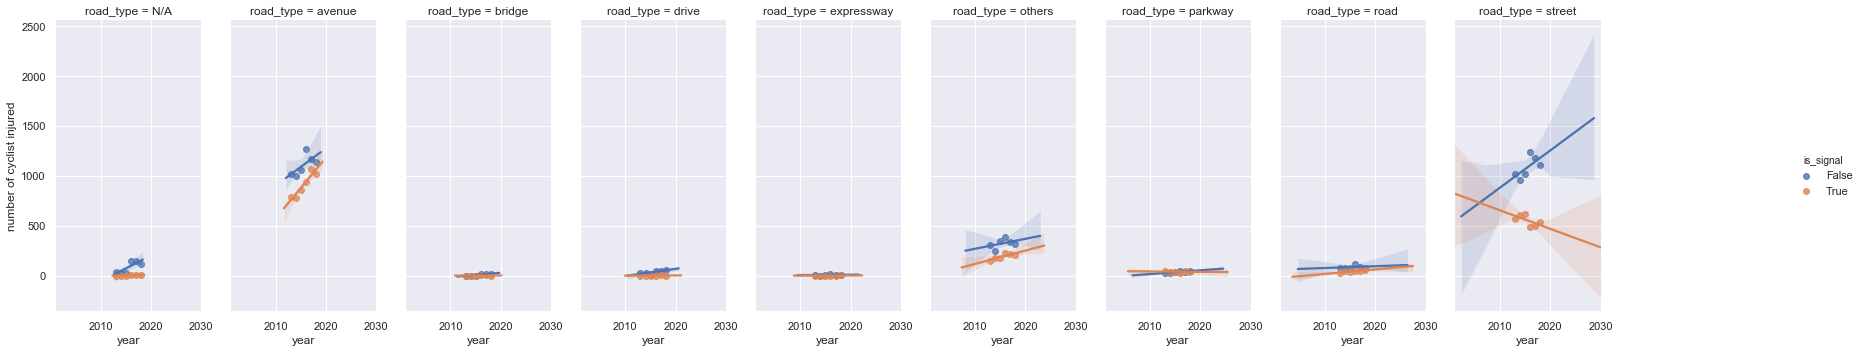

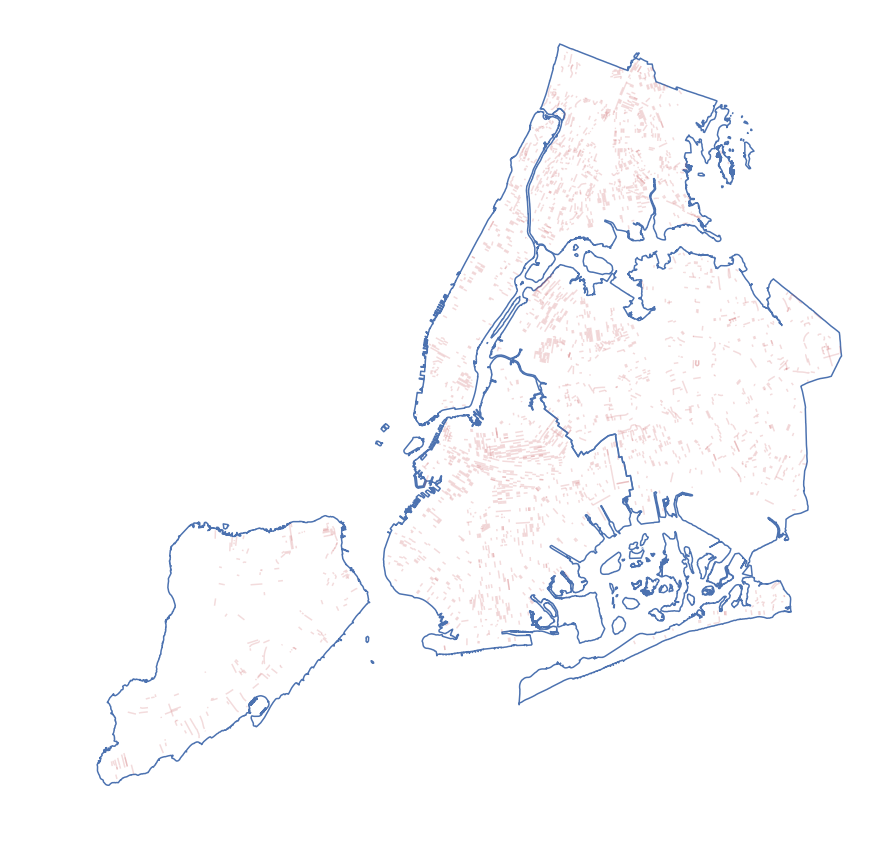

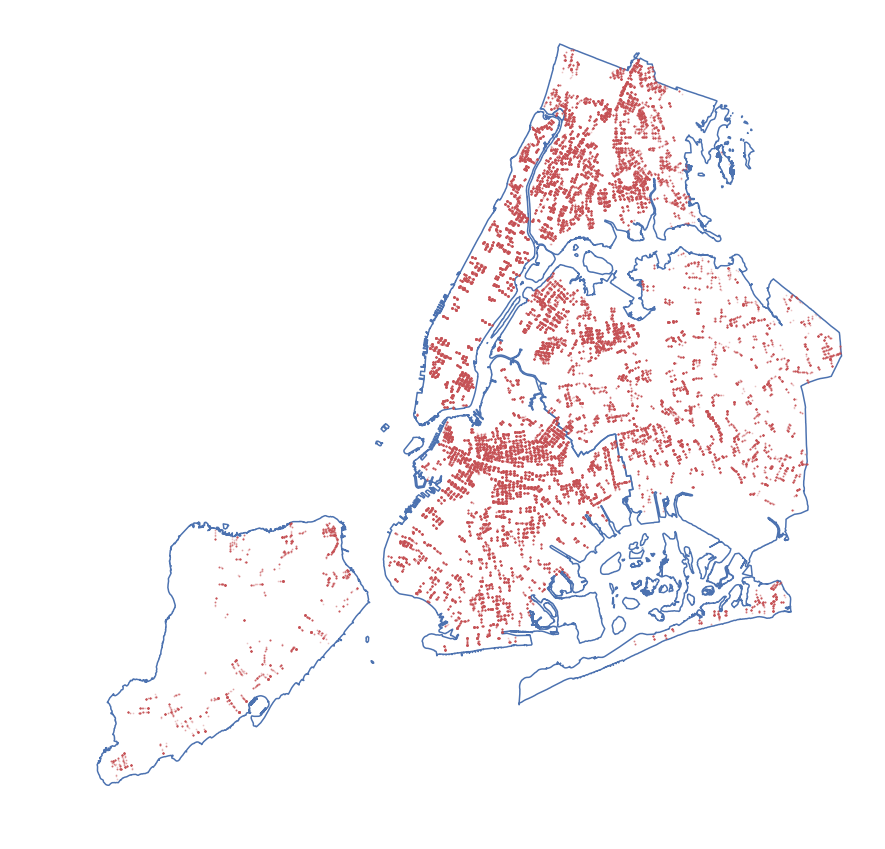

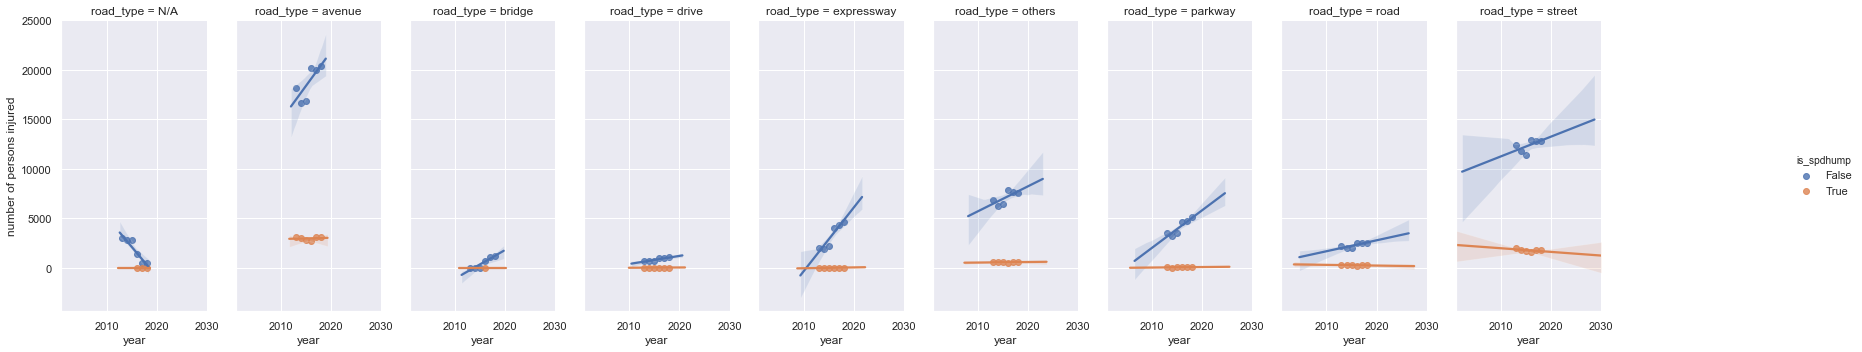

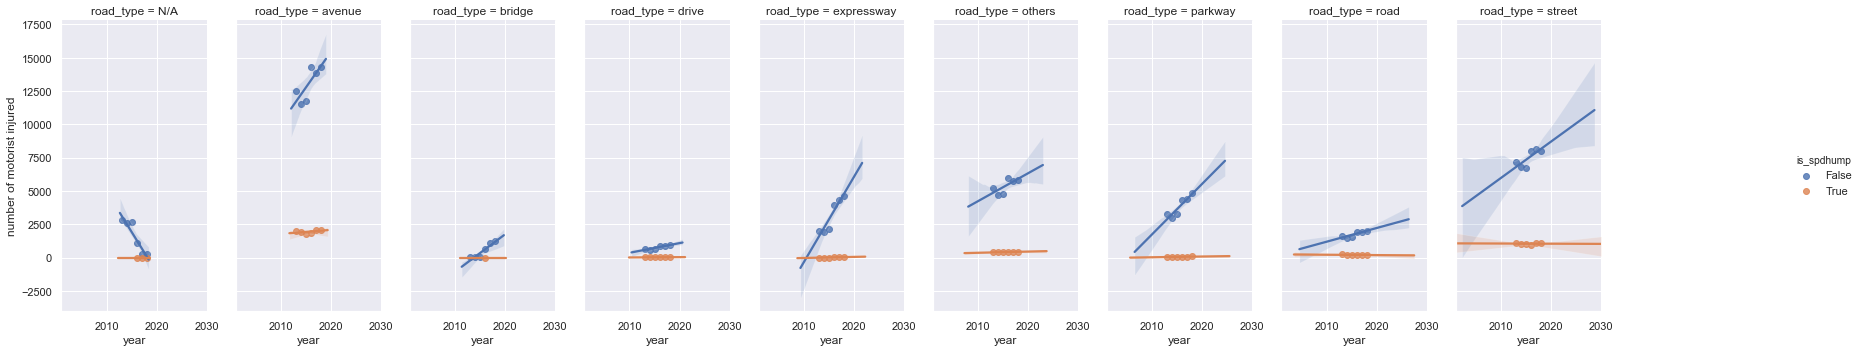

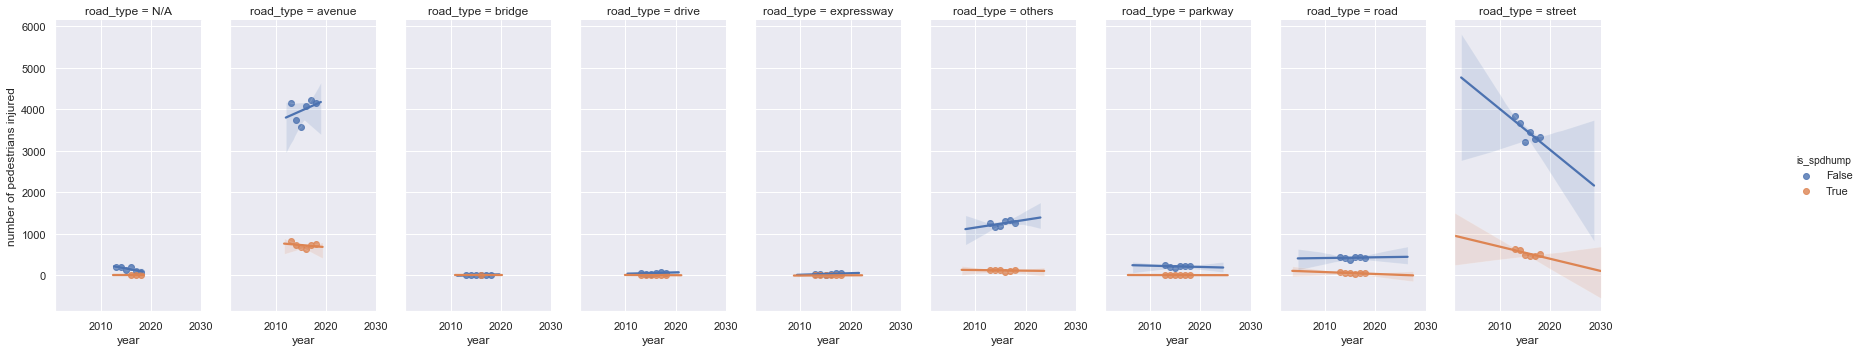

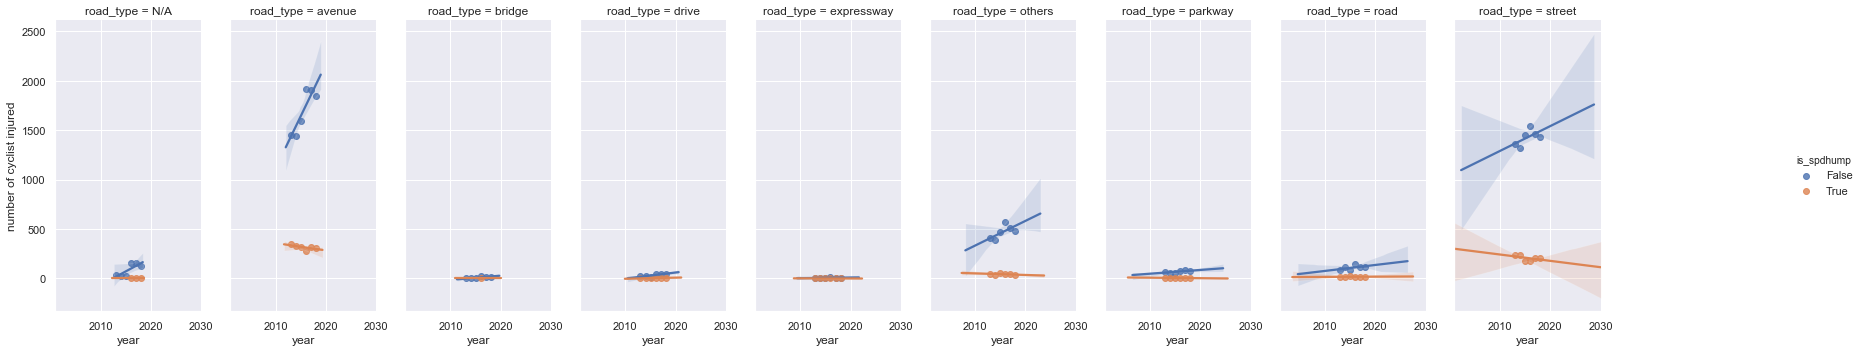

In [65]:
Plot_Geoms_On_NYCMap(df_arterial['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_arterial'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_arterial')

Plot_Geoms_On_NYCMap(df_bike['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_bike'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_bike')

Plot_Geoms_On_NYCMap(df_cross['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_cross'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_cross')

Plot_Geoms_On_NYCMap(df_left['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_left'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_left')

Plot_Geoms_On_NYCMap(df_slow['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_slow'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_slow')

Plot_Geoms_On_NYCMap(df_signal['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_signal'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_signal')

Plot_Geoms_On_NYCMap(df_spdhump['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_spdhump'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_spdhump')

# Plot_Geoms_On_NYCMap(df_spdlimit['the_geom'], ON_MAP=False)
# Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_spdlimit')

In [183]:
for c in ['is_arterial', 'is_bike', 'is_cross','is_left', 'is_slow', 'is_signal', 'is_spdhump']: 
    print(df_col[c].unique())

count     1558237
unique          2
top         False
freq      1391850
Name: is_arterial, dtype: object
count     1558237
unique          2
top         False
freq      1331154
Name: is_bike, dtype: object
count     1558237
unique          2
top         False
freq      1555488
Name: is_cross, dtype: object
count     1558237
unique          2
top         False
freq      1514588
Name: is_left, dtype: object
count     1558237
unique          2
top         False
freq      1517575
Name: is_slow, dtype: object
count     1558237
unique          2
top         False
freq      1105969
Name: is_signal, dtype: object
count     1558237
unique          2
top         False
freq      1401935
Name: is_spdhump, dtype: object


In [192]:
for c in ['is_arterial', 'is_bike', 'is_cross','is_left', 'is_slow', 'is_signal', 'is_spdhump']:
    conditions = [
    (df_col[c] == False),
    (df_col[c] == True)]
    choices = [0, 1]
    df_col[c] = np.select(conditions, choices, default=np.nan)
    
    print(df_col[c].value_counts())


#conditions = [
#    (df_col['is_arterial'] == False),
#    (df_col['is_arterial'] == True)]
#choices = [0, 1]
#df_col['is_arterial'] = np.select(conditions, choices, default=np.nan)
#
#df_col.is_arterial.value_counts()
#df_col.is_bike.value_counts()

0.0    1391850
1.0     166387
Name: is_arterial, dtype: int64
0.0    1331154
1.0     227083
Name: is_bike, dtype: int64
0.0    1555488
1.0       2749
Name: is_cross, dtype: int64
0.0    1514588
1.0      43649
Name: is_left, dtype: int64
0.0    1517575
1.0      40662
Name: is_slow, dtype: int64
0.0    1105969
1.0     452268
Name: is_signal, dtype: int64
0.0    1401935
1.0     156302
Name: is_spdhump, dtype: int64


In [157]:
#df_col.columns

factors = ['contributing factor vehicle 1', 'contributing factor vehicle 2',
       'contributing factor vehicle 3', 'contributing factor vehicle 4',
       'contributing factor vehicle 5', 'vehicle type code 1',
       'vehicle type code 2', 'vehicle type code 3', 'vehicle type code 4',
       'vehicle type code 5']

for f in factors:
    print(df_col[f].unique())

['Other Vehicular' 'Reaction to Uninvolved Vehicle' 'Passing Too Closely'
 'View Obstructed/Limited' 'Unsafe Lane Changing' 'Driver Inexperience'
 'Following Too Closely' 'Backing Unsafely' 'Unspecified'
 'Failure to Yield Right-of-Way' 'Brakes Defective'
 'Driver Inattention/Distraction' 'Passing or Lane Usage Improper'
 'Other Electronic Device' 'Alcohol Involvement'
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion' 'Unsafe Speed'
 'Steering Failure' nan 'Illnes' 'Aggressive Driving/Road Rage'
 'Obstruction/Debris' 'Lane Marking Improper/Inadequate' 'Fell Asleep'
 'Turning Improperly' 'Oversized Vehicle' 'Tire Failure/Inadequate'
 'Glare' 'Fatigued/Drowsy' 'Driverless/Runaway Vehicle'
 'Failure to Keep Right' 'Pavement Defective'
 'Traffic Control Disregarded' 'Outside Car Distraction' 'Animals Action'
 'Lost Consciousness' 'Pavement Slippery' 'Passenger Distraction'
 'Eating or Drinking' 'Cell Phone (hand-Held)' 'Tow Hitch Defective'
 'Physical Disability' 'Drugs (illegal)' '

In [194]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558237 entries, 0 to 1558236
Data columns (total 45 columns):
unique id                        1558237 non-null int64
date                             1558237 non-null object
time                             1558237 non-null object
borough                          1558237 non-null object
zip code                         1392091 non-null object
latitude                         1364727 non-null float64
longitude                        1364727 non-null float64
location                         1364727 non-null object
on street name                   1503396 non-null object
cross street name                1044964 non-null object
off street name                  211127 non-null object
number of persons injured        1558220 non-null float64
number of pedestrians injured    1558237 non-null int64
number of pedestrians killed     1558237 non-null int64
number of cyclist injured        1558237 non-null int64
number of cyclist killed         1

In [180]:
#import statsmodels.formula.api as smf
#import statsmodels.api as sm
#
#formula = 'number of persons injured ~ is_arterial + is_bike + is_cross + is_left + is_slow + is_signal + is_spdhump'
#
##lm_model = smf.Logit(formula = formula, data = df_col).fit()
##print (lm_model.summary())
#
##degree_glm = smf.glm(formula=formula, data=df_col, family = sm.families.Binomial()).fit()
##print(degree_glm.summary())

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [130]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

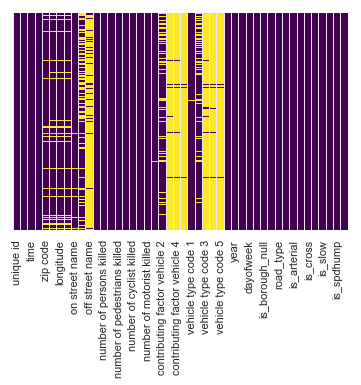

In [138]:
sns.heatmap(df_col.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [143]:
#test_killed = pd.get_dummies(df_col['number of persons killed'],drop_first=True)
#test_arterial = pd.get_dummies(df_col['is_arterial'], drop_first = True)
#test_bike = pd.get_dummies(df_col['is_bike'], drop_first = True)
#test_cross = pd.get_dummies(df_col['is_cross'], drop_first = True)
#test_slow  = pd.get_dummies(df_col['is_slow'], drop_first = True)
#test_signal = pd.get_dummies(df_col['is_signal'], drop_first = True)
#test_spdhump = pd.get_dummies(df_col['is_spdhump'], drop_first = True)
#
#df_col.drop(['number of persons killed','is_arterial','is_bike','is_cross','is_slow','is_signal', 'is_spdhump'],axis=1,inplace=True)#concatenate new sex and embark column to our train dataframe
#test = pd.concat([df_col,test_killed,test_arterial,test_bike,test_cross,test_slow,test_signal,test_spdhump],
#                  axis=1)#check the head of dataframe
#test_killed.head()

KeyError: 'number of persons killed'

In [200]:
df_col.to_csv(r'C:\Users\caffr\OneDrive\바탕 화면\Columbia\4th Semester\Capstone\data\all.dat.csv')

In [151]:
df_col.columns

Index(['unique id', 'date', 'time', 'borough', 'zip code', 'latitude',
       'longitude', 'location', 'on street name', 'cross street name',
       'off street name', 'number of persons injured',
       'number of pedestrians injured', 'number of pedestrians killed',
       'number of cyclist injured', 'number of cyclist killed',
       'number of motorist injured', 'number of motorist killed',
       'contributing factor vehicle 1', 'contributing factor vehicle 2',
       'contributing factor vehicle 3', 'contributing factor vehicle 4',
       'contributing factor vehicle 5', 'vehicle type code 1',
       'vehicle type code 2', 'vehicle type code 3', 'vehicle type code 4',
       'vehicle type code 5', 'date_time', 'year', 'month', 'dayofweek',
       'hour', 'is_borough_null', 'is_location_null', 'road_type',
       'is_expressway', 'is_left', 'KSI'],
      dtype='object')

In [171]:
import sklearn.linear_model as lm

x = df_col[['is_arterial','is_bike','is_cross','is_slow','is_signal','is_spdhump']]
y = df_col['number of cyclist injured']

logmodel = lm.LogisticRegression(x,y)


In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
x = df_col[['is_arterial','is_bike','is_cross','is_slow','is_signal','is_spdhump']]
y = df_col['number of cyclist injured']

logmodel.fit(x,y)

